In [2]:
import numpy as np
import librosa
import glob
import pickle
from tqdm import tqdm

from MusicVectorizer import MusicVectorizer

SAMPLE_RATE = 16000

In [3]:
data_folders = ["90s_hiphop", "90s_rock", "2010s_pop", "classical", "country"]

In [4]:
# load trajectories
trajectories = dict()
for folder in data_folders:
    trajectories[folder] = np.load(f"data/{folder}_trajectories.npy", allow_pickle=True).item()

In [5]:
lengths = list()
for folder in data_folders:
    for file in trajectories[folder]:
        lengths.append(trajectories[folder][file].shape[0])

In [7]:
# total number of features that we have:
N = np.sum(lengths)
N

19218

In [17]:
X = np.zeros((N, 13, 768))
y = np.zeros(N)

i = 0
for idx, genre in enumerate(data_folders):
    for file in trajectories[genre]:
        X[i:i+trajectories[genre][file].shape[0], :, :] = trajectories[genre][file]
        y[i:i+trajectories[genre][file].shape[0]] = idx
        i += trajectories[genre][file].shape[0]

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', categories='auto')
y = enc.fit_transform(y.reshape(-1, 1)).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [43]:
# Crazy Torch Model
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # First fully connected layer
      self.fc1 = nn.Linear(13 * 768, 768)
      
      # Get outputs
      self.fc2 = nn.Linear(768,5)
      
    def forward(self, x):
      outputs = F.relu(self.fc1(x))
      outputs = F.sigmoid(self.fc2(outputs))
      return outputs

In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Net().to(device)
print(model, device)

Net(
  (fc1): Linear(in_features=9984, out_features=768, bias=True)
  (fc2): Linear(in_features=768, out_features=5, bias=True)
) cuda


In [50]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [60]:
# GET DATA HERE
X_train, X_test = torch.Tensor(X_train).flatten(start_dim=1).to(device) ,torch.Tensor(X_test).flatten(start_dim=1).to(device)
y_train, y_test = torch.Tensor(y_train).to(device) ,torch.Tensor(y_test).to(device)

In [72]:
epochs = 1000

losses = []
losses_test = []
Iterations = []
iter = 0
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train)
    loss = criterion(torch.squeeze(outputs), labels) # [200,1] -squeeze-> [200]
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves 
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter+=1
    
        # calculate Accuracy
    with torch.no_grad():
        # Calculating the loss and accuracy for the test dataset
        correct_test = 0
        total_test = 0
        outputs_test = torch.squeeze(model(X_test).cpu())
        loss_test = criterion(outputs_test.cpu(), y_test.cpu())
        
        predicted_test = outputs_test.round().detach().cpu().numpy()
        total_test += y_test.size(0)
        correct_test += np.sum(predicted_test == y_test.detach().cpu().numpy())
        accuracy_test = 100 * correct_test/total_test
        losses_test.append(loss_test.item())
        
        # Calculating the loss and accuracy for the train dataset
        total = 0
        correct = 0
        total += y_train.size(0)
        correct += np.sum(torch.squeeze(outputs).round().detach().cpu().numpy() == y_train.detach().cpu().numpy())
        accuracy = 100 * correct/total
        losses.append(loss.item())
        Iterations.append(iter)

        if iter%1==0:
            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

Training Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]/home/shrey/.local/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Training Epochs:   0%|          | 2/1000 [00:00<01:53,  8.78it/s]

Iteration: 1. 
Test - Loss: 0.36861884593963623. Accuracy: 422.0343392299688
Train -  Loss: 0.36799585819244385. Accuracy: 422.71367243397947

Iteration: 2. 
Test - Loss: 0.3685300946235657. Accuracy: 422.13839750260144
Train -  Loss: 0.3679058849811554. Accuracy: 422.74619487446336



Training Epochs:   0%|          | 4/1000 [00:00<01:52,  8.87it/s]

Iteration: 3. 
Test - Loss: 0.3684414327144623. Accuracy: 422.24245577523413
Train -  Loss: 0.36781594157218933. Accuracy: 422.76570833875377

Iteration: 4. 
Test - Loss: 0.36835283041000366. Accuracy: 422.24245577523413
Train -  Loss: 0.3677261769771576. Accuracy: 422.7787173149473



Training Epochs:   1%|          | 6/1000 [00:00<01:52,  8.83it/s]

Iteration: 5. 
Test - Loss: 0.3682643473148346. Accuracy: 422.29448491155046
Train -  Loss: 0.36763641238212585. Accuracy: 422.81123975543125

Iteration: 6. 
Test - Loss: 0.3681758940219879. Accuracy: 422.2684703433923
Train -  Loss: 0.36754676699638367. Accuracy: 422.8437621959152



Training Epochs:   1%|          | 8/1000 [00:00<01:51,  8.89it/s]

Iteration: 7. 
Test - Loss: 0.3680875599384308. Accuracy: 422.2684703433923
Train -  Loss: 0.36745718121528625. Accuracy: 422.8827891244959

Iteration: 8. 
Test - Loss: 0.36799928545951843. Accuracy: 422.29448491155046
Train -  Loss: 0.3673677146434784. Accuracy: 422.91531156497985



Training Epochs:   1%|          | 10/1000 [00:01<01:49,  9.05it/s]

Iteration: 9. 
Test - Loss: 0.367911159992218. Accuracy: 422.29448491155046
Train -  Loss: 0.3672783374786377. Accuracy: 422.92832054117343

Iteration: 10. 
Test - Loss: 0.36782306432724. Accuracy: 422.29448491155046
Train -  Loss: 0.36718904972076416. Accuracy: 422.9478340054638



Training Epochs:   1%|          | 12/1000 [00:01<01:48,  9.07it/s]

Iteration: 11. 
Test - Loss: 0.36773502826690674. Accuracy: 422.29448491155046
Train -  Loss: 0.367099791765213. Accuracy: 423.00637439833486

Iteration: 12. 
Test - Loss: 0.36764711141586304. Accuracy: 422.29448491155046
Train -  Loss: 0.3670106828212738. Accuracy: 423.00637439833486



Training Epochs:   1%|▏         | 14/1000 [00:01<01:47,  9.19it/s]

Iteration: 13. 
Test - Loss: 0.3675593137741089. Accuracy: 422.32049947970864
Train -  Loss: 0.3669215738773346. Accuracy: 423.0649147912059

Iteration: 14. 
Test - Loss: 0.36747151613235474. Accuracy: 422.39854318418315
Train -  Loss: 0.3668326139450073. Accuracy: 423.07141927930275



Training Epochs:   2%|▏         | 16/1000 [00:01<01:46,  9.20it/s]

Iteration: 15. 
Test - Loss: 0.3673838675022125. Accuracy: 422.39854318418315
Train -  Loss: 0.36674368381500244. Accuracy: 423.11044620788346

Iteration: 16. 
Test - Loss: 0.3672962486743927. Accuracy: 422.47658688865766
Train -  Loss: 0.3666549026966095. Accuracy: 423.14947313646417



Training Epochs:   2%|▏         | 18/1000 [00:01<01:47,  9.11it/s]

Iteration: 17. 
Test - Loss: 0.3672087490558624. Accuracy: 422.5026014568158
Train -  Loss: 0.36656615138053894. Accuracy: 423.15597762456093

Iteration: 18. 
Test - Loss: 0.36712130904197693. Accuracy: 422.5806451612903
Train -  Loss: 0.36647748947143555. Accuracy: 423.1819955769481



Training Epochs:   2%|▏         | 20/1000 [00:02<01:48,  9.04it/s]

Iteration: 19. 
Test - Loss: 0.367033988237381. Accuracy: 422.6326742976067
Train -  Loss: 0.3663889467716217. Accuracy: 423.19500455314164

Iteration: 20. 
Test - Loss: 0.3669467270374298. Accuracy: 422.6586888657648
Train -  Loss: 0.36630046367645264. Accuracy: 423.2340314817224



Training Epochs:   2%|▏         | 22/1000 [00:02<01:46,  9.14it/s]

Iteration: 21. 
Test - Loss: 0.366859495639801. Accuracy: 422.684703433923
Train -  Loss: 0.36621204018592834. Accuracy: 423.24704045791594

Iteration: 22. 
Test - Loss: 0.3667724132537842. Accuracy: 422.7107180020812
Train -  Loss: 0.3661237359046936. Accuracy: 423.2730584103031



Training Epochs:   2%|▏         | 24/1000 [00:02<01:47,  9.11it/s]

Iteration: 23. 
Test - Loss: 0.3666853904724121. Accuracy: 422.684703433923
Train -  Loss: 0.36603546142578125. Accuracy: 423.3250943150774

Iteration: 24. 
Test - Loss: 0.3665984570980072. Accuracy: 422.7107180020812
Train -  Loss: 0.36594727635383606. Accuracy: 423.3446077793678



Training Epochs:   3%|▎         | 26/1000 [00:02<01:46,  9.17it/s]

Iteration: 25. 
Test - Loss: 0.36651161313056946. Accuracy: 422.7107180020812
Train -  Loss: 0.3658592104911804. Accuracy: 423.3836347079485

Iteration: 26. 
Test - Loss: 0.3664248585700989. Accuracy: 422.7367325702393
Train -  Loss: 0.36577123403549194. Accuracy: 423.40314817223884



Training Epochs:   3%|▎         | 28/1000 [00:03<01:45,  9.21it/s]

Iteration: 27. 
Test - Loss: 0.3663381040096283. Accuracy: 422.684703433923
Train -  Loss: 0.36568328738212585. Accuracy: 423.42916612462597

Iteration: 28. 
Test - Loss: 0.36625152826309204. Accuracy: 422.7367325702393
Train -  Loss: 0.3655954897403717. Accuracy: 423.41615714843243



Training Epochs:   3%|▎         | 30/1000 [00:03<01:45,  9.20it/s]

Iteration: 29. 
Test - Loss: 0.3661649823188782. Accuracy: 422.7627471383975
Train -  Loss: 0.36550772190093994. Accuracy: 423.44217510081955

Iteration: 30. 
Test - Loss: 0.36607852578163147. Accuracy: 422.7627471383975
Train -  Loss: 0.36542001366615295. Accuracy: 423.50721998178744



Training Epochs:   3%|▎         | 32/1000 [00:03<01:45,  9.16it/s]

Iteration: 31. 
Test - Loss: 0.36599215865135193. Accuracy: 422.78876170655565
Train -  Loss: 0.3653324544429779. Accuracy: 423.5137244698842

Iteration: 32. 
Test - Loss: 0.36590588092803955. Accuracy: 422.78876170655565
Train -  Loss: 0.36524495482444763. Accuracy: 423.5527513984649



Training Epochs:   3%|▎         | 34/1000 [00:03<01:45,  9.12it/s]

Iteration: 33. 
Test - Loss: 0.36581966280937195. Accuracy: 422.81477627471384
Train -  Loss: 0.36515751481056213. Accuracy: 423.5787693508521

Iteration: 34. 
Test - Loss: 0.3657335340976715. Accuracy: 422.840790842872
Train -  Loss: 0.3650701344013214. Accuracy: 423.6047873032392



Training Epochs:   4%|▎         | 36/1000 [00:03<01:44,  9.18it/s]

Iteration: 35. 
Test - Loss: 0.36564746499061584. Accuracy: 422.89281997918835
Train -  Loss: 0.3649829030036926. Accuracy: 423.63730974372316

Iteration: 36. 
Test - Loss: 0.3655615448951721. Accuracy: 422.91883454734653
Train -  Loss: 0.36489570140838623. Accuracy: 423.6568232080135



Training Epochs:   4%|▍         | 38/1000 [00:04<01:45,  9.12it/s]

Iteration: 37. 
Test - Loss: 0.3654756546020508. Accuracy: 422.91883454734653
Train -  Loss: 0.364808589220047. Accuracy: 423.6698321842071

Iteration: 38. 
Test - Loss: 0.3653898537158966. Accuracy: 422.97086368366286
Train -  Loss: 0.36472153663635254. Accuracy: 423.68934564849746



Training Epochs:   4%|▍         | 40/1000 [00:04<01:45,  9.14it/s]

Iteration: 39. 
Test - Loss: 0.3653041124343872. Accuracy: 423.0228928199792
Train -  Loss: 0.36463463306427. Accuracy: 423.7218680889814

Iteration: 40. 
Test - Loss: 0.36521849036216736. Accuracy: 423.04890738813737
Train -  Loss: 0.3645477592945099. Accuracy: 423.7673995056589



Training Epochs:   4%|▍         | 42/1000 [00:04<01:43,  9.27it/s]

Iteration: 41. 
Test - Loss: 0.3651328980922699. Accuracy: 423.04890738813737
Train -  Loss: 0.3644609749317169. Accuracy: 423.78691296994924

Iteration: 42. 
Test - Loss: 0.3650474548339844. Accuracy: 423.04890738813737
Train -  Loss: 0.3643742799758911. Accuracy: 423.79992194614283



Training Epochs:   4%|▍         | 44/1000 [00:04<01:42,  9.31it/s]

Iteration: 43. 
Test - Loss: 0.36496204137802124. Accuracy: 423.0749219562955
Train -  Loss: 0.3642876148223877. Accuracy: 423.8324443866268

Iteration: 44. 
Test - Loss: 0.36487674713134766. Accuracy: 423.1009365244537
Train -  Loss: 0.3642010986804962. Accuracy: 423.83894887472354



Training Epochs:   5%|▍         | 46/1000 [00:05<01:42,  9.32it/s]

Iteration: 45. 
Test - Loss: 0.36479151248931885. Accuracy: 423.1009365244537
Train -  Loss: 0.3641146421432495. Accuracy: 423.8584623390139

Iteration: 46. 
Test - Loss: 0.3647063374519348. Accuracy: 423.1789802289282
Train -  Loss: 0.36402827501296997. Accuracy: 423.8844802914011



Training Epochs:   5%|▍         | 48/1000 [00:05<01:43,  9.20it/s]

Iteration: 47. 
Test - Loss: 0.36462125182151794. Accuracy: 423.1789802289282
Train -  Loss: 0.3639419376850128. Accuracy: 423.9104982437882

Iteration: 48. 
Test - Loss: 0.36453625559806824. Accuracy: 423.2049947970864
Train -  Loss: 0.3638557195663452. Accuracy: 423.917002731885



Training Epochs:   5%|▌         | 50/1000 [00:05<01:42,  9.22it/s]

Iteration: 49. 
Test - Loss: 0.3644513189792633. Accuracy: 423.2049947970864
Train -  Loss: 0.3637695610523224. Accuracy: 423.9235072199818

Iteration: 50. 
Test - Loss: 0.3643665015697479. Accuracy: 423.1789802289282
Train -  Loss: 0.3636834919452667. Accuracy: 423.9495251723689



Training Epochs:   5%|▌         | 52/1000 [00:05<01:42,  9.25it/s]

Iteration: 51. 
Test - Loss: 0.36428171396255493. Accuracy: 423.2049947970864
Train -  Loss: 0.36359748244285583. Accuracy: 423.9755431247561

Iteration: 52. 
Test - Loss: 0.3641970753669739. Accuracy: 423.2310093652445
Train -  Loss: 0.3635115921497345. Accuracy: 424.0015610771432



Training Epochs:   5%|▌         | 54/1000 [00:05<01:43,  9.12it/s]

Iteration: 53. 
Test - Loss: 0.3641124665737152. Accuracy: 423.2049947970864
Train -  Loss: 0.3634257912635803. Accuracy: 424.040588005724

Iteration: 54. 
Test - Loss: 0.3640279173851013. Accuracy: 423.2570239334027
Train -  Loss: 0.36333999037742615. Accuracy: 424.03408351762715



Training Epochs:   6%|▌         | 56/1000 [00:06<01:44,  9.06it/s]

Iteration: 55. 
Test - Loss: 0.36394351720809937. Accuracy: 423.2830385015609
Train -  Loss: 0.3632543385028839. Accuracy: 424.04709249382074

Iteration: 56. 
Test - Loss: 0.3638591468334198. Accuracy: 423.309053069719
Train -  Loss: 0.36316874623298645. Accuracy: 424.04709249382074



Training Epochs:   6%|▌         | 58/1000 [00:06<01:44,  9.04it/s]

Iteration: 57. 
Test - Loss: 0.3637748956680298. Accuracy: 423.3350676378772
Train -  Loss: 0.36308324337005615. Accuracy: 424.08611942240145

Iteration: 58. 
Test - Loss: 0.36369067430496216. Accuracy: 423.3350676378772
Train -  Loss: 0.362997829914093. Accuracy: 424.11213737478863



Training Epochs:   6%|▌         | 60/1000 [00:06<01:43,  9.04it/s]

Iteration: 59. 
Test - Loss: 0.3636065423488617. Accuracy: 423.3350676378772
Train -  Loss: 0.36291247606277466. Accuracy: 424.1186418628854

Iteration: 60. 
Test - Loss: 0.3635225296020508. Accuracy: 423.43912591050986
Train -  Loss: 0.36282721161842346. Accuracy: 424.1446598152725



Training Epochs:   6%|▌         | 62/1000 [00:06<01:44,  8.96it/s]

Iteration: 61. 
Test - Loss: 0.36343857645988464. Accuracy: 423.46514047866805
Train -  Loss: 0.36274203658103943. Accuracy: 424.17718225575646

Iteration: 62. 
Test - Loss: 0.3633546829223633. Accuracy: 423.51716961498437
Train -  Loss: 0.3626568913459778. Accuracy: 424.1966957200468



Training Epochs:   6%|▋         | 64/1000 [00:07<01:43,  9.02it/s]

Iteration: 63. 
Test - Loss: 0.3632708787918091. Accuracy: 423.54318418314256
Train -  Loss: 0.3625718653202057. Accuracy: 424.22921816053076

Iteration: 64. 
Test - Loss: 0.36318716406822205. Accuracy: 423.56919875130075
Train -  Loss: 0.36248692870140076. Accuracy: 424.2487316248211



Training Epochs:   7%|▋         | 66/1000 [00:07<01:42,  9.08it/s]

Iteration: 65. 
Test - Loss: 0.3631035089492798. Accuracy: 423.5952133194589
Train -  Loss: 0.3624020218849182. Accuracy: 424.2747495772083

Iteration: 66. 
Test - Loss: 0.3630199432373047. Accuracy: 423.5952133194589
Train -  Loss: 0.3623172342777252. Accuracy: 424.29426304149865



Training Epochs:   7%|▋         | 68/1000 [00:07<01:41,  9.19it/s]

Iteration: 67. 
Test - Loss: 0.36293643712997437. Accuracy: 423.6992715920916
Train -  Loss: 0.3622325360774994. Accuracy: 424.29426304149865

Iteration: 68. 
Test - Loss: 0.3628530204296112. Accuracy: 423.7773152965661
Train -  Loss: 0.36214786767959595. Accuracy: 424.32678548198254



Training Epochs:   7%|▋         | 70/1000 [00:07<01:41,  9.16it/s]

Iteration: 69. 
Test - Loss: 0.36276975274086. Accuracy: 423.8033298647242
Train -  Loss: 0.36206331849098206. Accuracy: 424.3528034343697

Iteration: 70. 
Test - Loss: 0.36268648505210876. Accuracy: 423.7773152965661
Train -  Loss: 0.36197882890701294. Accuracy: 424.34629894627295



Training Epochs:   7%|▋         | 72/1000 [00:07<01:42,  9.05it/s]

Iteration: 71. 
Test - Loss: 0.3626033067703247. Accuracy: 423.8293444328824
Train -  Loss: 0.361894428730011. Accuracy: 424.3658124105633

Iteration: 72. 
Test - Loss: 0.3625202178955078. Accuracy: 423.88137356919873
Train -  Loss: 0.3618100881576538. Accuracy: 424.4113438272408



Training Epochs:   7%|▋         | 74/1000 [00:08<01:41,  9.11it/s]

Iteration: 73. 
Test - Loss: 0.3624371886253357. Accuracy: 423.88137356919873
Train -  Loss: 0.3617258369922638. Accuracy: 424.4568752439183

Iteration: 74. 
Test - Loss: 0.36235421895980835. Accuracy: 423.8553590010406
Train -  Loss: 0.36164167523384094. Accuracy: 424.4633797320151



Training Epochs:   8%|▊         | 76/1000 [00:08<01:41,  9.13it/s]

Iteration: 75. 
Test - Loss: 0.36227136850357056. Accuracy: 423.88137356919873
Train -  Loss: 0.36155757308006287. Accuracy: 424.4763887082087

Iteration: 76. 
Test - Loss: 0.3621886372566223. Accuracy: 423.88137356919873
Train -  Loss: 0.36147356033325195. Accuracy: 424.49590217249903



Training Epochs:   8%|▊         | 78/1000 [00:08<01:40,  9.22it/s]

Iteration: 77. 
Test - Loss: 0.3621058762073517. Accuracy: 423.9073881373569
Train -  Loss: 0.3613896369934082. Accuracy: 424.528424612983

Iteration: 78. 
Test - Loss: 0.362023264169693. Accuracy: 423.95941727367324
Train -  Loss: 0.36130574345588684. Accuracy: 424.528424612983



Training Epochs:   8%|▊         | 80/1000 [00:08<01:40,  9.12it/s]

Iteration: 79. 
Test - Loss: 0.36194074153900146. Accuracy: 424.0894901144641
Train -  Loss: 0.36122196912765503. Accuracy: 424.54793807727333

Iteration: 80. 
Test - Loss: 0.3618582785129547. Accuracy: 424.1675338189386
Train -  Loss: 0.361138254404068. Accuracy: 424.5609470534669



Training Epochs:   8%|▊         | 82/1000 [00:08<01:40,  9.12it/s]

Iteration: 81. 
Test - Loss: 0.36177587509155273. Accuracy: 424.1675338189386
Train -  Loss: 0.3610546290874481. Accuracy: 424.5674515415637

Iteration: 82. 
Test - Loss: 0.3616935610771179. Accuracy: 424.1675338189386
Train -  Loss: 0.3609710931777954. Accuracy: 424.5674515415637



Training Epochs:   8%|▊         | 84/1000 [00:09<01:39,  9.17it/s]

Iteration: 83. 
Test - Loss: 0.3616113066673279. Accuracy: 424.21956295525496
Train -  Loss: 0.3608876168727875. Accuracy: 424.6064784701444

Iteration: 84. 
Test - Loss: 0.3615291714668274. Accuracy: 424.2455775234131
Train -  Loss: 0.3608042001724243. Accuracy: 424.65200988682193



Training Epochs:   9%|▊         | 86/1000 [00:09<01:40,  9.10it/s]

Iteration: 85. 
Test - Loss: 0.3614470660686493. Accuracy: 424.2715920915713
Train -  Loss: 0.36072084307670593. Accuracy: 424.70404579159623

Iteration: 86. 
Test - Loss: 0.36136505007743835. Accuracy: 424.29760665972947
Train -  Loss: 0.3606376051902771. Accuracy: 424.73006374398335



Training Epochs:   9%|▉         | 88/1000 [00:09<01:41,  8.97it/s]

Iteration: 87. 
Test - Loss: 0.36128315329551697. Accuracy: 424.29760665972947
Train -  Loss: 0.36055442690849304. Accuracy: 424.7495772082737

Iteration: 88. 
Test - Loss: 0.3612012267112732. Accuracy: 424.3236212278876
Train -  Loss: 0.36047133803367615. Accuracy: 424.7560816963705



Training Epochs:   9%|▉         | 90/1000 [00:09<01:40,  9.09it/s]

Iteration: 89. 
Test - Loss: 0.36111944913864136. Accuracy: 424.4276795005203
Train -  Loss: 0.36038830876350403. Accuracy: 424.7755951606608

Iteration: 90. 
Test - Loss: 0.3610377609729767. Accuracy: 424.4536940686785
Train -  Loss: 0.3603053689002991. Accuracy: 424.7886041368544



Training Epochs:   9%|▉         | 92/1000 [00:10<01:39,  9.12it/s]

Iteration: 91. 
Test - Loss: 0.3609561324119568. Accuracy: 424.4276795005203
Train -  Loss: 0.3602224886417389. Accuracy: 424.83413555353195

Iteration: 92. 
Test - Loss: 0.36087459325790405. Accuracy: 424.4536940686785
Train -  Loss: 0.3601396977901459. Accuracy: 424.8601535059191



Training Epochs:   9%|▉         | 94/1000 [00:10<01:39,  9.13it/s]

Iteration: 93. 
Test - Loss: 0.3607931137084961. Accuracy: 424.4536940686785
Train -  Loss: 0.36005696654319763. Accuracy: 424.88617145830625

Iteration: 94. 
Test - Loss: 0.3607116937637329. Accuracy: 424.53173777315294
Train -  Loss: 0.35997432470321655. Accuracy: 424.88617145830625



Training Epochs:  10%|▉         | 96/1000 [00:10<01:38,  9.16it/s]

Iteration: 95. 
Test - Loss: 0.3606303930282593. Accuracy: 424.5057232049948
Train -  Loss: 0.35989177227020264. Accuracy: 424.9317028749837

Iteration: 96. 
Test - Loss: 0.36054912209510803. Accuracy: 424.5057232049948
Train -  Loss: 0.3598092794418335. Accuracy: 424.9447118511773



Training Epochs:  10%|▉         | 98/1000 [00:10<01:38,  9.17it/s]

Iteration: 97. 
Test - Loss: 0.36046794056892395. Accuracy: 424.53173777315294
Train -  Loss: 0.3597268760204315. Accuracy: 424.97072980356444

Iteration: 98. 
Test - Loss: 0.36038684844970703. Accuracy: 424.53173777315294
Train -  Loss: 0.35964450240135193. Accuracy: 425.0097567321452



Training Epochs:  10%|█         | 100/1000 [00:10<01:37,  9.25it/s]

Iteration: 99. 
Test - Loss: 0.3603058457374573. Accuracy: 424.5057232049948
Train -  Loss: 0.3595622777938843. Accuracy: 425.0422791726291

Iteration: 100. 
Test - Loss: 0.3602249026298523. Accuracy: 424.4797086368366
Train -  Loss: 0.3594800531864166. Accuracy: 425.07480161311304



Training Epochs:  10%|█         | 102/1000 [00:11<01:38,  9.12it/s]

Iteration: 101. 
Test - Loss: 0.3601440191268921. Accuracy: 424.5057232049948
Train -  Loss: 0.35939791798591614. Accuracy: 425.1008195655002

Iteration: 102. 
Test - Loss: 0.36006322503089905. Accuracy: 424.53173777315294
Train -  Loss: 0.3593159019947052. Accuracy: 425.1333420059841



Training Epochs:  10%|█         | 104/1000 [00:11<01:39,  8.96it/s]

Iteration: 103. 
Test - Loss: 0.3599824905395508. Accuracy: 424.5837669094693
Train -  Loss: 0.35923394560813904. Accuracy: 425.1398464940809

Iteration: 104. 
Test - Loss: 0.3599018454551697. Accuracy: 424.60978147762745
Train -  Loss: 0.35915207862854004. Accuracy: 425.1593599583713



Training Epochs:  11%|█         | 106/1000 [00:11<01:37,  9.14it/s]

Iteration: 105. 
Test - Loss: 0.3598213493824005. Accuracy: 424.63579604578564
Train -  Loss: 0.3590702712535858. Accuracy: 425.17887342266164

Iteration: 106. 
Test - Loss: 0.3597407937049866. Accuracy: 424.63579604578564
Train -  Loss: 0.35898855328559875. Accuracy: 425.20489137504876



Training Epochs:  11%|█         | 108/1000 [00:11<01:38,  9.09it/s]

Iteration: 107. 
Test - Loss: 0.35966038703918457. Accuracy: 424.6618106139438
Train -  Loss: 0.3589068651199341. Accuracy: 425.2113958631456

Iteration: 108. 
Test - Loss: 0.35958006978034973. Accuracy: 424.71383975026015
Train -  Loss: 0.3588252663612366. Accuracy: 425.2244048393392



Training Epochs:  11%|█         | 110/1000 [00:12<01:37,  9.09it/s]

Iteration: 109. 
Test - Loss: 0.3594997823238373. Accuracy: 424.71383975026015
Train -  Loss: 0.3587437570095062. Accuracy: 425.2439183036295

Iteration: 110. 
Test - Loss: 0.3594196140766144. Accuracy: 424.71383975026015
Train -  Loss: 0.35866233706474304. Accuracy: 425.2634317679199



Training Epochs:  11%|█         | 112/1000 [00:12<01:38,  9.00it/s]

Iteration: 111. 
Test - Loss: 0.35933947563171387. Accuracy: 424.71383975026015
Train -  Loss: 0.358581006526947. Accuracy: 425.29595420840377

Iteration: 112. 
Test - Loss: 0.3592594563961029. Accuracy: 424.73985431841834
Train -  Loss: 0.3584997057914734. Accuracy: 425.33498113698454



Training Epochs:  11%|█▏        | 114/1000 [00:12<01:37,  9.10it/s]

Iteration: 113. 
Test - Loss: 0.3591794967651367. Accuracy: 424.73985431841834
Train -  Loss: 0.3584184944629669. Accuracy: 425.3414856250813

Iteration: 114. 
Test - Loss: 0.3590995967388153. Accuracy: 424.79188345473466
Train -  Loss: 0.3583373725414276. Accuracy: 425.3675035774684



Training Epochs:  12%|█▏        | 116/1000 [00:12<01:36,  9.14it/s]

Iteration: 115. 
Test - Loss: 0.35901978611946106. Accuracy: 424.79188345473466
Train -  Loss: 0.3582563102245331. Accuracy: 425.380512553662

Iteration: 116. 
Test - Loss: 0.358940064907074. Accuracy: 424.79188345473466
Train -  Loss: 0.3581753373146057. Accuracy: 425.42604397033955



Training Epochs:  12%|█▏        | 118/1000 [00:12<01:37,  9.05it/s]

Iteration: 117. 
Test - Loss: 0.35886040329933167. Accuracy: 424.86992715920917
Train -  Loss: 0.3580944538116455. Accuracy: 425.45206192272667

Iteration: 118. 
Test - Loss: 0.35878080129623413. Accuracy: 424.843912591051
Train -  Loss: 0.3580136001110077. Accuracy: 425.46507089892026



Training Epochs:  12%|█▏        | 120/1000 [00:13<01:37,  9.04it/s]

Iteration: 119. 
Test - Loss: 0.35870128870010376. Accuracy: 424.843912591051
Train -  Loss: 0.35793280601501465. Accuracy: 425.471575387017

Iteration: 120. 
Test - Loss: 0.35862183570861816. Accuracy: 424.8959417273673
Train -  Loss: 0.35785213112831116. Accuracy: 425.4845843632106



Training Epochs:  12%|█▏        | 122/1000 [00:13<01:37,  9.04it/s]

Iteration: 121. 
Test - Loss: 0.35854247212409973. Accuracy: 425.0
Train -  Loss: 0.35777151584625244. Accuracy: 425.4975933394042

Iteration: 122. 
Test - Loss: 0.35846322774887085. Accuracy: 425.0
Train -  Loss: 0.3576909899711609. Accuracy: 425.5236112917913



Training Epochs:  12%|█▏        | 124/1000 [00:13<01:35,  9.16it/s]

Iteration: 123. 
Test - Loss: 0.3583839535713196. Accuracy: 425.0
Train -  Loss: 0.3576105237007141. Accuracy: 425.5431247560817

Iteration: 124. 
Test - Loss: 0.35830482840538025. Accuracy: 425.0780437044745
Train -  Loss: 0.3575300872325897. Accuracy: 425.5496292441785



Training Epochs:  13%|█▎        | 126/1000 [00:13<01:34,  9.26it/s]

Iteration: 125. 
Test - Loss: 0.3582257330417633. Accuracy: 425.0780437044745
Train -  Loss: 0.3574497699737549. Accuracy: 425.56263822037204

Iteration: 126. 
Test - Loss: 0.3581467270851135. Accuracy: 425.13007284079083
Train -  Loss: 0.3573695421218872. Accuracy: 425.5821516846624



Training Epochs:  13%|█▎        | 128/1000 [00:14<01:34,  9.20it/s]

Iteration: 127. 
Test - Loss: 0.3580678105354309. Accuracy: 425.156087408949
Train -  Loss: 0.3572893738746643. Accuracy: 425.595160660856

Iteration: 128. 
Test - Loss: 0.35798898339271545. Accuracy: 425.156087408949
Train -  Loss: 0.3572092652320862. Accuracy: 425.595160660856



Training Epochs:  13%|█▎        | 130/1000 [00:14<01:34,  9.19it/s]

Iteration: 129. 
Test - Loss: 0.3579101860523224. Accuracy: 425.18210197710715
Train -  Loss: 0.3571292459964752. Accuracy: 425.60816963704957

Iteration: 130. 
Test - Loss: 0.3578314781188965. Accuracy: 425.23413111342353
Train -  Loss: 0.35704928636550903. Accuracy: 425.6276831013399



Training Epochs:  13%|█▎        | 132/1000 [00:14<01:34,  9.19it/s]

Iteration: 131. 
Test - Loss: 0.35775285959243774. Accuracy: 425.23413111342353
Train -  Loss: 0.35696941614151. Accuracy: 425.66020554182387

Iteration: 132. 
Test - Loss: 0.3576742708683014. Accuracy: 425.23413111342353
Train -  Loss: 0.35688960552215576. Accuracy: 425.686223494211



Training Epochs:  13%|█▎        | 134/1000 [00:14<01:34,  9.14it/s]

Iteration: 133. 
Test - Loss: 0.3575958013534546. Accuracy: 425.26014568158166
Train -  Loss: 0.3568098843097687. Accuracy: 425.686223494211

Iteration: 134. 
Test - Loss: 0.3575173616409302. Accuracy: 425.26014568158166
Train -  Loss: 0.356730192899704. Accuracy: 425.71874593469494



Training Epochs:  14%|█▎        | 136/1000 [00:14<01:34,  9.14it/s]

Iteration: 135. 
Test - Loss: 0.3574390411376953. Accuracy: 425.26014568158166
Train -  Loss: 0.35665062069892883. Accuracy: 425.75777286327565

Iteration: 136. 
Test - Loss: 0.35736075043678284. Accuracy: 425.31217481789804
Train -  Loss: 0.35657110810279846. Accuracy: 425.74476388708206



Training Epochs:  14%|█▍        | 138/1000 [00:15<01:35,  9.05it/s]

Iteration: 137. 
Test - Loss: 0.3572825491428375. Accuracy: 425.3381893860562
Train -  Loss: 0.35649165511131287. Accuracy: 425.7837908156628

Iteration: 138. 
Test - Loss: 0.3572044372558594. Accuracy: 425.36420395421436
Train -  Loss: 0.35641229152679443. Accuracy: 425.8163132561467



Training Epochs:  14%|█▍        | 140/1000 [00:15<01:36,  8.90it/s]

Iteration: 139. 
Test - Loss: 0.3571263551712036. Accuracy: 425.4162330905307
Train -  Loss: 0.3563329875469208. Accuracy: 425.84883569663066

Iteration: 140. 
Test - Loss: 0.3570483922958374. Accuracy: 425.44224765868887
Train -  Loss: 0.3562537431716919. Accuracy: 425.868349160921



Training Epochs:  14%|█▍        | 142/1000 [00:15<01:34,  9.07it/s]

Iteration: 141. 
Test - Loss: 0.35697051882743835. Accuracy: 425.46826222684706
Train -  Loss: 0.3561745882034302. Accuracy: 425.91388057759855

Iteration: 142. 
Test - Loss: 0.3568926751613617. Accuracy: 425.4942767950052
Train -  Loss: 0.3560955226421356. Accuracy: 425.91388057759855



Training Epochs:  14%|█▍        | 144/1000 [00:15<01:34,  9.09it/s]

Iteration: 143. 
Test - Loss: 0.3568148910999298. Accuracy: 425.4942767950052
Train -  Loss: 0.35601651668548584. Accuracy: 425.959411994276

Iteration: 144. 
Test - Loss: 0.3567371964454651. Accuracy: 425.46826222684706
Train -  Loss: 0.35593757033348083. Accuracy: 425.99193443475997



Training Epochs:  15%|█▍        | 146/1000 [00:16<01:36,  8.83it/s]

Iteration: 145. 
Test - Loss: 0.35665959119796753. Accuracy: 425.5202913631634
Train -  Loss: 0.3558586835861206. Accuracy: 426.00494341095356

Iteration: 146. 
Test - Loss: 0.35658198595046997. Accuracy: 425.5202913631634
Train -  Loss: 0.35577988624572754. Accuracy: 426.0244568752439



Training Epochs:  15%|█▍        | 148/1000 [00:16<01:36,  8.86it/s]

Iteration: 147. 
Test - Loss: 0.35650455951690674. Accuracy: 425.5463059313215
Train -  Loss: 0.35570117831230164. Accuracy: 426.04397033953427

Iteration: 148. 
Test - Loss: 0.3564271628856659. Accuracy: 425.5202913631634
Train -  Loss: 0.3556225001811981. Accuracy: 426.06998829192145



Training Epochs:  15%|█▌        | 150/1000 [00:16<01:34,  8.99it/s]

Iteration: 149. 
Test - Loss: 0.3563498556613922. Accuracy: 425.5202913631634
Train -  Loss: 0.35554391145706177. Accuracy: 426.0764927800182

Iteration: 150. 
Test - Loss: 0.35627254843711853. Accuracy: 425.5202913631634
Train -  Loss: 0.3554654121398926. Accuracy: 426.082997268115



Training Epochs:  15%|█▌        | 152/1000 [00:16<01:33,  9.11it/s]

Iteration: 151. 
Test - Loss: 0.356195330619812. Accuracy: 425.5723204994797
Train -  Loss: 0.35538697242736816. Accuracy: 426.10251073240534

Iteration: 152. 
Test - Loss: 0.35611826181411743. Accuracy: 425.624349635796
Train -  Loss: 0.3553085923194885. Accuracy: 426.1285286847925



Training Epochs:  15%|█▌        | 154/1000 [00:16<01:32,  9.19it/s]

Iteration: 153. 
Test - Loss: 0.35604119300842285. Accuracy: 425.70239334027053
Train -  Loss: 0.35523033142089844. Accuracy: 426.1350331728893

Iteration: 154. 
Test - Loss: 0.35596421360969543. Accuracy: 425.7544224765869
Train -  Loss: 0.35515210032463074. Accuracy: 426.16105112527646



Training Epochs:  16%|█▌        | 156/1000 [00:17<01:32,  9.15it/s]

Iteration: 155. 
Test - Loss: 0.3558872640132904. Accuracy: 425.70239334027053
Train -  Loss: 0.3550739288330078. Accuracy: 426.16105112527646

Iteration: 156. 
Test - Loss: 0.3558104634284973. Accuracy: 425.70239334027053
Train -  Loss: 0.35499584674835205. Accuracy: 426.1675556133732



Training Epochs:  16%|█▌        | 158/1000 [00:17<01:32,  9.09it/s]

Iteration: 157. 
Test - Loss: 0.3557336926460266. Accuracy: 425.70239334027053
Train -  Loss: 0.35491782426834106. Accuracy: 426.20007805385717

Iteration: 158. 
Test - Loss: 0.3556569814682007. Accuracy: 425.8324661810614
Train -  Loss: 0.35483992099761963. Accuracy: 426.20007805385717



Training Epochs:  16%|█▌        | 160/1000 [00:17<01:32,  9.03it/s]

Iteration: 159. 
Test - Loss: 0.3555803894996643. Accuracy: 425.8324661810614
Train -  Loss: 0.3547620177268982. Accuracy: 426.20658254195394

Iteration: 160. 
Test - Loss: 0.3555038273334503. Accuracy: 425.85848074921955
Train -  Loss: 0.3546842038631439. Accuracy: 426.2195915181475



Training Epochs:  16%|█▌        | 162/1000 [00:17<01:33,  8.94it/s]

Iteration: 161. 
Test - Loss: 0.3554273545742035. Accuracy: 425.88449531737774
Train -  Loss: 0.3546065092086792. Accuracy: 426.20007805385717

Iteration: 162. 
Test - Loss: 0.35535091161727905. Accuracy: 425.9105098855359
Train -  Loss: 0.3545288145542145. Accuracy: 426.2260960062443



Training Epochs:  16%|█▋        | 164/1000 [00:18<01:31,  9.10it/s]

Iteration: 163. 
Test - Loss: 0.35527458786964417. Accuracy: 425.96253902185225
Train -  Loss: 0.3544512093067169. Accuracy: 426.2391049824379

Iteration: 164. 
Test - Loss: 0.35519829392433167. Accuracy: 426.0145681581686
Train -  Loss: 0.3543737232685089. Accuracy: 426.25861844672824



Training Epochs:  17%|█▋        | 166/1000 [00:18<01:30,  9.17it/s]

Iteration: 165. 
Test - Loss: 0.35512208938598633. Accuracy: 426.04058272632676
Train -  Loss: 0.3542962372303009. Accuracy: 426.2391049824379

Iteration: 166. 
Test - Loss: 0.35504597425460815. Accuracy: 426.04058272632676
Train -  Loss: 0.35421887040138245. Accuracy: 426.2391049824379



Training Epochs:  17%|█▋        | 168/1000 [00:18<01:30,  9.17it/s]

Iteration: 167. 
Test - Loss: 0.35496994853019714. Accuracy: 426.04058272632676
Train -  Loss: 0.35414156317710876. Accuracy: 426.29764537530895

Iteration: 168. 
Test - Loss: 0.3548939526081085. Accuracy: 426.04058272632676
Train -  Loss: 0.35406431555747986. Accuracy: 426.3171588395993



Training Epochs:  17%|█▋        | 170/1000 [00:18<01:30,  9.16it/s]

Iteration: 169. 
Test - Loss: 0.3548180162906647. Accuracy: 426.0665972944849
Train -  Loss: 0.3539871275424957. Accuracy: 426.3301678157929

Iteration: 170. 
Test - Loss: 0.354742169380188. Accuracy: 426.0665972944849
Train -  Loss: 0.35391002893447876. Accuracy: 426.3301678157929



Training Epochs:  17%|█▋        | 172/1000 [00:18<01:29,  9.21it/s]

Iteration: 171. 
Test - Loss: 0.3546663820743561. Accuracy: 426.0926118626431
Train -  Loss: 0.35383301973342896. Accuracy: 426.36269025627684

Iteration: 172. 
Test - Loss: 0.35459065437316895. Accuracy: 426.0665972944849
Train -  Loss: 0.35375604033470154. Accuracy: 426.3756992324704



Training Epochs:  17%|█▋        | 174/1000 [00:19<01:31,  9.00it/s]

Iteration: 173. 
Test - Loss: 0.354515016078949. Accuracy: 426.11862643080127
Train -  Loss: 0.3536791503429413. Accuracy: 426.4082216729543

Iteration: 174. 
Test - Loss: 0.3544394373893738. Accuracy: 426.11862643080127
Train -  Loss: 0.3536023199558258. Accuracy: 426.4342396253415



Training Epochs:  18%|█▊        | 176/1000 [00:19<01:30,  9.07it/s]

Iteration: 175. 
Test - Loss: 0.35436394810676575. Accuracy: 426.11862643080127
Train -  Loss: 0.3535255789756775. Accuracy: 426.4732665539222

Iteration: 176. 
Test - Loss: 0.3542884886264801. Accuracy: 426.11862643080127
Train -  Loss: 0.35344886779785156. Accuracy: 426.4992845063094



Training Epochs:  18%|█▊        | 178/1000 [00:19<01:29,  9.18it/s]

Iteration: 177. 
Test - Loss: 0.354213148355484. Accuracy: 426.1706555671176
Train -  Loss: 0.3533722460269928. Accuracy: 426.50578899440615

Iteration: 178. 
Test - Loss: 0.3541378080844879. Accuracy: 426.1446409989594
Train -  Loss: 0.3532957136631012. Accuracy: 426.50578899440615



Training Epochs:  18%|█▊        | 180/1000 [00:19<01:29,  9.17it/s]

Iteration: 179. 
Test - Loss: 0.3540625274181366. Accuracy: 426.1446409989594
Train -  Loss: 0.353219211101532. Accuracy: 426.5253024586965

Iteration: 180. 
Test - Loss: 0.3539874255657196. Accuracy: 426.1446409989594
Train -  Loss: 0.3531428277492523. Accuracy: 426.5383114348901



Training Epochs:  18%|█▊        | 182/1000 [00:19<01:29,  9.12it/s]

Iteration: 181. 
Test - Loss: 0.353912353515625. Accuracy: 426.1706555671176
Train -  Loss: 0.35306647419929504. Accuracy: 426.55782489918045

Iteration: 182. 
Test - Loss: 0.3538373112678528. Accuracy: 426.1966701352758
Train -  Loss: 0.35299018025398254. Accuracy: 426.55782489918045



Training Epochs:  18%|█▊        | 184/1000 [00:20<01:30,  9.04it/s]

Iteration: 183. 
Test - Loss: 0.35376232862472534. Accuracy: 426.1966701352758
Train -  Loss: 0.3529139757156372. Accuracy: 426.57083387537403

Iteration: 184. 
Test - Loss: 0.35368746519088745. Accuracy: 426.1966701352758
Train -  Loss: 0.35283783078193665. Accuracy: 426.59685182776116



Training Epochs:  19%|█▊        | 186/1000 [00:20<01:28,  9.19it/s]

Iteration: 185. 
Test - Loss: 0.35361263155937195. Accuracy: 426.2226847034339
Train -  Loss: 0.35276177525520325. Accuracy: 426.60986080395475

Iteration: 186. 
Test - Loss: 0.3535378873348236. Accuracy: 426.3007284079084
Train -  Loss: 0.35268574953079224. Accuracy: 426.64888773253546



Training Epochs:  19%|█▉        | 188/1000 [00:20<01:29,  9.09it/s]

Iteration: 187. 
Test - Loss: 0.35346320271492004. Accuracy: 426.3267429760666
Train -  Loss: 0.3526098430156708. Accuracy: 426.69441914921293

Iteration: 188. 
Test - Loss: 0.35338860750198364. Accuracy: 426.35275754422474
Train -  Loss: 0.3525339663028717. Accuracy: 426.7269415896969



Training Epochs:  19%|█▉        | 190/1000 [00:20<01:28,  9.13it/s]

Iteration: 189. 
Test - Loss: 0.35331404209136963. Accuracy: 426.37877211238293
Train -  Loss: 0.3524581491947174. Accuracy: 426.74645505398723

Iteration: 190. 
Test - Loss: 0.3532395660877228. Accuracy: 426.37877211238293
Train -  Loss: 0.3523824214935303. Accuracy: 426.7594640301808



Training Epochs:  19%|█▉        | 192/1000 [00:21<01:28,  9.11it/s]

Iteration: 191. 
Test - Loss: 0.3531651198863983. Accuracy: 426.43080124869925
Train -  Loss: 0.3523067533969879. Accuracy: 426.7789774944712

Iteration: 192. 
Test - Loss: 0.3530907928943634. Accuracy: 426.48283038501563
Train -  Loss: 0.35223114490509033. Accuracy: 426.79849095876153



Training Epochs:  19%|█▉        | 194/1000 [00:21<01:28,  9.15it/s]

Iteration: 193. 
Test - Loss: 0.3530164957046509. Accuracy: 426.53485952133195
Train -  Loss: 0.3521556258201599. Accuracy: 426.8310133992455

Iteration: 194. 
Test - Loss: 0.3529422879219055. Accuracy: 426.61290322580646
Train -  Loss: 0.35208016633987427. Accuracy: 426.8310133992455



Training Epochs:  20%|█▉        | 196/1000 [00:21<01:27,  9.19it/s]

Iteration: 195. 
Test - Loss: 0.35286813974380493. Accuracy: 426.6389177939646
Train -  Loss: 0.3520047664642334. Accuracy: 426.8310133992455

Iteration: 196. 
Test - Loss: 0.3527940809726715. Accuracy: 426.6389177939646
Train -  Loss: 0.3519294559955597. Accuracy: 426.84402237543907



Training Epochs:  20%|█▉        | 198/1000 [00:21<01:27,  9.14it/s]

Iteration: 197. 
Test - Loss: 0.3527200520038605. Accuracy: 426.6389177939646
Train -  Loss: 0.35185420513153076. Accuracy: 426.8700403278262

Iteration: 198. 
Test - Loss: 0.3526461124420166. Accuracy: 426.6649323621228
Train -  Loss: 0.3517790138721466. Accuracy: 426.8830493040198



Training Epochs:  20%|██        | 200/1000 [00:21<01:28,  9.03it/s]

Iteration: 199. 
Test - Loss: 0.3525722622871399. Accuracy: 426.6649323621228
Train -  Loss: 0.3517038822174072. Accuracy: 426.88955379211654

Iteration: 200. 
Test - Loss: 0.35249847173690796. Accuracy: 426.6649323621228
Train -  Loss: 0.351628839969635. Accuracy: 426.9155717445037



Training Epochs:  20%|██        | 202/1000 [00:22<01:27,  9.09it/s]

Iteration: 201. 
Test - Loss: 0.35242465138435364. Accuracy: 426.690946930281
Train -  Loss: 0.3515538275241852. Accuracy: 426.9220762326005

Iteration: 202. 
Test - Loss: 0.35235103964805603. Accuracy: 426.690946930281
Train -  Loss: 0.3514789044857025. Accuracy: 426.9350852087941



Training Epochs:  20%|██        | 204/1000 [00:22<01:28,  8.98it/s]

Iteration: 203. 
Test - Loss: 0.35227739810943604. Accuracy: 426.690946930281
Train -  Loss: 0.351404070854187. Accuracy: 426.94158969689084

Iteration: 204. 
Test - Loss: 0.352203905582428. Accuracy: 426.7169614984391
Train -  Loss: 0.3513292670249939. Accuracy: 426.9611031611812



Training Epochs:  21%|██        | 206/1000 [00:22<01:28,  9.02it/s]

Iteration: 205. 
Test - Loss: 0.3521304130554199. Accuracy: 426.7429760665973
Train -  Loss: 0.35125455260276794. Accuracy: 426.9871211135684

Iteration: 206. 
Test - Loss: 0.35205698013305664. Accuracy: 426.7689906347555
Train -  Loss: 0.35117989778518677. Accuracy: 427.0131390659555



Training Epochs:  21%|██        | 208/1000 [00:22<01:26,  9.15it/s]

Iteration: 207. 
Test - Loss: 0.3519836366176605. Accuracy: 426.7950052029136
Train -  Loss: 0.35110530257225037. Accuracy: 427.03265253024585

Iteration: 208. 
Test - Loss: 0.3519103527069092. Accuracy: 426.7950052029136
Train -  Loss: 0.35103079676628113. Accuracy: 427.0261480421491



Training Epochs:  21%|██        | 210/1000 [00:23<01:26,  9.13it/s]

Iteration: 209. 
Test - Loss: 0.351837158203125. Accuracy: 426.7950052029136
Train -  Loss: 0.3509563207626343. Accuracy: 427.0521659945362

Iteration: 210. 
Test - Loss: 0.3517640233039856. Accuracy: 426.7689906347555
Train -  Loss: 0.3508819341659546. Accuracy: 427.07167945882657



Training Epochs:  21%|██        | 212/1000 [00:23<01:26,  9.12it/s]

Iteration: 211. 
Test - Loss: 0.3516909182071686. Accuracy: 426.7689906347555
Train -  Loss: 0.3508076071739197. Accuracy: 427.0781839469234

Iteration: 212. 
Test - Loss: 0.3516179025173187. Accuracy: 426.7689906347555
Train -  Loss: 0.35073333978652954. Accuracy: 427.09769741121374



Training Epochs:  21%|██▏       | 214/1000 [00:23<01:26,  9.09it/s]

Iteration: 213. 
Test - Loss: 0.35154497623443604. Accuracy: 426.7689906347555
Train -  Loss: 0.35065916180610657. Accuracy: 427.08468843502015

Iteration: 214. 
Test - Loss: 0.35147207975387573. Accuracy: 426.84703433923
Train -  Loss: 0.35058504343032837. Accuracy: 427.08468843502015



Training Epochs:  22%|██▏       | 216/1000 [00:23<01:25,  9.15it/s]

Iteration: 215. 
Test - Loss: 0.3513992428779602. Accuracy: 426.8730489073881
Train -  Loss: 0.35051095485687256. Accuracy: 427.09769741121374

Iteration: 216. 
Test - Loss: 0.35132652521133423. Accuracy: 426.8990634755463
Train -  Loss: 0.3504369854927063. Accuracy: 427.1042018993105



Training Epochs:  22%|██▏       | 218/1000 [00:23<01:26,  9.04it/s]

Iteration: 217. 
Test - Loss: 0.35125380754470825. Accuracy: 426.9250780437045
Train -  Loss: 0.3503630459308624. Accuracy: 427.1432288278912

Iteration: 218. 
Test - Loss: 0.3511812090873718. Accuracy: 426.9771071800208
Train -  Loss: 0.3502891957759857. Accuracy: 427.1692467802784



Training Epochs:  22%|██▏       | 220/1000 [00:24<01:27,  8.96it/s]

Iteration: 219. 
Test - Loss: 0.3511086404323578. Accuracy: 427.02913631633714
Train -  Loss: 0.3502154052257538. Accuracy: 427.20176922076234

Iteration: 220. 
Test - Loss: 0.3510361611843109. Accuracy: 426.9771071800208
Train -  Loss: 0.3501416742801666. Accuracy: 427.24079614934305



Training Epochs:  22%|██▏       | 222/1000 [00:24<01:25,  9.09it/s]

Iteration: 221. 
Test - Loss: 0.3509637415409088. Accuracy: 427.00312174817896
Train -  Loss: 0.35006800293922424. Accuracy: 427.25380512553664

Iteration: 222. 
Test - Loss: 0.3508914113044739. Accuracy: 427.02913631633714
Train -  Loss: 0.34999439120292664. Accuracy: 427.2668141017302



Training Epochs:  22%|██▏       | 224/1000 [00:24<01:24,  9.17it/s]

Iteration: 223. 
Test - Loss: 0.35081908106803894. Accuracy: 427.02913631633714
Train -  Loss: 0.3499208986759186. Accuracy: 427.27982307792377

Iteration: 224. 
Test - Loss: 0.35074689984321594. Accuracy: 427.02913631633714
Train -  Loss: 0.3498474061489105. Accuracy: 427.28632756602053



Training Epochs:  23%|██▎       | 226/1000 [00:24<01:24,  9.11it/s]

Iteration: 225. 
Test - Loss: 0.35067468881607056. Accuracy: 427.02913631633714
Train -  Loss: 0.34977400302886963. Accuracy: 427.2993365422141

Iteration: 226. 
Test - Loss: 0.35060256719589233. Accuracy: 427.02913631633714
Train -  Loss: 0.3497006595134735. Accuracy: 427.3058410303109



Training Epochs:  23%|██▎       | 228/1000 [00:25<01:25,  9.03it/s]

Iteration: 227. 
Test - Loss: 0.35053059458732605. Accuracy: 427.05515088449533
Train -  Loss: 0.34962740540504456. Accuracy: 427.33836347079483

Iteration: 228. 
Test - Loss: 0.3504585921764374. Accuracy: 427.08116545265347
Train -  Loss: 0.349554181098938. Accuracy: 427.34486795889165



Training Epochs:  23%|██▎       | 230/1000 [00:25<01:25,  9.03it/s]

Iteration: 229. 
Test - Loss: 0.35038670897483826. Accuracy: 427.10718002081165
Train -  Loss: 0.3494810461997986. Accuracy: 427.33836347079483

Iteration: 230. 
Test - Loss: 0.3503148555755615. Accuracy: 427.13319458896984
Train -  Loss: 0.34940794110298157. Accuracy: 427.3708859112788



Training Epochs:  23%|██▎       | 232/1000 [00:25<01:24,  9.09it/s]

Iteration: 231. 
Test - Loss: 0.35024306178092957. Accuracy: 427.13319458896984
Train -  Loss: 0.3493349254131317. Accuracy: 427.4164173279563

Iteration: 232. 
Test - Loss: 0.35017138719558716. Accuracy: 427.13319458896984
Train -  Loss: 0.349261999130249. Accuracy: 427.4164173279563



Training Epochs:  23%|██▎       | 234/1000 [00:25<01:24,  9.11it/s]

Iteration: 233. 
Test - Loss: 0.35009974241256714. Accuracy: 427.13319458896984
Train -  Loss: 0.3491891026496887. Accuracy: 427.4229218160531

Iteration: 234. 
Test - Loss: 0.3500281572341919. Accuracy: 427.08116545265347
Train -  Loss: 0.3491162955760956. Accuracy: 427.43593079224667



Training Epochs:  24%|██▎       | 236/1000 [00:25<01:24,  9.00it/s]

Iteration: 235. 
Test - Loss: 0.3499566316604614. Accuracy: 427.05515088449533
Train -  Loss: 0.34904351830482483. Accuracy: 427.455444256537

Iteration: 236. 
Test - Loss: 0.34988513588905334. Accuracy: 427.05515088449533
Train -  Loss: 0.34897083044052124. Accuracy: 427.4619487446338



Training Epochs:  24%|██▍       | 238/1000 [00:26<01:23,  9.08it/s]

Iteration: 237. 
Test - Loss: 0.3498137593269348. Accuracy: 427.10718002081165
Train -  Loss: 0.34889817237854004. Accuracy: 427.48146220892414

Iteration: 238. 
Test - Loss: 0.34974244236946106. Accuracy: 427.13319458896984
Train -  Loss: 0.348825603723526. Accuracy: 427.48146220892414



Training Epochs:  24%|██▍       | 240/1000 [00:26<01:22,  9.17it/s]

Iteration: 239. 
Test - Loss: 0.34967121481895447. Accuracy: 427.13319458896984
Train -  Loss: 0.34875309467315674. Accuracy: 427.49447118511773

Iteration: 240. 
Test - Loss: 0.3495999872684479. Accuracy: 427.159209157128
Train -  Loss: 0.34868067502975464. Accuracy: 427.5074801613113



Training Epochs:  24%|██▍       | 242/1000 [00:26<01:23,  9.05it/s]

Iteration: 241. 
Test - Loss: 0.34952884912490845. Accuracy: 427.159209157128
Train -  Loss: 0.3486083149909973. Accuracy: 427.53349811369844

Iteration: 242. 
Test - Loss: 0.3494577705860138. Accuracy: 427.13319458896984
Train -  Loss: 0.3485359847545624. Accuracy: 427.54650708989203



Training Epochs:  24%|██▍       | 244/1000 [00:26<01:23,  9.09it/s]

Iteration: 243. 
Test - Loss: 0.3493867814540863. Accuracy: 427.159209157128
Train -  Loss: 0.3484637439250946. Accuracy: 427.5595160660856

Iteration: 244. 
Test - Loss: 0.3493157923221588. Accuracy: 427.18522372528616
Train -  Loss: 0.3483915627002716. Accuracy: 427.58553401847274



Training Epochs:  25%|██▍       | 246/1000 [00:27<01:23,  9.04it/s]

Iteration: 245. 
Test - Loss: 0.3492448925971985. Accuracy: 427.18522372528616
Train -  Loss: 0.3483194410800934. Accuracy: 427.58553401847274

Iteration: 246. 
Test - Loss: 0.3491740822792053. Accuracy: 427.21123829344435
Train -  Loss: 0.34824737906455994. Accuracy: 427.6115519708599



Training Epochs:  25%|██▍       | 248/1000 [00:27<01:23,  8.98it/s]

Iteration: 247. 
Test - Loss: 0.34910333156585693. Accuracy: 427.2372528616025
Train -  Loss: 0.34817540645599365. Accuracy: 427.63756992324704

Iteration: 248. 
Test - Loss: 0.3490326702594757. Accuracy: 427.2372528616025
Train -  Loss: 0.34810343384742737. Accuracy: 427.66358787563416



Training Epochs:  25%|██▌       | 250/1000 [00:27<01:23,  8.95it/s]

Iteration: 249. 
Test - Loss: 0.34896203875541687. Accuracy: 427.2372528616025
Train -  Loss: 0.34803158044815063. Accuracy: 427.670092363731

Iteration: 250. 
Test - Loss: 0.3488914668560028. Accuracy: 427.2892819979188
Train -  Loss: 0.3479597568511963. Accuracy: 427.6961103161181



Training Epochs:  25%|██▌       | 252/1000 [00:27<01:22,  9.03it/s]

Iteration: 251. 
Test - Loss: 0.34882092475891113. Accuracy: 427.3413111342352
Train -  Loss: 0.3478880226612091. Accuracy: 427.7091192923117

Iteration: 252. 
Test - Loss: 0.348750501871109. Accuracy: 427.4453694068678
Train -  Loss: 0.3478163480758667. Accuracy: 427.74164173279564



Training Epochs:  25%|██▌       | 254/1000 [00:27<01:22,  9.00it/s]

Iteration: 253. 
Test - Loss: 0.3486801087856293. Accuracy: 427.4973985431842
Train -  Loss: 0.34774473309516907. Accuracy: 427.7871731494731

Iteration: 254. 
Test - Loss: 0.3486098051071167. Accuracy: 427.52341311134234
Train -  Loss: 0.3476731777191162. Accuracy: 427.78066866137635



Training Epochs:  26%|██▌       | 256/1000 [00:28<01:22,  9.04it/s]

Iteration: 255. 
Test - Loss: 0.3485395312309265. Accuracy: 427.52341311134234
Train -  Loss: 0.34760168194770813. Accuracy: 427.81969558995706

Iteration: 256. 
Test - Loss: 0.3484693169593811. Accuracy: 427.4973985431842
Train -  Loss: 0.3475302457809448. Accuracy: 427.8131911018603



Training Epochs:  26%|██▌       | 258/1000 [00:28<01:22,  8.98it/s]

Iteration: 257. 
Test - Loss: 0.34839919209480286. Accuracy: 427.52341311134234
Train -  Loss: 0.3474588692188263. Accuracy: 427.8001821256667

Iteration: 258. 
Test - Loss: 0.348329097032547. Accuracy: 427.5494276795005
Train -  Loss: 0.3473875820636749. Accuracy: 427.8001821256667



Training Epochs:  26%|██▌       | 260/1000 [00:28<01:21,  9.05it/s]

Iteration: 259. 
Test - Loss: 0.3482591211795807. Accuracy: 427.5754422476587
Train -  Loss: 0.34731632471084595. Accuracy: 427.8066866137635

Iteration: 260. 
Test - Loss: 0.3481891453266144. Accuracy: 427.5754422476587
Train -  Loss: 0.34724515676498413. Accuracy: 427.81969558995706



Training Epochs:  26%|██▌       | 262/1000 [00:28<01:21,  9.08it/s]

Iteration: 261. 
Test - Loss: 0.34811922907829285. Accuracy: 427.5754422476587
Train -  Loss: 0.3471740186214447. Accuracy: 427.83270456615065

Iteration: 262. 
Test - Loss: 0.3480494022369385. Accuracy: 427.5754422476587
Train -  Loss: 0.34710296988487244. Accuracy: 427.8392090542474



Training Epochs:  26%|██▋       | 264/1000 [00:29<01:20,  9.10it/s]

Iteration: 263. 
Test - Loss: 0.34797966480255127. Accuracy: 427.5754422476587
Train -  Loss: 0.34703198075294495. Accuracy: 427.87823598282813

Iteration: 264. 
Test - Loss: 0.34790995717048645. Accuracy: 427.5754422476587
Train -  Loss: 0.34696102142333984. Accuracy: 427.8977494471185



Training Epochs:  27%|██▋       | 266/1000 [00:29<01:20,  9.11it/s]

Iteration: 265. 
Test - Loss: 0.3478403091430664. Accuracy: 427.60145681581685
Train -  Loss: 0.3468901515007019. Accuracy: 427.8977494471185

Iteration: 266. 
Test - Loss: 0.34777069091796875. Accuracy: 427.62747138397503
Train -  Loss: 0.34681934118270874. Accuracy: 427.9042539352153



Training Epochs:  27%|██▋       | 268/1000 [00:29<01:21,  9.01it/s]

Iteration: 267. 
Test - Loss: 0.34770119190216064. Accuracy: 427.62747138397503
Train -  Loss: 0.34674859046936035. Accuracy: 427.9172629114089

Iteration: 268. 
Test - Loss: 0.3476317226886749. Accuracy: 427.62747138397503
Train -  Loss: 0.34667789936065674. Accuracy: 427.93677637569925



Training Epochs:  27%|██▋       | 270/1000 [00:29<01:20,  9.08it/s]

Iteration: 269. 
Test - Loss: 0.34756234288215637. Accuracy: 427.62747138397503
Train -  Loss: 0.3466072678565979. Accuracy: 427.96929881618314

Iteration: 270. 
Test - Loss: 0.34749293327331543. Accuracy: 427.65348595213317
Train -  Loss: 0.34653666615486145. Accuracy: 427.96929881618314



Training Epochs:  27%|██▋       | 272/1000 [00:29<01:21,  8.93it/s]

Iteration: 271. 
Test - Loss: 0.3474236726760864. Accuracy: 427.67950052029136
Train -  Loss: 0.34646615386009216. Accuracy: 427.98230779237673

Iteration: 272. 
Test - Loss: 0.3473544716835022. Accuracy: 427.70551508844954
Train -  Loss: 0.34639570116996765. Accuracy: 428.0148302328607



Training Epochs:  27%|██▋       | 274/1000 [00:30<01:20,  8.99it/s]

Iteration: 273. 
Test - Loss: 0.34728530049324036. Accuracy: 427.70551508844954
Train -  Loss: 0.3463253378868103. Accuracy: 428.02133472095744

Iteration: 274. 
Test - Loss: 0.3472161889076233. Accuracy: 427.7315296566077
Train -  Loss: 0.34625497460365295. Accuracy: 428.0408481852478



Training Epochs:  28%|██▊       | 276/1000 [00:30<01:19,  9.11it/s]

Iteration: 275. 
Test - Loss: 0.347147136926651. Accuracy: 427.78355879292405
Train -  Loss: 0.34618473052978516. Accuracy: 428.02783920905426

Iteration: 276. 
Test - Loss: 0.3470781743526459. Accuracy: 427.75754422476587
Train -  Loss: 0.34611448645591736. Accuracy: 428.03434369715103



Training Epochs:  28%|██▊       | 278/1000 [00:30<01:19,  9.10it/s]

Iteration: 277. 
Test - Loss: 0.34700924158096313. Accuracy: 427.7315296566077
Train -  Loss: 0.3460443615913391. Accuracy: 428.03434369715103

Iteration: 278. 
Test - Loss: 0.34694036841392517. Accuracy: 427.70551508844954
Train -  Loss: 0.34597429633140564. Accuracy: 428.0538571614414



Training Epochs:  28%|██▊       | 280/1000 [00:30<01:18,  9.21it/s]

Iteration: 279. 
Test - Loss: 0.34687158465385437. Accuracy: 427.70551508844954
Train -  Loss: 0.34590426087379456. Accuracy: 428.0603616495382

Iteration: 280. 
Test - Loss: 0.34680280089378357. Accuracy: 427.67950052029136
Train -  Loss: 0.34583428502082825. Accuracy: 428.0603616495382



Training Epochs:  28%|██▊       | 282/1000 [00:31<01:18,  9.16it/s]

Iteration: 281. 
Test - Loss: 0.34673410654067993. Accuracy: 427.67950052029136
Train -  Loss: 0.3457643985748291. Accuracy: 428.08637960192533

Iteration: 282. 
Test - Loss: 0.34666550159454346. Accuracy: 427.67950052029136
Train -  Loss: 0.34569454193115234. Accuracy: 428.1058930662157



Training Epochs:  28%|██▊       | 284/1000 [00:31<01:18,  9.13it/s]

Iteration: 283. 
Test - Loss: 0.34659695625305176. Accuracy: 427.70551508844954
Train -  Loss: 0.34562474489212036. Accuracy: 428.12540653050604

Iteration: 284. 
Test - Loss: 0.34652844071388245. Accuracy: 427.7315296566077
Train -  Loss: 0.34555503726005554. Accuracy: 428.1514244828932



Training Epochs:  29%|██▊       | 286/1000 [00:31<01:17,  9.16it/s]

Iteration: 285. 
Test - Loss: 0.3464599847793579. Accuracy: 427.70551508844954
Train -  Loss: 0.3454853892326355. Accuracy: 428.1709379471836

Iteration: 286. 
Test - Loss: 0.34639158844947815. Accuracy: 427.70551508844954
Train -  Loss: 0.34541577100753784. Accuracy: 428.17744243528034



Training Epochs:  29%|██▉       | 288/1000 [00:31<01:18,  9.02it/s]

Iteration: 287. 
Test - Loss: 0.34632328152656555. Accuracy: 427.7315296566077
Train -  Loss: 0.34534621238708496. Accuracy: 428.21646936386105

Iteration: 288. 
Test - Loss: 0.34625503420829773. Accuracy: 427.7315296566077
Train -  Loss: 0.34527674317359924. Accuracy: 428.22947834005464



Training Epochs:  29%|██▉       | 290/1000 [00:31<01:18,  9.08it/s]

Iteration: 289. 
Test - Loss: 0.3461868166923523. Accuracy: 427.7315296566077
Train -  Loss: 0.3452073335647583. Accuracy: 428.2359828281514

Iteration: 290. 
Test - Loss: 0.34611865878105164. Accuracy: 427.78355879292405
Train -  Loss: 0.34513795375823975. Accuracy: 428.25549629244176



Training Epochs:  29%|██▉       | 292/1000 [00:32<01:17,  9.18it/s]

Iteration: 291. 
Test - Loss: 0.34605056047439575. Accuracy: 427.78355879292405
Train -  Loss: 0.34506863355636597. Accuracy: 428.26850526863535

Iteration: 292. 
Test - Loss: 0.34598252177238464. Accuracy: 427.8095733610822
Train -  Loss: 0.34499937295913696. Accuracy: 428.28151424482894



Training Epochs:  29%|██▉       | 294/1000 [00:32<01:17,  9.17it/s]

Iteration: 293. 
Test - Loss: 0.3459145426750183. Accuracy: 427.8355879292404
Train -  Loss: 0.3449302315711975. Accuracy: 428.30753219721606

Iteration: 294. 
Test - Loss: 0.34584662318229675. Accuracy: 427.86160249739856
Train -  Loss: 0.34486111998558044. Accuracy: 428.3530636138936



Training Epochs:  30%|██▉       | 296/1000 [00:32<01:16,  9.16it/s]

Iteration: 295. 
Test - Loss: 0.34577879309654236. Accuracy: 427.86160249739856
Train -  Loss: 0.34479203820228577. Accuracy: 428.3790815662807

Iteration: 296. 
Test - Loss: 0.34571099281311035. Accuracy: 427.86160249739856
Train -  Loss: 0.34472301602363586. Accuracy: 428.3920905424743



Training Epochs:  30%|██▉       | 298/1000 [00:32<01:17,  9.05it/s]

Iteration: 297. 
Test - Loss: 0.3456432521343231. Accuracy: 427.8876170655567
Train -  Loss: 0.3446540832519531. Accuracy: 428.4050995186679

Iteration: 298. 
Test - Loss: 0.34557557106018066. Accuracy: 427.9136316337149
Train -  Loss: 0.3445851802825928. Accuracy: 428.41810849486143



Training Epochs:  30%|███       | 300/1000 [00:32<01:16,  9.13it/s]

Iteration: 299. 
Test - Loss: 0.34550797939300537. Accuracy: 427.9136316337149
Train -  Loss: 0.3445163369178772. Accuracy: 428.43762195915184

Iteration: 300. 
Test - Loss: 0.34544041752815247. Accuracy: 427.9136316337149
Train -  Loss: 0.3444475829601288. Accuracy: 428.4831533758293



Training Epochs:  30%|███       | 302/1000 [00:33<01:16,  9.09it/s]

Iteration: 301. 
Test - Loss: 0.34537285566329956. Accuracy: 427.9136316337149
Train -  Loss: 0.34437888860702515. Accuracy: 428.4896578639261

Iteration: 302. 
Test - Loss: 0.3453054428100586. Accuracy: 427.9396462018731
Train -  Loss: 0.3443102240562439. Accuracy: 428.52218030441



Training Epochs:  30%|███       | 304/1000 [00:33<01:18,  8.91it/s]

Iteration: 303. 
Test - Loss: 0.34523800015449524. Accuracy: 427.9396462018731
Train -  Loss: 0.3442416489124298. Accuracy: 428.5351892806036

Iteration: 304. 
Test - Loss: 0.3451707065105438. Accuracy: 427.9396462018731
Train -  Loss: 0.3441731035709381. Accuracy: 428.554702744894



Training Epochs:  31%|███       | 306/1000 [00:33<01:16,  9.08it/s]

Iteration: 305. 
Test - Loss: 0.3451034128665924. Accuracy: 427.9656607700312
Train -  Loss: 0.3441046178340912. Accuracy: 428.58072069728115

Iteration: 306. 
Test - Loss: 0.34503623843193054. Accuracy: 428.0176899063475
Train -  Loss: 0.3440362215042114. Accuracy: 428.5937296734747



Training Epochs:  31%|███       | 308/1000 [00:33<01:16,  9.03it/s]

Iteration: 307. 
Test - Loss: 0.3449690639972687. Accuracy: 428.0176899063475
Train -  Loss: 0.34396785497665405. Accuracy: 428.6067386496683

Iteration: 308. 
Test - Loss: 0.3449019491672516. Accuracy: 428.0176899063475
Train -  Loss: 0.34389954805374146. Accuracy: 428.61974762586186



Training Epochs:  31%|███       | 310/1000 [00:34<01:15,  9.08it/s]

Iteration: 309. 
Test - Loss: 0.34483492374420166. Accuracy: 428.0437044745057
Train -  Loss: 0.343831330537796. Accuracy: 428.6262521139586

Iteration: 310. 
Test - Loss: 0.3447679579257965. Accuracy: 428.09573361082204
Train -  Loss: 0.34376317262649536. Accuracy: 428.6522700663458



Training Epochs:  31%|███       | 312/1000 [00:34<01:15,  9.13it/s]

Iteration: 311. 
Test - Loss: 0.34470102190971375. Accuracy: 428.1477627471384
Train -  Loss: 0.3436950147151947. Accuracy: 428.6587745544426

Iteration: 312. 
Test - Loss: 0.34463417530059814. Accuracy: 428.17377731529655
Train -  Loss: 0.3436269760131836. Accuracy: 428.66527904253934



Training Epochs:  31%|███▏      | 314/1000 [00:34<01:15,  9.03it/s]

Iteration: 313. 
Test - Loss: 0.34456735849380493. Accuracy: 428.17377731529655
Train -  Loss: 0.34355899691581726. Accuracy: 428.6847925068297

Iteration: 314. 
Test - Loss: 0.3445005714893341. Accuracy: 428.25182101977106
Train -  Loss: 0.3434910476207733. Accuracy: 428.71731494731364



Training Epochs:  32%|███▏      | 316/1000 [00:34<01:16,  8.98it/s]

Iteration: 315. 
Test - Loss: 0.34443390369415283. Accuracy: 428.30385015608744
Train -  Loss: 0.34342312812805176. Accuracy: 428.7238194354104

Iteration: 316. 
Test - Loss: 0.34436723589897156. Accuracy: 428.30385015608744
Train -  Loss: 0.34335532784461975. Accuracy: 428.75634187589435



Training Epochs:  32%|███▏      | 318/1000 [00:34<01:16,  8.91it/s]

Iteration: 317. 
Test - Loss: 0.34430068731307983. Accuracy: 428.32986472424557
Train -  Loss: 0.34328752756118774. Accuracy: 428.75634187589435

Iteration: 318. 
Test - Loss: 0.3442341685295105. Accuracy: 428.32986472424557
Train -  Loss: 0.3432198464870453. Accuracy: 428.76935085208794



Training Epochs:  32%|███▏      | 320/1000 [00:35<01:16,  8.87it/s]

Iteration: 319. 
Test - Loss: 0.34416767954826355. Accuracy: 428.35587929240376
Train -  Loss: 0.34315216541290283. Accuracy: 428.76935085208794

Iteration: 320. 
Test - Loss: 0.34410127997398376. Accuracy: 428.3818938605619
Train -  Loss: 0.34308457374572754. Accuracy: 428.7758553401847



Training Epochs:  32%|███▏      | 322/1000 [00:35<01:15,  9.01it/s]

Iteration: 321. 
Test - Loss: 0.34403491020202637. Accuracy: 428.43392299687827
Train -  Loss: 0.34301701188087463. Accuracy: 428.7888643163783

Iteration: 322. 
Test - Loss: 0.34396860003471375. Accuracy: 428.43392299687827
Train -  Loss: 0.3429495394229889. Accuracy: 428.7888643163783



Training Epochs:  32%|███▏      | 324/1000 [00:35<01:14,  9.10it/s]

Iteration: 323. 
Test - Loss: 0.3439024090766907. Accuracy: 428.43392299687827
Train -  Loss: 0.34288209676742554. Accuracy: 428.8018732925719

Iteration: 324. 
Test - Loss: 0.3438361585140228. Accuracy: 428.43392299687827
Train -  Loss: 0.34281474351882935. Accuracy: 428.827891244959



Training Epochs:  33%|███▎      | 326/1000 [00:35<01:13,  9.20it/s]

Iteration: 325. 
Test - Loss: 0.3437700569629669. Accuracy: 428.43392299687827
Train -  Loss: 0.34274742007255554. Accuracy: 428.84740470924936

Iteration: 326. 
Test - Loss: 0.3437040150165558. Accuracy: 428.43392299687827
Train -  Loss: 0.3426801860332489. Accuracy: 428.86041368544295



Training Epochs:  33%|███▎      | 328/1000 [00:36<01:13,  9.12it/s]

Iteration: 327. 
Test - Loss: 0.34363800287246704. Accuracy: 428.4079084287201
Train -  Loss: 0.34261298179626465. Accuracy: 428.8864316378301

Iteration: 328. 
Test - Loss: 0.34357205033302307. Accuracy: 428.4079084287201
Train -  Loss: 0.3425458073616028. Accuracy: 428.9059451021205



Training Epochs:  33%|███▎      | 330/1000 [00:36<01:13,  9.10it/s]

Iteration: 329. 
Test - Loss: 0.3435061275959015. Accuracy: 428.4599375650364
Train -  Loss: 0.34247875213623047. Accuracy: 428.91244959021725

Iteration: 330. 
Test - Loss: 0.34344029426574707. Accuracy: 428.4859521331946
Train -  Loss: 0.34241169691085815. Accuracy: 428.92545856641084



Training Epochs:  33%|███▎      | 332/1000 [00:36<01:13,  9.13it/s]

Iteration: 331. 
Test - Loss: 0.3433745205402374. Accuracy: 428.5119667013528
Train -  Loss: 0.342344731092453. Accuracy: 428.93846754260437

Iteration: 332. 
Test - Loss: 0.34330877661705017. Accuracy: 428.5379812695109
Train -  Loss: 0.3422778248786926. Accuracy: 428.96448549499155



Training Epochs:  33%|███▎      | 334/1000 [00:36<01:12,  9.13it/s]

Iteration: 333. 
Test - Loss: 0.3432430922985077. Accuracy: 428.5639958376691
Train -  Loss: 0.34221094846725464. Accuracy: 428.97749447118514

Iteration: 334. 
Test - Loss: 0.34317746758461. Accuracy: 428.5639958376691
Train -  Loss: 0.3421441614627838. Accuracy: 429.010016911669



Training Epochs:  34%|███▎      | 336/1000 [00:36<01:12,  9.20it/s]

Iteration: 335. 
Test - Loss: 0.34311190247535706. Accuracy: 428.5900104058273
Train -  Loss: 0.3420774042606354. Accuracy: 429.0230258878626

Iteration: 336. 
Test - Loss: 0.3430463969707489. Accuracy: 428.6160249739854
Train -  Loss: 0.3420107066631317. Accuracy: 429.04253935215297



Training Epochs:  34%|███▍      | 338/1000 [00:37<01:12,  9.15it/s]

Iteration: 337. 
Test - Loss: 0.34298089146614075. Accuracy: 428.6420395421436
Train -  Loss: 0.34194403886795044. Accuracy: 429.04253935215297

Iteration: 338. 
Test - Loss: 0.34291553497314453. Accuracy: 428.6420395421436
Train -  Loss: 0.3418774902820587. Accuracy: 429.0620528164433



Training Epochs:  34%|███▍      | 340/1000 [00:37<01:12,  9.16it/s]

Iteration: 339. 
Test - Loss: 0.3428501784801483. Accuracy: 428.6680541103018
Train -  Loss: 0.3418109714984894. Accuracy: 429.09457525692727

Iteration: 340. 
Test - Loss: 0.3427848815917969. Accuracy: 428.6680541103018
Train -  Loss: 0.34174448251724243. Accuracy: 429.0815662807337



Training Epochs:  34%|███▍      | 342/1000 [00:37<01:13,  8.94it/s]

Iteration: 341. 
Test - Loss: 0.3427196443080902. Accuracy: 428.6680541103018
Train -  Loss: 0.34167808294296265. Accuracy: 429.1140887212176

Iteration: 342. 
Test - Loss: 0.3426544666290283. Accuracy: 428.74609781477625
Train -  Loss: 0.34161174297332764. Accuracy: 429.1140887212176



Training Epochs:  34%|███▍      | 344/1000 [00:37<01:12,  9.05it/s]

Iteration: 343. 
Test - Loss: 0.3425893485546112. Accuracy: 428.77211238293444
Train -  Loss: 0.341545432806015. Accuracy: 429.12059320931445

Iteration: 344. 
Test - Loss: 0.34252429008483887. Accuracy: 428.77211238293444
Train -  Loss: 0.34147918224334717. Accuracy: 429.1401066736048



Training Epochs:  35%|███▍      | 346/1000 [00:38<01:12,  9.08it/s]

Iteration: 345. 
Test - Loss: 0.3424593210220337. Accuracy: 428.7981269510926
Train -  Loss: 0.3414129912853241. Accuracy: 429.14661116170157

Iteration: 346. 
Test - Loss: 0.3423943519592285. Accuracy: 428.87617065556714
Train -  Loss: 0.3413468599319458. Accuracy: 429.1856380902823



Training Epochs:  35%|███▍      | 348/1000 [00:38<01:11,  9.11it/s]

Iteration: 347. 
Test - Loss: 0.3423294723033905. Accuracy: 428.87617065556714
Train -  Loss: 0.3412807881832123. Accuracy: 429.2181605307662

Iteration: 348. 
Test - Loss: 0.3422645926475525. Accuracy: 428.87617065556714
Train -  Loss: 0.34121474623680115. Accuracy: 429.2311695069598



Training Epochs:  35%|███▌      | 350/1000 [00:38<01:12,  8.98it/s]

Iteration: 349. 
Test - Loss: 0.34219983220100403. Accuracy: 428.90218522372527
Train -  Loss: 0.3411487936973572. Accuracy: 429.2376739950566

Iteration: 350. 
Test - Loss: 0.34213510155677795. Accuracy: 428.90218522372527
Train -  Loss: 0.341082900762558. Accuracy: 429.25718745934694



Training Epochs:  35%|███▌      | 352/1000 [00:38<01:12,  9.00it/s]

Iteration: 351. 
Test - Loss: 0.34207043051719666. Accuracy: 428.90218522372527
Train -  Loss: 0.3410170376300812. Accuracy: 429.26369194744376

Iteration: 352. 
Test - Loss: 0.34200581908226013. Accuracy: 428.90218522372527
Train -  Loss: 0.34095126390457153. Accuracy: 429.30922336412124



Training Epochs:  35%|███▌      | 354/1000 [00:38<01:11,  8.99it/s]

Iteration: 353. 
Test - Loss: 0.341941237449646. Accuracy: 428.90218522372527
Train -  Loss: 0.3408854603767395. Accuracy: 429.30922336412124

Iteration: 354. 
Test - Loss: 0.34187668561935425. Accuracy: 428.87617065556714
Train -  Loss: 0.340819776058197. Accuracy: 429.3352413165084



Training Epochs:  36%|███▌      | 356/1000 [00:39<01:10,  9.13it/s]

Iteration: 355. 
Test - Loss: 0.34181228280067444. Accuracy: 428.87617065556714
Train -  Loss: 0.34075412154197693. Accuracy: 429.3287368284116

Iteration: 356. 
Test - Loss: 0.34174782037734985. Accuracy: 428.87617065556714
Train -  Loss: 0.3406885862350464. Accuracy: 429.3287368284116



Training Epochs:  36%|███▌      | 358/1000 [00:39<01:10,  9.14it/s]

Iteration: 357. 
Test - Loss: 0.3416835069656372. Accuracy: 428.87617065556714
Train -  Loss: 0.34062302112579346. Accuracy: 429.35475478079877

Iteration: 358. 
Test - Loss: 0.34161919355392456. Accuracy: 428.90218522372527
Train -  Loss: 0.3405575454235077. Accuracy: 429.36125926889554



Training Epochs:  36%|███▌      | 360/1000 [00:39<01:10,  9.12it/s]

Iteration: 359. 
Test - Loss: 0.3415549695491791. Accuracy: 428.92819979188346
Train -  Loss: 0.3404921591281891. Accuracy: 429.38727722128266

Iteration: 360. 
Test - Loss: 0.3414907455444336. Accuracy: 428.9802289281998
Train -  Loss: 0.3404267728328705. Accuracy: 429.3807727331859



Training Epochs:  36%|███▌      | 362/1000 [00:39<01:09,  9.16it/s]

Iteration: 361. 
Test - Loss: 0.34142664074897766. Accuracy: 428.9802289281998
Train -  Loss: 0.34036144614219666. Accuracy: 429.40679068557307

Iteration: 362. 
Test - Loss: 0.34136250615119934. Accuracy: 429.00624349635797
Train -  Loss: 0.3402961790561676. Accuracy: 429.4263041498634



Training Epochs:  36%|███▋      | 364/1000 [00:40<01:09,  9.13it/s]

Iteration: 363. 
Test - Loss: 0.34129852056503296. Accuracy: 429.03225806451616
Train -  Loss: 0.3402309715747833. Accuracy: 429.4588265903473

Iteration: 364. 
Test - Loss: 0.3412345349788666. Accuracy: 429.00624349635797
Train -  Loss: 0.3401658236980438. Accuracy: 429.4588265903473



Training Epochs:  37%|███▋      | 366/1000 [00:40<01:09,  9.11it/s]

Iteration: 365. 
Test - Loss: 0.34117060899734497. Accuracy: 429.00624349635797
Train -  Loss: 0.3401007354259491. Accuracy: 429.49134903083126

Iteration: 366. 
Test - Loss: 0.34110671281814575. Accuracy: 429.00624349635797
Train -  Loss: 0.34003570675849915. Accuracy: 429.50435800702485



Training Epochs:  37%|███▋      | 368/1000 [00:40<01:09,  9.11it/s]

Iteration: 367. 
Test - Loss: 0.3410429060459137. Accuracy: 429.00624349635797
Train -  Loss: 0.3399707078933716. Accuracy: 429.51736698321844

Iteration: 368. 
Test - Loss: 0.34097912907600403. Accuracy: 429.00624349635797
Train -  Loss: 0.3399057686328888. Accuracy: 429.5628983998959



Training Epochs:  37%|███▋      | 370/1000 [00:40<01:09,  9.07it/s]

Iteration: 369. 
Test - Loss: 0.3409154415130615. Accuracy: 429.00624349635797
Train -  Loss: 0.3398408591747284. Accuracy: 429.58241186418627

Iteration: 370. 
Test - Loss: 0.3408517837524414. Accuracy: 429.03225806451616
Train -  Loss: 0.33977600932121277. Accuracy: 429.5889163522831



Training Epochs:  37%|███▋      | 372/1000 [00:40<01:09,  9.06it/s]

Iteration: 371. 
Test - Loss: 0.34078821539878845. Accuracy: 429.03225806451616
Train -  Loss: 0.3397112786769867. Accuracy: 429.62143879276704

Iteration: 372. 
Test - Loss: 0.3407246768474579. Accuracy: 429.03225806451616
Train -  Loss: 0.3396465480327606. Accuracy: 429.60842981657345



Training Epochs:  37%|███▋      | 374/1000 [00:41<01:08,  9.11it/s]

Iteration: 373. 
Test - Loss: 0.3406611382961273. Accuracy: 429.0842872008325
Train -  Loss: 0.3395818769931793. Accuracy: 429.63444776896057

Iteration: 374. 
Test - Loss: 0.3405976891517639. Accuracy: 429.0842872008325
Train -  Loss: 0.3395172655582428. Accuracy: 429.6409522570574



Training Epochs:  38%|███▊      | 376/1000 [00:41<01:08,  9.15it/s]

Iteration: 375. 
Test - Loss: 0.3405342996120453. Accuracy: 429.1103017689906
Train -  Loss: 0.33945271372795105. Accuracy: 429.66046572134775

Iteration: 376. 
Test - Loss: 0.34047096967697144. Accuracy: 429.1103017689906
Train -  Loss: 0.3393881916999817. Accuracy: 429.6669702094445



Training Epochs:  38%|███▊      | 378/1000 [00:41<01:07,  9.17it/s]

Iteration: 377. 
Test - Loss: 0.34040766954421997. Accuracy: 429.1103017689906
Train -  Loss: 0.3393237292766571. Accuracy: 429.6799791856381

Iteration: 378. 
Test - Loss: 0.3403444290161133. Accuracy: 429.0842872008325
Train -  Loss: 0.3392593264579773. Accuracy: 429.69949264992846



Training Epochs:  38%|███▊      | 380/1000 [00:41<01:08,  9.04it/s]

Iteration: 379. 
Test - Loss: 0.34028127789497375. Accuracy: 429.1103017689906
Train -  Loss: 0.33919498324394226. Accuracy: 429.7190061142188

Iteration: 380. 
Test - Loss: 0.34021812677383423. Accuracy: 429.1103017689906
Train -  Loss: 0.3391306698322296. Accuracy: 429.75152855470276



Training Epochs:  38%|███▊      | 382/1000 [00:42<01:07,  9.17it/s]

Iteration: 381. 
Test - Loss: 0.34015506505966187. Accuracy: 429.1363163371488
Train -  Loss: 0.33906641602516174. Accuracy: 429.7645375308963

Iteration: 382. 
Test - Loss: 0.3400920033454895. Accuracy: 429.162330905307
Train -  Loss: 0.33900222182273865. Accuracy: 429.7840509951867



Training Epochs:  38%|███▊      | 384/1000 [00:42<01:07,  9.09it/s]

Iteration: 383. 
Test - Loss: 0.3400290906429291. Accuracy: 429.1883454734651
Train -  Loss: 0.3389381170272827. Accuracy: 429.79055548328347

Iteration: 384. 
Test - Loss: 0.3399660885334015. Accuracy: 429.1883454734651
Train -  Loss: 0.3388739824295044. Accuracy: 429.79055548328347



Training Epochs:  39%|███▊      | 386/1000 [00:42<01:07,  9.09it/s]

Iteration: 385. 
Test - Loss: 0.3399032950401306. Accuracy: 429.2403746097815
Train -  Loss: 0.3388099670410156. Accuracy: 429.7840509951867

Iteration: 386. 
Test - Loss: 0.33984047174453735. Accuracy: 429.2403746097815
Train -  Loss: 0.33874598145484924. Accuracy: 429.8165734356706



Training Epochs:  39%|███▉      | 388/1000 [00:42<01:07,  9.08it/s]

Iteration: 387. 
Test - Loss: 0.3397776782512665. Accuracy: 429.2924037460978
Train -  Loss: 0.33868205547332764. Accuracy: 429.8230779237674

Iteration: 388. 
Test - Loss: 0.33971497416496277. Accuracy: 429.318418314256
Train -  Loss: 0.3386181592941284. Accuracy: 429.84259138805777



Training Epochs:  39%|███▉      | 390/1000 [00:42<01:06,  9.15it/s]

Iteration: 389. 
Test - Loss: 0.33965232968330383. Accuracy: 429.34443288241414
Train -  Loss: 0.33855435252189636. Accuracy: 429.84259138805777

Iteration: 390. 
Test - Loss: 0.3395897150039673. Accuracy: 429.34443288241414
Train -  Loss: 0.3384905755519867. Accuracy: 429.84909587615454



Training Epochs:  39%|███▉      | 392/1000 [00:43<01:09,  8.80it/s]

Iteration: 391. 
Test - Loss: 0.3395271599292755. Accuracy: 429.318418314256
Train -  Loss: 0.3384268581867218. Accuracy: 429.8621048523481

Iteration: 392. 
Test - Loss: 0.33946457505226135. Accuracy: 429.34443288241414
Train -  Loss: 0.3383631706237793. Accuracy: 429.88812280473525



Training Epochs:  39%|███▉      | 394/1000 [00:43<01:07,  8.92it/s]

Iteration: 393. 
Test - Loss: 0.3394021689891815. Accuracy: 429.34443288241414
Train -  Loss: 0.33829954266548157. Accuracy: 429.90113178092884

Iteration: 394. 
Test - Loss: 0.33933982253074646. Accuracy: 429.3704474505723
Train -  Loss: 0.3382359743118286. Accuracy: 429.927149733316



Training Epochs:  40%|███▉      | 396/1000 [00:43<01:06,  9.07it/s]

Iteration: 395. 
Test - Loss: 0.3392774164676666. Accuracy: 429.3704474505723
Train -  Loss: 0.33817246556282043. Accuracy: 429.94666319760637

Iteration: 396. 
Test - Loss: 0.33921512961387634. Accuracy: 429.3704474505723
Train -  Loss: 0.33810898661613464. Accuracy: 429.9856901261871



Training Epochs:  40%|███▉      | 398/1000 [00:43<01:06,  9.07it/s]

Iteration: 397. 
Test - Loss: 0.33915290236473083. Accuracy: 429.3704474505723
Train -  Loss: 0.33804556727409363. Accuracy: 429.9856901261871

Iteration: 398. 
Test - Loss: 0.3390907049179077. Accuracy: 429.3704474505723
Train -  Loss: 0.3379822075366974. Accuracy: 430.00520359047744



Training Epochs:  40%|████      | 400/1000 [00:44<01:07,  8.94it/s]

Iteration: 399. 
Test - Loss: 0.3390285074710846. Accuracy: 429.3964620187305
Train -  Loss: 0.33791887760162354. Accuracy: 430.0247170547678

Iteration: 400. 
Test - Loss: 0.338966429233551. Accuracy: 429.3964620187305
Train -  Loss: 0.33785563707351685. Accuracy: 430.04423051905815



Training Epochs:  40%|████      | 402/1000 [00:44<01:06,  9.04it/s]

Iteration: 401. 
Test - Loss: 0.33890441060066223. Accuracy: 429.3964620187305
Train -  Loss: 0.33779242634773254. Accuracy: 430.0507350071549

Iteration: 402. 
Test - Loss: 0.33884239196777344. Accuracy: 429.44849115504684
Train -  Loss: 0.33772924542427063. Accuracy: 430.08325744763886



Training Epochs:  40%|████      | 404/1000 [00:44<01:05,  9.06it/s]

Iteration: 403. 
Test - Loss: 0.3387804627418518. Accuracy: 429.47450572320497
Train -  Loss: 0.33766618371009827. Accuracy: 430.09626642383245

Iteration: 404. 
Test - Loss: 0.3387185335159302. Accuracy: 429.50052029136316
Train -  Loss: 0.3376031219959259. Accuracy: 430.1027709119292



Training Epochs:  41%|████      | 406/1000 [00:44<01:04,  9.14it/s]

Iteration: 405. 
Test - Loss: 0.3386567533016205. Accuracy: 429.50052029136316
Train -  Loss: 0.3375400900840759. Accuracy: 430.12228437621957

Iteration: 406. 
Test - Loss: 0.338594913482666. Accuracy: 429.50052029136316
Train -  Loss: 0.3374771475791931. Accuracy: 430.12228437621957



Training Epochs:  41%|████      | 408/1000 [00:44<01:05,  9.04it/s]

Iteration: 407. 
Test - Loss: 0.3385332226753235. Accuracy: 429.57856399583767
Train -  Loss: 0.3374142348766327. Accuracy: 430.10927540002604

Iteration: 408. 
Test - Loss: 0.33847153186798096. Accuracy: 429.60457856399586
Train -  Loss: 0.33735141158103943. Accuracy: 430.1287888643164



Training Epochs:  41%|████      | 410/1000 [00:45<01:04,  9.14it/s]

Iteration: 409. 
Test - Loss: 0.3384099006652832. Accuracy: 429.57856399583767
Train -  Loss: 0.3372885584831238. Accuracy: 430.16131130480034

Iteration: 410. 
Test - Loss: 0.33834826946258545. Accuracy: 429.57856399583767
Train -  Loss: 0.3372258245944977. Accuracy: 430.1678157928971



Training Epochs:  41%|████      | 412/1000 [00:45<01:05,  8.98it/s]

Iteration: 411. 
Test - Loss: 0.33828675746917725. Accuracy: 429.60457856399586
Train -  Loss: 0.33716312050819397. Accuracy: 430.17432028099387

Iteration: 412. 
Test - Loss: 0.33822524547576904. Accuracy: 429.57856399583767
Train -  Loss: 0.3371005058288574. Accuracy: 430.20033823338105



Training Epochs:  41%|████▏     | 414/1000 [00:45<01:04,  9.05it/s]

Iteration: 413. 
Test - Loss: 0.3381638824939728. Accuracy: 429.57856399583767
Train -  Loss: 0.3370378911495209. Accuracy: 430.232860673865

Iteration: 414. 
Test - Loss: 0.33810245990753174. Accuracy: 429.57856399583767
Train -  Loss: 0.3369753360748291. Accuracy: 430.25237413815535



Training Epochs:  42%|████▏     | 416/1000 [00:45<01:04,  9.06it/s]

Iteration: 415. 
Test - Loss: 0.3380410969257355. Accuracy: 429.60457856399586
Train -  Loss: 0.3369128406047821. Accuracy: 430.28489657863923

Iteration: 416. 
Test - Loss: 0.33797985315322876. Accuracy: 429.6566077003122
Train -  Loss: 0.3368503749370575. Accuracy: 430.2979055548328



Training Epochs:  42%|████▏     | 418/1000 [00:46<01:04,  9.02it/s]

Iteration: 417. 
Test - Loss: 0.33791860938072205. Accuracy: 429.6566077003122
Train -  Loss: 0.33678796887397766. Accuracy: 430.32392350722

Iteration: 418. 
Test - Loss: 0.3378574252128601. Accuracy: 429.6566077003122
Train -  Loss: 0.336725652217865. Accuracy: 430.3499414596071



Training Epochs:  42%|████▏     | 420/1000 [00:46<01:03,  9.11it/s]

Iteration: 419. 
Test - Loss: 0.33779627084732056. Accuracy: 429.68262226847037
Train -  Loss: 0.3366633355617523. Accuracy: 430.3564459477039

Iteration: 420. 
Test - Loss: 0.33773520588874817. Accuracy: 429.68262226847037
Train -  Loss: 0.3366011083126068. Accuracy: 430.3694549238975



Training Epochs:  42%|████▏     | 422/1000 [00:46<01:03,  9.08it/s]

Iteration: 421. 
Test - Loss: 0.33767417073249817. Accuracy: 429.7086368366285
Train -  Loss: 0.3365389108657837. Accuracy: 430.3564459477039

Iteration: 422. 
Test - Loss: 0.33761322498321533. Accuracy: 429.7086368366285
Train -  Loss: 0.33647674322128296. Accuracy: 430.3564459477039



Training Epochs:  42%|████▏     | 424/1000 [00:46<01:06,  8.64it/s]

Iteration: 423. 
Test - Loss: 0.3375522494316101. Accuracy: 429.7086368366285
Train -  Loss: 0.3364146649837494. Accuracy: 430.3694549238975

Iteration: 424. 
Test - Loss: 0.33749139308929443. Accuracy: 429.7606659729448
Train -  Loss: 0.3363526165485382. Accuracy: 430.3629504358007



Training Epochs:  43%|████▎     | 426/1000 [00:46<01:04,  8.91it/s]

Iteration: 425. 
Test - Loss: 0.33743050694465637. Accuracy: 429.8126951092612
Train -  Loss: 0.336290568113327. Accuracy: 430.3759594119943

Iteration: 426. 
Test - Loss: 0.33736974000930786. Accuracy: 429.83870967741933
Train -  Loss: 0.3362286686897278. Accuracy: 430.38896838818783



Training Epochs:  43%|████▎     | 428/1000 [00:47<01:03,  8.95it/s]

Iteration: 427. 
Test - Loss: 0.33730897307395935. Accuracy: 429.83870967741933
Train -  Loss: 0.33616673946380615. Accuracy: 430.38896838818783

Iteration: 428. 
Test - Loss: 0.337248295545578. Accuracy: 429.83870967741933
Train -  Loss: 0.3361048996448517. Accuracy: 430.4019773643814



Training Epochs:  43%|████▎     | 430/1000 [00:47<01:03,  9.00it/s]

Iteration: 429. 
Test - Loss: 0.33718767762184143. Accuracy: 429.8647242455775
Train -  Loss: 0.336043119430542. Accuracy: 430.38896838818783

Iteration: 430. 
Test - Loss: 0.33712708950042725. Accuracy: 429.8647242455775
Train -  Loss: 0.3359813690185547. Accuracy: 430.4084818524782



Training Epochs:  43%|████▎     | 432/1000 [00:47<01:02,  9.14it/s]

Iteration: 431. 
Test - Loss: 0.33706653118133545. Accuracy: 429.8647242455775
Train -  Loss: 0.33591964840888977. Accuracy: 430.43449980486537

Iteration: 432. 
Test - Loss: 0.3370060920715332. Accuracy: 429.8647242455775
Train -  Loss: 0.33585798740386963. Accuracy: 430.4540132691557



Training Epochs:  43%|████▎     | 434/1000 [00:47<01:02,  8.99it/s]

Iteration: 433. 
Test - Loss: 0.33694562315940857. Accuracy: 429.8647242455775
Train -  Loss: 0.33579638600349426. Accuracy: 430.49304019773643

Iteration: 434. 
Test - Loss: 0.3368852436542511. Accuracy: 429.8647242455775
Train -  Loss: 0.33573484420776367. Accuracy: 430.5255626382204



Training Epochs:  44%|████▎     | 436/1000 [00:48<01:02,  9.04it/s]

Iteration: 435. 
Test - Loss: 0.336824893951416. Accuracy: 429.8647242455775
Train -  Loss: 0.33567333221435547. Accuracy: 430.53206712631714

Iteration: 436. 
Test - Loss: 0.3367646336555481. Accuracy: 429.8647242455775
Train -  Loss: 0.33561187982559204. Accuracy: 430.54507610251073



Training Epochs:  44%|████▍     | 438/1000 [00:48<01:01,  9.08it/s]

Iteration: 437. 
Test - Loss: 0.3367043733596802. Accuracy: 429.94276795005203
Train -  Loss: 0.335550457239151. Accuracy: 430.59711200728503

Iteration: 438. 
Test - Loss: 0.33664417266845703. Accuracy: 429.94276795005203
Train -  Loss: 0.33548909425735474. Accuracy: 430.62312995967216



Training Epochs:  44%|████▍     | 440/1000 [00:48<01:01,  9.14it/s]

Iteration: 439. 
Test - Loss: 0.33658406138420105. Accuracy: 429.91675338189384
Train -  Loss: 0.33542782068252563. Accuracy: 430.62312995967216

Iteration: 440. 
Test - Loss: 0.3365239202976227. Accuracy: 429.9687825182102
Train -  Loss: 0.33536654710769653. Accuracy: 430.629634447769



Training Epochs:  44%|████▍     | 442/1000 [00:48<01:01,  9.08it/s]

Iteration: 441. 
Test - Loss: 0.33646389842033386. Accuracy: 430.02081165452654
Train -  Loss: 0.3353053033351898. Accuracy: 430.6426434239625

Iteration: 442. 
Test - Loss: 0.33640381693840027. Accuracy: 430.04682622268473
Train -  Loss: 0.33524414896965027. Accuracy: 430.66215688825287



Training Epochs:  44%|████▍     | 444/1000 [00:48<01:02,  8.93it/s]

Iteration: 443. 
Test - Loss: 0.336343914270401. Accuracy: 430.07284079084286
Train -  Loss: 0.3351830542087555. Accuracy: 430.66215688825287

Iteration: 444. 
Test - Loss: 0.33628398180007935. Accuracy: 430.07284079084286
Train -  Loss: 0.3351219594478607. Accuracy: 430.6556524001561



Training Epochs:  45%|████▍     | 446/1000 [00:49<01:00,  9.08it/s]

Iteration: 445. 
Test - Loss: 0.33622410893440247. Accuracy: 430.04682622268473
Train -  Loss: 0.3350609540939331. Accuracy: 430.6426434239625

Iteration: 446. 
Test - Loss: 0.33616432547569275. Accuracy: 430.04682622268473
Train -  Loss: 0.3349999785423279. Accuracy: 430.6556524001561



Training Epochs:  45%|████▍     | 448/1000 [00:49<01:00,  9.06it/s]

Iteration: 447. 
Test - Loss: 0.33610454201698303. Accuracy: 430.04682622268473
Train -  Loss: 0.33493906259536743. Accuracy: 430.6946793287368

Iteration: 448. 
Test - Loss: 0.3360448181629181. Accuracy: 430.1248699271592
Train -  Loss: 0.33487817645072937. Accuracy: 430.6946793287368



Training Epochs:  45%|████▌     | 450/1000 [00:49<01:00,  9.02it/s]

Iteration: 449. 
Test - Loss: 0.33598509430885315. Accuracy: 430.1248699271592
Train -  Loss: 0.3348173499107361. Accuracy: 430.720697281124

Iteration: 450. 
Test - Loss: 0.33592551946640015. Accuracy: 430.15088449531737
Train -  Loss: 0.3347565829753876. Accuracy: 430.7467152335111



Training Epochs:  45%|████▌     | 452/1000 [00:49<01:00,  9.06it/s]

Iteration: 451. 
Test - Loss: 0.33586594462394714. Accuracy: 430.15088449531737
Train -  Loss: 0.33469587564468384. Accuracy: 430.7727331858983

Iteration: 452. 
Test - Loss: 0.33580639958381653. Accuracy: 430.15088449531737
Train -  Loss: 0.3346351683139801. Accuracy: 430.7987511382854



Training Epochs:  45%|████▌     | 454/1000 [00:50<01:00,  9.04it/s]

Iteration: 453. 
Test - Loss: 0.3357468843460083. Accuracy: 430.17689906347556
Train -  Loss: 0.33457452058792114. Accuracy: 430.811760114479

Iteration: 454. 
Test - Loss: 0.33568745851516724. Accuracy: 430.2029136316337
Train -  Loss: 0.33451393246650696. Accuracy: 430.81826460257577



Training Epochs:  46%|████▌     | 456/1000 [00:50<01:00,  9.05it/s]

Iteration: 455. 
Test - Loss: 0.33562803268432617. Accuracy: 430.2029136316337
Train -  Loss: 0.33445340394973755. Accuracy: 430.81826460257577

Iteration: 456. 
Test - Loss: 0.33556875586509705. Accuracy: 430.25494276795007
Train -  Loss: 0.3343929052352905. Accuracy: 430.83127357876936



Training Epochs:  46%|████▌     | 458/1000 [00:50<01:00,  8.89it/s]

Iteration: 457. 
Test - Loss: 0.33550941944122314. Accuracy: 430.2809573361082
Train -  Loss: 0.3343324363231659. Accuracy: 430.8572915311565

Iteration: 458. 
Test - Loss: 0.3354501724243164. Accuracy: 430.3329864724246
Train -  Loss: 0.3342720568180084. Accuracy: 430.8637960192533



Training Epochs:  46%|████▌     | 460/1000 [00:50<00:59,  9.06it/s]

Iteration: 459. 
Test - Loss: 0.33539095520973206. Accuracy: 430.2809573361082
Train -  Loss: 0.33421170711517334. Accuracy: 430.87680499544683

Iteration: 460. 
Test - Loss: 0.33533182740211487. Accuracy: 430.3069719042664
Train -  Loss: 0.33415138721466064. Accuracy: 430.88330948354366



Training Epochs:  46%|████▌     | 462/1000 [00:50<01:00,  8.89it/s]

Iteration: 461. 
Test - Loss: 0.3352726995944977. Accuracy: 430.3329864724246
Train -  Loss: 0.3340911567211151. Accuracy: 430.88330948354366

Iteration: 462. 
Test - Loss: 0.33521363139152527. Accuracy: 430.3590010405827
Train -  Loss: 0.3340309262275696. Accuracy: 430.9093274359308



Training Epochs:  46%|████▋     | 464/1000 [00:51<00:59,  9.01it/s]

Iteration: 463. 
Test - Loss: 0.33515465259552. Accuracy: 430.3590010405827
Train -  Loss: 0.3339707553386688. Accuracy: 430.9158319240276

Iteration: 464. 
Test - Loss: 0.33509567379951477. Accuracy: 430.3850156087409
Train -  Loss: 0.33391064405441284. Accuracy: 430.93534538831796



Training Epochs:  47%|████▋     | 466/1000 [00:51<00:59,  8.96it/s]

Iteration: 465. 
Test - Loss: 0.3350367546081543. Accuracy: 430.3850156087409
Train -  Loss: 0.33385059237480164. Accuracy: 430.9418498764147

Iteration: 466. 
Test - Loss: 0.3349778950214386. Accuracy: 430.3590010405827
Train -  Loss: 0.3337905704975128. Accuracy: 430.9613633407051



Training Epochs:  47%|████▋     | 468/1000 [00:51<00:58,  9.05it/s]

Iteration: 467. 
Test - Loss: 0.3349190652370453. Accuracy: 430.3590010405827
Train -  Loss: 0.3337306082248688. Accuracy: 430.9613633407051

Iteration: 468. 
Test - Loss: 0.33486029505729675. Accuracy: 430.3590010405827
Train -  Loss: 0.3336707055568695. Accuracy: 430.98087680499543



Training Epochs:  47%|████▋     | 470/1000 [00:51<00:58,  9.12it/s]

Iteration: 469. 
Test - Loss: 0.3348015248775482. Accuracy: 430.3850156087409
Train -  Loss: 0.33361077308654785. Accuracy: 431.0003902692858

Iteration: 470. 
Test - Loss: 0.33474281430244446. Accuracy: 430.4110301768991
Train -  Loss: 0.33355095982551575. Accuracy: 431.0003902692858



Training Epochs:  47%|████▋     | 472/1000 [00:51<00:58,  9.08it/s]

Iteration: 471. 
Test - Loss: 0.3346841633319855. Accuracy: 430.4110301768991
Train -  Loss: 0.33349117636680603. Accuracy: 431.03291270976973

Iteration: 472. 
Test - Loss: 0.33462560176849365. Accuracy: 430.4110301768991
Train -  Loss: 0.3334314525127411. Accuracy: 431.0589306621569



Training Epochs:  47%|████▋     | 474/1000 [00:52<00:57,  9.18it/s]

Iteration: 473. 
Test - Loss: 0.33456704020500183. Accuracy: 430.3850156087409
Train -  Loss: 0.33337172865867615. Accuracy: 431.07193963835044

Iteration: 474. 
Test - Loss: 0.3345085084438324. Accuracy: 430.3850156087409
Train -  Loss: 0.33331209421157837. Accuracy: 431.07844412644727



Training Epochs:  48%|████▊     | 476/1000 [00:52<00:57,  9.08it/s]

Iteration: 475. 
Test - Loss: 0.33445003628730774. Accuracy: 430.4110301768991
Train -  Loss: 0.333252489566803. Accuracy: 431.0914531026408

Iteration: 476. 
Test - Loss: 0.33439165353775024. Accuracy: 430.4370447450572
Train -  Loss: 0.33319291472435. Accuracy: 431.0979575907376



Training Epochs:  48%|████▊     | 478/1000 [00:52<00:57,  9.07it/s]

Iteration: 477. 
Test - Loss: 0.33433327078819275. Accuracy: 430.4630593132154
Train -  Loss: 0.33313342928886414. Accuracy: 431.1044620788344

Iteration: 478. 
Test - Loss: 0.33427494764328003. Accuracy: 430.48907388137354
Train -  Loss: 0.3330739736557007. Accuracy: 431.1109665669312



Training Epochs:  48%|████▊     | 480/1000 [00:52<00:57,  9.08it/s]

Iteration: 479. 
Test - Loss: 0.3342166841030121. Accuracy: 430.48907388137354
Train -  Loss: 0.3330145478248596. Accuracy: 431.13698451931833

Iteration: 480. 
Test - Loss: 0.33415845036506653. Accuracy: 430.48907388137354
Train -  Loss: 0.3329552114009857. Accuracy: 431.1499934955119



Training Epochs:  48%|████▊     | 482/1000 [00:53<00:56,  9.21it/s]

Iteration: 481. 
Test - Loss: 0.33410027623176575. Accuracy: 430.48907388137354
Train -  Loss: 0.33289584517478943. Accuracy: 431.1695069598023

Iteration: 482. 
Test - Loss: 0.33404213190078735. Accuracy: 430.48907388137354
Train -  Loss: 0.3328365981578827. Accuracy: 431.17601144789904



Training Epochs:  48%|████▊     | 484/1000 [00:53<00:56,  9.11it/s]

Iteration: 483. 
Test - Loss: 0.33398401737213135. Accuracy: 430.5411030176899
Train -  Loss: 0.33277738094329834. Accuracy: 431.2020294002862

Iteration: 484. 
Test - Loss: 0.3339259922504425. Accuracy: 430.56711758584805
Train -  Loss: 0.3327181339263916. Accuracy: 431.21503837647975



Training Epochs:  49%|████▊     | 486/1000 [00:53<00:55,  9.22it/s]

Iteration: 485. 
Test - Loss: 0.33386796712875366. Accuracy: 430.59313215400624
Train -  Loss: 0.3326590061187744. Accuracy: 431.208533888383

Iteration: 486. 
Test - Loss: 0.333810031414032. Accuracy: 430.64516129032256
Train -  Loss: 0.332599937915802. Accuracy: 431.21503837647975



Training Epochs:  49%|████▉     | 488/1000 [00:53<00:56,  9.07it/s]

Iteration: 487. 
Test - Loss: 0.3337520658969879. Accuracy: 430.64516129032256
Train -  Loss: 0.332540899515152. Accuracy: 431.208533888383

Iteration: 488. 
Test - Loss: 0.3336942195892334. Accuracy: 430.67117585848075
Train -  Loss: 0.33248189091682434. Accuracy: 431.1955249121894



Training Epochs:  49%|████▉     | 490/1000 [00:53<00:56,  9.00it/s]

Iteration: 489. 
Test - Loss: 0.33363643288612366. Accuracy: 430.67117585848075
Train -  Loss: 0.3324229419231415. Accuracy: 431.1955249121894

Iteration: 490. 
Test - Loss: 0.3335786461830139. Accuracy: 430.69719042663894
Train -  Loss: 0.3323639929294586. Accuracy: 431.2020294002862



Training Epochs:  49%|████▉     | 492/1000 [00:54<00:56,  9.03it/s]

Iteration: 491. 
Test - Loss: 0.33352088928222656. Accuracy: 430.7232049947971
Train -  Loss: 0.3323051631450653. Accuracy: 431.208533888383

Iteration: 492. 
Test - Loss: 0.3334631621837616. Accuracy: 430.74921956295526
Train -  Loss: 0.3322463035583496. Accuracy: 431.1955249121894



Training Epochs:  49%|████▉     | 494/1000 [00:54<00:56,  8.96it/s]

Iteration: 493. 
Test - Loss: 0.3334055542945862. Accuracy: 430.82726326742977
Train -  Loss: 0.3321875333786011. Accuracy: 431.21503837647975

Iteration: 494. 
Test - Loss: 0.33334794640541077. Accuracy: 430.8792924037461
Train -  Loss: 0.3321287930011749. Accuracy: 431.24105632886693



Training Epochs:  50%|████▉     | 496/1000 [00:54<00:55,  9.11it/s]

Iteration: 495. 
Test - Loss: 0.33329036831855774. Accuracy: 430.9053069719043
Train -  Loss: 0.33207011222839355. Accuracy: 431.24105632886693

Iteration: 496. 
Test - Loss: 0.3332328498363495. Accuracy: 430.9313215400624
Train -  Loss: 0.33201146125793457. Accuracy: 431.26707428125405



Training Epochs:  50%|████▉     | 498/1000 [00:54<00:55,  9.00it/s]

Iteration: 497. 
Test - Loss: 0.333175390958786. Accuracy: 430.9313215400624
Train -  Loss: 0.331952840089798. Accuracy: 431.26707428125405

Iteration: 498. 
Test - Loss: 0.3331179916858673. Accuracy: 430.9053069719043
Train -  Loss: 0.33189430832862854. Accuracy: 431.2865877455444



Training Epochs:  50%|█████     | 500/1000 [00:55<00:55,  9.05it/s]

Iteration: 499. 
Test - Loss: 0.333060622215271. Accuracy: 430.9313215400624
Train -  Loss: 0.3318358063697815. Accuracy: 431.3126056979316

Iteration: 500. 
Test - Loss: 0.3330032527446747. Accuracy: 430.9053069719043
Train -  Loss: 0.33177733421325684. Accuracy: 431.3256146741251



Training Epochs:  50%|█████     | 502/1000 [00:55<00:55,  8.98it/s]

Iteration: 501. 
Test - Loss: 0.3329460024833679. Accuracy: 430.9053069719043
Train -  Loss: 0.33171892166137695. Accuracy: 431.3386236503187

Iteration: 502. 
Test - Loss: 0.33288875222206116. Accuracy: 430.8792924037461
Train -  Loss: 0.33166056871414185. Accuracy: 431.3516326265123



Training Epochs:  50%|█████     | 504/1000 [00:55<00:54,  9.11it/s]

Iteration: 503. 
Test - Loss: 0.3328315317630768. Accuracy: 430.8792924037461
Train -  Loss: 0.33160221576690674. Accuracy: 431.3646416027059

Iteration: 504. 
Test - Loss: 0.33277440071105957. Accuracy: 430.9053069719043
Train -  Loss: 0.3315439224243164. Accuracy: 431.38415506699624



Training Epochs:  51%|█████     | 506/1000 [00:55<00:54,  9.11it/s]

Iteration: 505. 
Test - Loss: 0.33271726965904236. Accuracy: 430.9053069719043
Train -  Loss: 0.33148568868637085. Accuracy: 431.3971640431898

Iteration: 506. 
Test - Loss: 0.3326601982116699. Accuracy: 430.9053069719043
Train -  Loss: 0.3314274549484253. Accuracy: 431.42318199557695



Training Epochs:  51%|█████     | 508/1000 [00:55<00:54,  9.10it/s]

Iteration: 507. 
Test - Loss: 0.3326031565666199. Accuracy: 430.9053069719043
Train -  Loss: 0.3313693404197693. Accuracy: 431.4426954598673

Iteration: 508. 
Test - Loss: 0.3325461745262146. Accuracy: 430.9053069719043
Train -  Loss: 0.3313111960887909. Accuracy: 431.4426954598673



Training Epochs:  51%|█████     | 510/1000 [00:56<00:54,  9.04it/s]

Iteration: 509. 
Test - Loss: 0.3324892222881317. Accuracy: 430.8792924037461
Train -  Loss: 0.33125317096710205. Accuracy: 431.43619097177054

Iteration: 510. 
Test - Loss: 0.3324323296546936. Accuracy: 430.9053069719043
Train -  Loss: 0.3311951160430908. Accuracy: 431.4491999479641



Training Epochs:  51%|█████     | 512/1000 [00:56<00:54,  8.99it/s]

Iteration: 511. 
Test - Loss: 0.33237549662590027. Accuracy: 430.9053069719043
Train -  Loss: 0.33113715052604675. Accuracy: 431.481722388448

Iteration: 512. 
Test - Loss: 0.3323186933994293. Accuracy: 430.9313215400624
Train -  Loss: 0.3310791850090027. Accuracy: 431.48822687654484



Training Epochs:  51%|█████▏    | 514/1000 [00:56<00:53,  9.08it/s]

Iteration: 513. 
Test - Loss: 0.33226191997528076. Accuracy: 430.9053069719043
Train -  Loss: 0.3310213088989258. Accuracy: 431.5012358527384

Iteration: 514. 
Test - Loss: 0.33220523595809937. Accuracy: 430.9053069719043
Train -  Loss: 0.33096346259117126. Accuracy: 431.5012358527384



Training Epochs:  52%|█████▏    | 516/1000 [00:56<00:52,  9.19it/s]

Iteration: 515. 
Test - Loss: 0.33214855194091797. Accuracy: 430.9313215400624
Train -  Loss: 0.3309056758880615. Accuracy: 431.5012358527384

Iteration: 516. 
Test - Loss: 0.3320918679237366. Accuracy: 430.9313215400624
Train -  Loss: 0.33084791898727417. Accuracy: 431.5012358527384



Training Epochs:  52%|█████▏    | 518/1000 [00:57<00:52,  9.17it/s]

Iteration: 517. 
Test - Loss: 0.3320353031158447. Accuracy: 430.9313215400624
Train -  Loss: 0.3307901918888092. Accuracy: 431.4947313646416

Iteration: 518. 
Test - Loss: 0.33197879791259766. Accuracy: 430.9053069719043
Train -  Loss: 0.3307325541973114. Accuracy: 431.5012358527384



Training Epochs:  52%|█████▏    | 520/1000 [00:57<00:52,  9.22it/s]

Iteration: 519. 
Test - Loss: 0.3319222629070282. Accuracy: 430.9313215400624
Train -  Loss: 0.3306749165058136. Accuracy: 431.5077403408352

Iteration: 520. 
Test - Loss: 0.3318658173084259. Accuracy: 430.9573361082206
Train -  Loss: 0.3306173086166382. Accuracy: 431.5077403408352



Training Epochs:  52%|█████▏    | 522/1000 [00:57<00:52,  9.13it/s]

Iteration: 521. 
Test - Loss: 0.3318093717098236. Accuracy: 430.9573361082206
Train -  Loss: 0.33055979013442993. Accuracy: 431.51424482893196

Iteration: 522. 
Test - Loss: 0.3317529857158661. Accuracy: 430.9833506763788
Train -  Loss: 0.33050230145454407. Accuracy: 431.52725380512555



Training Epochs:  52%|█████▏    | 524/1000 [00:57<00:51,  9.19it/s]

Iteration: 523. 
Test - Loss: 0.33169665932655334. Accuracy: 431.0093652445369
Train -  Loss: 0.3304448425769806. Accuracy: 431.5337582932223

Iteration: 524. 
Test - Loss: 0.3316403925418854. Accuracy: 431.0093652445369
Train -  Loss: 0.3303874433040619. Accuracy: 431.5597762456095



Training Epochs:  53%|█████▎    | 526/1000 [00:57<00:51,  9.18it/s]

Iteration: 525. 
Test - Loss: 0.3315841555595398. Accuracy: 431.0093652445369
Train -  Loss: 0.3303300738334656. Accuracy: 431.57278522180303

Iteration: 526. 
Test - Loss: 0.3315279185771942. Accuracy: 431.0093652445369
Train -  Loss: 0.33027276396751404. Accuracy: 431.57278522180303



Training Epochs:  53%|█████▎    | 528/1000 [00:58<00:52,  9.07it/s]

Iteration: 527. 
Test - Loss: 0.3314717710018158. Accuracy: 431.0093652445369
Train -  Loss: 0.3302154541015625. Accuracy: 431.5857941979966

Iteration: 528. 
Test - Loss: 0.33141565322875977. Accuracy: 431.0353798126951
Train -  Loss: 0.3301582336425781. Accuracy: 431.5922986860934



Training Epochs:  53%|█████▎    | 530/1000 [00:58<00:51,  9.05it/s]

Iteration: 529. 
Test - Loss: 0.3313596248626709. Accuracy: 431.0353798126951
Train -  Loss: 0.33010104298591614. Accuracy: 431.605307662287

Iteration: 530. 
Test - Loss: 0.33130353689193726. Accuracy: 431.0353798126951
Train -  Loss: 0.33004388213157654. Accuracy: 431.61831663848056



Training Epochs:  53%|█████▎    | 532/1000 [00:58<00:51,  9.11it/s]

Iteration: 531. 
Test - Loss: 0.33124756813049316. Accuracy: 431.0353798126951
Train -  Loss: 0.3299867808818817. Accuracy: 431.6313256146741

Iteration: 532. 
Test - Loss: 0.33119162917137146. Accuracy: 431.0353798126951
Train -  Loss: 0.3299297094345093. Accuracy: 431.6443345908677



Training Epochs:  53%|█████▎    | 534/1000 [00:58<00:51,  9.07it/s]

Iteration: 533. 
Test - Loss: 0.33113572001457214. Accuracy: 431.0353798126951
Train -  Loss: 0.3298726975917816. Accuracy: 431.67035254325486

Iteration: 534. 
Test - Loss: 0.3310798406600952. Accuracy: 431.0613943808533
Train -  Loss: 0.32981568574905396. Accuracy: 431.6833615194484



Training Epochs:  54%|█████▎    | 536/1000 [00:59<00:51,  9.01it/s]

Iteration: 535. 
Test - Loss: 0.3310239911079407. Accuracy: 431.08740894901143
Train -  Loss: 0.32975876331329346. Accuracy: 431.7093794718356

Iteration: 536. 
Test - Loss: 0.3309682011604309. Accuracy: 431.1394380853278
Train -  Loss: 0.32970187067985535. Accuracy: 431.72238844802916



Training Epochs:  54%|█████▍    | 538/1000 [00:59<00:50,  9.10it/s]

Iteration: 537. 
Test - Loss: 0.3309125304222107. Accuracy: 431.1394380853278
Train -  Loss: 0.329645037651062. Accuracy: 431.7353974242227

Iteration: 538. 
Test - Loss: 0.3308567702770233. Accuracy: 431.1394380853278
Train -  Loss: 0.3295881748199463. Accuracy: 431.7614153766099



Training Epochs:  54%|█████▍    | 540/1000 [00:59<00:50,  9.19it/s]

Iteration: 539. 
Test - Loss: 0.3308011293411255. Accuracy: 431.19146722164413
Train -  Loss: 0.3295314311981201. Accuracy: 431.7744243528034

Iteration: 540. 
Test - Loss: 0.33074551820755005. Accuracy: 431.24349635796045
Train -  Loss: 0.32947468757629395. Accuracy: 431.7744243528034



Training Epochs:  54%|█████▍    | 542/1000 [00:59<00:50,  9.13it/s]

Iteration: 541. 
Test - Loss: 0.330689936876297. Accuracy: 431.24349635796045
Train -  Loss: 0.32941797375679016. Accuracy: 431.78092884090023

Iteration: 542. 
Test - Loss: 0.33063438534736633. Accuracy: 431.24349635796045
Train -  Loss: 0.3293613791465759. Accuracy: 431.78092884090023



Training Epochs:  54%|█████▍    | 544/1000 [00:59<00:50,  9.12it/s]

Iteration: 543. 
Test - Loss: 0.33057889342308044. Accuracy: 431.24349635796045
Train -  Loss: 0.3293047547340393. Accuracy: 431.8004423051906

Iteration: 544. 
Test - Loss: 0.33052346110343933. Accuracy: 431.24349635796045
Train -  Loss: 0.32924818992614746. Accuracy: 431.84597372186806



Training Epochs:  55%|█████▍    | 546/1000 [01:00<00:50,  9.03it/s]

Iteration: 545. 
Test - Loss: 0.3304680287837982. Accuracy: 431.2955254942768
Train -  Loss: 0.3291916847229004. Accuracy: 431.8654871861585

Iteration: 546. 
Test - Loss: 0.33041271567344666. Accuracy: 431.32154006243496
Train -  Loss: 0.3291351795196533. Accuracy: 431.87199167425524



Training Epochs:  55%|█████▍    | 548/1000 [01:00<00:50,  8.98it/s]

Iteration: 547. 
Test - Loss: 0.3303573727607727. Accuracy: 431.32154006243496
Train -  Loss: 0.3290787935256958. Accuracy: 431.87199167425524

Iteration: 548. 
Test - Loss: 0.33030208945274353. Accuracy: 431.3995837669095
Train -  Loss: 0.3290224075317383. Accuracy: 431.88500065044883



Training Epochs:  55%|█████▌    | 550/1000 [01:00<00:50,  8.97it/s]

Iteration: 549. 
Test - Loss: 0.33024683594703674. Accuracy: 431.4516129032258
Train -  Loss: 0.32896605134010315. Accuracy: 431.89800962664236

Iteration: 550. 
Test - Loss: 0.3301916718482971. Accuracy: 431.477627471384
Train -  Loss: 0.3289097547531128. Accuracy: 431.9175230909327



Training Epochs:  55%|█████▌    | 552/1000 [01:00<00:49,  9.03it/s]

Iteration: 551. 
Test - Loss: 0.3301365077495575. Accuracy: 431.477627471384
Train -  Loss: 0.32885345816612244. Accuracy: 431.9305320671263

Iteration: 552. 
Test - Loss: 0.33008137345314026. Accuracy: 431.50364203954217
Train -  Loss: 0.32879725098609924. Accuracy: 431.95004553141666



Training Epochs:  55%|█████▌    | 554/1000 [01:01<00:49,  9.07it/s]

Iteration: 553. 
Test - Loss: 0.3300262987613678. Accuracy: 431.50364203954217
Train -  Loss: 0.32874104380607605. Accuracy: 431.96305450761025

Iteration: 554. 
Test - Loss: 0.3299712538719177. Accuracy: 431.5296566077003
Train -  Loss: 0.32868492603302. Accuracy: 431.9955769480942



Training Epochs:  56%|█████▌    | 556/1000 [01:01<00:48,  9.12it/s]

Iteration: 555. 
Test - Loss: 0.3299162685871124. Accuracy: 431.5556711758585
Train -  Loss: 0.3286288380622864. Accuracy: 432.00208143619096

Iteration: 556. 
Test - Loss: 0.3298613131046295. Accuracy: 431.5816857440166
Train -  Loss: 0.3285727798938751. Accuracy: 432.0215949004813



Training Epochs:  56%|█████▌    | 558/1000 [01:01<00:48,  9.05it/s]

Iteration: 557. 
Test - Loss: 0.3298064172267914. Accuracy: 431.6077003121748
Train -  Loss: 0.32851675152778625. Accuracy: 432.02809938857814

Iteration: 558. 
Test - Loss: 0.32975152134895325. Accuracy: 431.633714880333
Train -  Loss: 0.32846081256866455. Accuracy: 432.0411083647717



Training Epochs:  56%|█████▌    | 560/1000 [01:01<00:48,  9.06it/s]

Iteration: 559. 
Test - Loss: 0.3296967148780823. Accuracy: 431.65972944849113
Train -  Loss: 0.32840484380722046. Accuracy: 432.0476128528685

Iteration: 560. 
Test - Loss: 0.3296419382095337. Accuracy: 431.65972944849113
Train -  Loss: 0.3283489942550659. Accuracy: 432.0476128528685



Training Epochs:  56%|█████▌    | 562/1000 [01:01<00:47,  9.16it/s]

Iteration: 561. 
Test - Loss: 0.3295871615409851. Accuracy: 431.6857440166493
Train -  Loss: 0.3282931447029114. Accuracy: 432.0736308052556

Iteration: 562. 
Test - Loss: 0.3295324742794037. Accuracy: 431.73777315296564
Train -  Loss: 0.3282373249530792. Accuracy: 432.08013529335244



Training Epochs:  56%|█████▋    | 564/1000 [01:02<00:48,  9.06it/s]

Iteration: 563. 
Test - Loss: 0.32947781682014465. Accuracy: 431.73777315296564
Train -  Loss: 0.32818156480789185. Accuracy: 432.0866397814492

Iteration: 564. 
Test - Loss: 0.32942312955856323. Accuracy: 431.76378772112383
Train -  Loss: 0.32812583446502686. Accuracy: 432.10615324573956



Training Epochs:  57%|█████▋    | 566/1000 [01:02<00:49,  8.84it/s]

Iteration: 565. 
Test - Loss: 0.32936859130859375. Accuracy: 431.76378772112383
Train -  Loss: 0.32807013392448425. Accuracy: 432.1321711981267

Iteration: 566. 
Test - Loss: 0.32931405305862427. Accuracy: 431.789802289282
Train -  Loss: 0.3280145227909088. Accuracy: 432.1321711981267



Training Epochs:  57%|█████▋    | 568/1000 [01:02<00:47,  9.04it/s]

Iteration: 567. 
Test - Loss: 0.3292595446109772. Accuracy: 431.789802289282
Train -  Loss: 0.327958881855011. Accuracy: 432.15168466241704

Iteration: 568. 
Test - Loss: 0.32920506596565247. Accuracy: 431.789802289282
Train -  Loss: 0.3279033303260803. Accuracy: 432.15818915051386



Training Epochs:  57%|█████▋    | 570/1000 [01:02<00:47,  9.01it/s]

Iteration: 569. 
Test - Loss: 0.32915061712265015. Accuracy: 431.76378772112383
Train -  Loss: 0.32784780859947205. Accuracy: 432.17119812670745

Iteration: 570. 
Test - Loss: 0.329096257686615. Accuracy: 431.81581685744015
Train -  Loss: 0.32779231667518616. Accuracy: 432.1907115909978



Training Epochs:  57%|█████▋    | 572/1000 [01:03<00:48,  8.92it/s]

Iteration: 571. 
Test - Loss: 0.32904186844825745. Accuracy: 431.84183142559834
Train -  Loss: 0.32773688435554504. Accuracy: 432.21022505528816

Iteration: 572. 
Test - Loss: 0.3289875388145447. Accuracy: 431.84183142559834
Train -  Loss: 0.32768145203590393. Accuracy: 432.21022505528816



Training Epochs:  57%|█████▋    | 574/1000 [01:03<00:47,  9.06it/s]

Iteration: 573. 
Test - Loss: 0.3289332985877991. Accuracy: 431.84183142559834
Train -  Loss: 0.32762610912323. Accuracy: 432.2427474957721

Iteration: 574. 
Test - Loss: 0.32887908816337585. Accuracy: 431.84183142559834
Train -  Loss: 0.32757076621055603. Accuracy: 432.2427474957721



Training Epochs:  58%|█████▊    | 576/1000 [01:03<00:46,  9.04it/s]

Iteration: 575. 
Test - Loss: 0.32882487773895264. Accuracy: 431.84183142559834
Train -  Loss: 0.32751548290252686. Accuracy: 432.26876544815923

Iteration: 576. 
Test - Loss: 0.3287707269191742. Accuracy: 431.84183142559834
Train -  Loss: 0.32746022939682007. Accuracy: 432.2817744243528



Training Epochs:  58%|█████▊    | 578/1000 [01:03<00:46,  9.05it/s]

Iteration: 577. 
Test - Loss: 0.3287166655063629. Accuracy: 431.8678459937565
Train -  Loss: 0.32740503549575806. Accuracy: 432.3012878886432

Iteration: 578. 
Test - Loss: 0.32866260409355164. Accuracy: 431.84183142559834
Train -  Loss: 0.32734987139701843. Accuracy: 432.32080135293353



Training Epochs:  58%|█████▊    | 580/1000 [01:03<00:45,  9.17it/s]

Iteration: 579. 
Test - Loss: 0.32860854268074036. Accuracy: 431.8678459937565
Train -  Loss: 0.3272947072982788. Accuracy: 432.32080135293353

Iteration: 580. 
Test - Loss: 0.32855451107025146. Accuracy: 431.8678459937565
Train -  Loss: 0.32723963260650635. Accuracy: 432.3533237934175



Training Epochs:  58%|█████▊    | 582/1000 [01:04<00:46,  9.05it/s]

Iteration: 581. 
Test - Loss: 0.32850056886672974. Accuracy: 431.8678459937565
Train -  Loss: 0.32718461751937866. Accuracy: 432.37283725770783

Iteration: 582. 
Test - Loss: 0.3284466862678528. Accuracy: 431.8678459937565
Train -  Loss: 0.327129602432251. Accuracy: 432.3793417458046



Training Epochs:  58%|█████▊    | 584/1000 [01:04<00:45,  9.12it/s]

Iteration: 583. 
Test - Loss: 0.32839280366897583. Accuracy: 431.89386056191466
Train -  Loss: 0.32707464694976807. Accuracy: 432.3858462339014

Iteration: 584. 
Test - Loss: 0.32833895087242126. Accuracy: 431.89386056191466
Train -  Loss: 0.32701969146728516. Accuracy: 432.3858462339014



Training Epochs:  59%|█████▊    | 586/1000 [01:04<00:45,  9.10it/s]

Iteration: 585. 
Test - Loss: 0.32828518748283386. Accuracy: 431.89386056191466
Train -  Loss: 0.326964795589447. Accuracy: 432.3858462339014

Iteration: 586. 
Test - Loss: 0.3282313942909241. Accuracy: 431.91987513007285
Train -  Loss: 0.32690995931625366. Accuracy: 432.41186418628854



Training Epochs:  59%|█████▉    | 588/1000 [01:04<00:45,  9.09it/s]

Iteration: 587. 
Test - Loss: 0.32817772030830383. Accuracy: 431.945889698231
Train -  Loss: 0.3268551528453827. Accuracy: 432.4183686743853

Iteration: 588. 
Test - Loss: 0.3281240463256836. Accuracy: 431.945889698231
Train -  Loss: 0.3268003761768341. Accuracy: 432.4053596981918



Training Epochs:  59%|█████▉    | 590/1000 [01:05<00:45,  8.95it/s]

Iteration: 589. 
Test - Loss: 0.32807040214538574. Accuracy: 431.9719042663892
Train -  Loss: 0.3267456591129303. Accuracy: 432.41186418628854

Iteration: 590. 
Test - Loss: 0.3280167877674103. Accuracy: 431.99791883454736
Train -  Loss: 0.3266909718513489. Accuracy: 432.4183686743853



Training Epochs:  59%|█████▉    | 592/1000 [01:05<00:45,  9.05it/s]

Iteration: 591. 
Test - Loss: 0.3279632329940796. Accuracy: 431.99791883454736
Train -  Loss: 0.32663628458976746. Accuracy: 432.4313776505789

Iteration: 592. 
Test - Loss: 0.3279097080230713. Accuracy: 432.0239334027055
Train -  Loss: 0.3265816569328308. Accuracy: 432.45089111486925



Training Epochs:  59%|█████▉    | 594/1000 [01:05<00:44,  9.03it/s]

Iteration: 593. 
Test - Loss: 0.32785624265670776. Accuracy: 432.0239334027055
Train -  Loss: 0.32652708888053894. Accuracy: 432.46390009106284

Iteration: 594. 
Test - Loss: 0.32780277729034424. Accuracy: 432.0759625390219
Train -  Loss: 0.32647255063056946. Accuracy: 432.4704045791596



Training Epochs:  60%|█████▉    | 596/1000 [01:05<00:44,  9.07it/s]

Iteration: 595. 
Test - Loss: 0.3277493715286255. Accuracy: 432.1279916753382
Train -  Loss: 0.32641807198524475. Accuracy: 432.4834135553532

Iteration: 596. 
Test - Loss: 0.3276960253715515. Accuracy: 432.1279916753382
Train -  Loss: 0.32636362314224243. Accuracy: 432.5094315077403



Training Epochs:  60%|█████▉    | 598/1000 [01:05<00:44,  9.02it/s]

Iteration: 597. 
Test - Loss: 0.32764264941215515. Accuracy: 432.1540062434964
Train -  Loss: 0.3263092041015625. Accuracy: 432.52894497203073

Iteration: 598. 
Test - Loss: 0.32758936285972595. Accuracy: 432.1540062434964
Train -  Loss: 0.32625481486320496. Accuracy: 432.54195394822426



Training Epochs:  60%|██████    | 600/1000 [01:06<00:44,  8.96it/s]

Iteration: 599. 
Test - Loss: 0.32753610610961914. Accuracy: 432.1540062434964
Train -  Loss: 0.3262004554271698. Accuracy: 432.56797190061144

Iteration: 600. 
Test - Loss: 0.3274829089641571. Accuracy: 432.1540062434964
Train -  Loss: 0.3261461853981018. Accuracy: 432.5744763887082



Training Epochs:  60%|██████    | 602/1000 [01:06<00:44,  9.03it/s]

Iteration: 601. 
Test - Loss: 0.32742977142333984. Accuracy: 432.1800208116545
Train -  Loss: 0.3260918855667114. Accuracy: 432.580980876805

Iteration: 602. 
Test - Loss: 0.3273766338825226. Accuracy: 432.2060353798127
Train -  Loss: 0.3260376751422882. Accuracy: 432.5874853649018



Training Epochs:  60%|██████    | 604/1000 [01:06<00:44,  8.83it/s]

Iteration: 603. 
Test - Loss: 0.3273235261440277. Accuracy: 432.2840790842872
Train -  Loss: 0.325983464717865. Accuracy: 432.60699882919215

Iteration: 604. 
Test - Loss: 0.3272704780101776. Accuracy: 432.31009365244535
Train -  Loss: 0.32592934370040894. Accuracy: 432.6330167815793



Training Epochs:  61%|██████    | 606/1000 [01:06<00:43,  9.03it/s]

Iteration: 605. 
Test - Loss: 0.3272174894809723. Accuracy: 432.31009365244535
Train -  Loss: 0.3258751928806305. Accuracy: 432.64602575777286

Iteration: 606. 
Test - Loss: 0.32716450095176697. Accuracy: 432.33610822060353
Train -  Loss: 0.3258211314678192. Accuracy: 432.67204371016



Training Epochs:  61%|██████    | 608/1000 [01:07<00:43,  9.03it/s]

Iteration: 607. 
Test - Loss: 0.32711151242256165. Accuracy: 432.38813735691986
Train -  Loss: 0.32576707005500793. Accuracy: 432.7045661506439

Iteration: 608. 
Test - Loss: 0.3270586431026459. Accuracy: 432.3621227887617
Train -  Loss: 0.3257130980491638. Accuracy: 432.7240796149343



Training Epochs:  61%|██████    | 610/1000 [01:07<00:43,  9.02it/s]

Iteration: 609. 
Test - Loss: 0.3270058035850525. Accuracy: 432.3621227887617
Train -  Loss: 0.3256591558456421. Accuracy: 432.7240796149343

Iteration: 610. 
Test - Loss: 0.3269529640674591. Accuracy: 432.41415192507804
Train -  Loss: 0.32560524344444275. Accuracy: 432.74359307922464



Training Epochs:  61%|██████    | 612/1000 [01:07<00:42,  9.09it/s]

Iteration: 611. 
Test - Loss: 0.3269001841545105. Accuracy: 432.44016649323623
Train -  Loss: 0.325551301240921. Accuracy: 432.74359307922464

Iteration: 612. 
Test - Loss: 0.3268474042415619. Accuracy: 432.46618106139437
Train -  Loss: 0.32549750804901123. Accuracy: 432.7566020554182



Training Epochs:  61%|██████▏   | 614/1000 [01:07<00:42,  9.13it/s]

Iteration: 613. 
Test - Loss: 0.32679468393325806. Accuracy: 432.49219562955255
Train -  Loss: 0.32544368505477905. Accuracy: 432.75009756732146

Iteration: 614. 
Test - Loss: 0.326742023229599. Accuracy: 432.49219562955255
Train -  Loss: 0.32538992166519165. Accuracy: 432.76310654351505



Training Epochs:  62%|██████▏   | 616/1000 [01:07<00:41,  9.19it/s]

Iteration: 615. 
Test - Loss: 0.32668939232826233. Accuracy: 432.49219562955255
Train -  Loss: 0.32533618807792664. Accuracy: 432.7761155197086

Iteration: 616. 
Test - Loss: 0.32663679122924805. Accuracy: 432.49219562955255
Train -  Loss: 0.325282484292984. Accuracy: 432.7891244959022



Training Epochs:  62%|██████▏   | 618/1000 [01:08<00:41,  9.14it/s]

Iteration: 617. 
Test - Loss: 0.32658421993255615. Accuracy: 432.49219562955255
Train -  Loss: 0.32522884011268616. Accuracy: 432.79562898399894

Iteration: 618. 
Test - Loss: 0.32653170824050903. Accuracy: 432.49219562955255
Train -  Loss: 0.3251752555370331. Accuracy: 432.8151424482893



Training Epochs:  62%|██████▏   | 620/1000 [01:08<00:41,  9.15it/s]

Iteration: 619. 
Test - Loss: 0.3264791965484619. Accuracy: 432.49219562955255
Train -  Loss: 0.32512167096138. Accuracy: 432.8151424482893

Iteration: 620. 
Test - Loss: 0.32642677426338196. Accuracy: 432.46618106139437
Train -  Loss: 0.3250681161880493. Accuracy: 432.8281514244829



Training Epochs:  62%|██████▏   | 622/1000 [01:08<00:41,  9.15it/s]

Iteration: 621. 
Test - Loss: 0.326374351978302. Accuracy: 432.46618106139437
Train -  Loss: 0.3250146508216858. Accuracy: 432.8216469363861

Iteration: 622. 
Test - Loss: 0.32632195949554443. Accuracy: 432.46618106139437
Train -  Loss: 0.3249611258506775. Accuracy: 432.8281514244829



Training Epochs:  62%|██████▏   | 624/1000 [01:08<00:41,  9.09it/s]

Iteration: 623. 
Test - Loss: 0.32626962661743164. Accuracy: 432.46618106139437
Train -  Loss: 0.32490772008895874. Accuracy: 432.84766488877324

Iteration: 624. 
Test - Loss: 0.3262173533439636. Accuracy: 432.44016649323623
Train -  Loss: 0.3248543441295624. Accuracy: 432.8606738649668



Training Epochs:  63%|██████▎   | 626/1000 [01:08<00:41,  9.06it/s]

Iteration: 625. 
Test - Loss: 0.3261650800704956. Accuracy: 432.46618106139437
Train -  Loss: 0.3248009979724884. Accuracy: 432.8671783530636

Iteration: 626. 
Test - Loss: 0.32611283659935. Accuracy: 432.46618106139437
Train -  Loss: 0.3247476816177368. Accuracy: 432.8931963054508



Training Epochs:  63%|██████▎   | 628/1000 [01:09<00:40,  9.08it/s]

Iteration: 627. 
Test - Loss: 0.3260606527328491. Accuracy: 432.46618106139437
Train -  Loss: 0.3246943950653076. Accuracy: 432.90620528164436

Iteration: 628. 
Test - Loss: 0.32600852847099304. Accuracy: 432.46618106139437
Train -  Loss: 0.3246411383152008. Accuracy: 432.9257187459347



Training Epochs:  63%|██████▎   | 630/1000 [01:09<00:40,  9.08it/s]

Iteration: 629. 
Test - Loss: 0.32595640420913696. Accuracy: 432.46618106139437
Train -  Loss: 0.32458797097206116. Accuracy: 432.9322232340315

Iteration: 630. 
Test - Loss: 0.32590436935424805. Accuracy: 432.49219562955255
Train -  Loss: 0.3245347738265991. Accuracy: 432.9257187459347



Training Epochs:  63%|██████▎   | 632/1000 [01:09<00:40,  9.14it/s]

Iteration: 631. 
Test - Loss: 0.32585227489471436. Accuracy: 432.49219562955255
Train -  Loss: 0.32448169589042664. Accuracy: 432.93872772212825

Iteration: 632. 
Test - Loss: 0.3258002996444702. Accuracy: 432.49219562955255
Train -  Loss: 0.32442861795425415. Accuracy: 432.9452322102251



Training Epochs:  63%|██████▎   | 634/1000 [01:09<00:39,  9.19it/s]

Iteration: 633. 
Test - Loss: 0.3257483243942261. Accuracy: 432.5442247658689
Train -  Loss: 0.32437554001808167. Accuracy: 432.99076362690255

Iteration: 634. 
Test - Loss: 0.3256963789463043. Accuracy: 432.5442247658689
Train -  Loss: 0.32432252168655396. Accuracy: 433.05580850787044



Training Epochs:  64%|██████▎   | 636/1000 [01:10<00:39,  9.17it/s]

Iteration: 635. 
Test - Loss: 0.32564449310302734. Accuracy: 432.57023933402706
Train -  Loss: 0.324269562959671. Accuracy: 433.05580850787044

Iteration: 636. 
Test - Loss: 0.32559263706207275. Accuracy: 432.5962539021852
Train -  Loss: 0.3242165744304657. Accuracy: 433.0493040197737



Training Epochs:  64%|██████▍   | 638/1000 [01:10<00:39,  9.16it/s]

Iteration: 637. 
Test - Loss: 0.32554078102111816. Accuracy: 432.5962539021852
Train -  Loss: 0.32416367530822754. Accuracy: 433.068817484064

Iteration: 638. 
Test - Loss: 0.32548898458480835. Accuracy: 432.5962539021852
Train -  Loss: 0.32411083579063416. Accuracy: 433.0753219721608



Training Epochs:  64%|██████▍   | 640/1000 [01:10<00:39,  9.14it/s]

Iteration: 639. 
Test - Loss: 0.3254372775554657. Accuracy: 432.5962539021852
Train -  Loss: 0.32405799627304077. Accuracy: 433.08182646025756

Iteration: 640. 
Test - Loss: 0.32538557052612305. Accuracy: 432.57023933402706
Train -  Loss: 0.32400521636009216. Accuracy: 433.0753219721608



Training Epochs:  64%|██████▍   | 642/1000 [01:10<00:39,  9.10it/s]

Iteration: 641. 
Test - Loss: 0.3253338634967804. Accuracy: 432.57023933402706
Train -  Loss: 0.32395243644714355. Accuracy: 433.0883309483544

Iteration: 642. 
Test - Loss: 0.3252822458744049. Accuracy: 432.5962539021852
Train -  Loss: 0.3238997459411621. Accuracy: 433.10784441264474



Training Epochs:  64%|██████▍   | 644/1000 [01:10<00:39,  9.12it/s]

Iteration: 643. 
Test - Loss: 0.3252306580543518. Accuracy: 432.5962539021852
Train -  Loss: 0.3238470256328583. Accuracy: 433.13386236503186

Iteration: 644. 
Test - Loss: 0.3251791000366211. Accuracy: 432.6222684703434
Train -  Loss: 0.3237943947315216. Accuracy: 433.13386236503186



Training Epochs:  65%|██████▍   | 646/1000 [01:11<00:39,  9.02it/s]

Iteration: 645. 
Test - Loss: 0.3251275420188904. Accuracy: 432.6742976066597
Train -  Loss: 0.32374176383018494. Accuracy: 433.1533758293222

Iteration: 646. 
Test - Loss: 0.32507607340812683. Accuracy: 432.6742976066597
Train -  Loss: 0.32368919253349304. Accuracy: 433.14687134122545



Training Epochs:  65%|██████▍   | 648/1000 [01:11<00:39,  9.00it/s]

Iteration: 647. 
Test - Loss: 0.3250246047973633. Accuracy: 432.7003121748179
Train -  Loss: 0.32363665103912354. Accuracy: 433.1663848055158

Iteration: 648. 
Test - Loss: 0.3249731659889221. Accuracy: 432.7003121748179
Train -  Loss: 0.3235841393470764. Accuracy: 433.1793937817094



Training Epochs:  65%|██████▌   | 650/1000 [01:11<00:38,  9.05it/s]

Iteration: 649. 
Test - Loss: 0.32492178678512573. Accuracy: 432.7003121748179
Train -  Loss: 0.3235316574573517. Accuracy: 433.1793937817094

Iteration: 650. 
Test - Loss: 0.32487040758132935. Accuracy: 432.7263267429761
Train -  Loss: 0.3234792947769165. Accuracy: 433.1793937817094



Training Epochs:  65%|██████▌   | 652/1000 [01:11<00:38,  9.06it/s]

Iteration: 651. 
Test - Loss: 0.32481908798217773. Accuracy: 432.7263267429761
Train -  Loss: 0.32342687249183655. Accuracy: 433.18589826980616

Iteration: 652. 
Test - Loss: 0.3247678279876709. Accuracy: 432.7523413111342
Train -  Loss: 0.32337450981140137. Accuracy: 433.17288929361257



Training Epochs:  65%|██████▌   | 654/1000 [01:12<00:38,  9.07it/s]

Iteration: 653. 
Test - Loss: 0.32471659779548645. Accuracy: 432.7783558792924
Train -  Loss: 0.3233221769332886. Accuracy: 433.1924027579029

Iteration: 654. 
Test - Loss: 0.324665367603302. Accuracy: 432.7783558792924
Train -  Loss: 0.32326990365982056. Accuracy: 433.1924027579029



Training Epochs:  66%|██████▌   | 656/1000 [01:12<00:37,  9.14it/s]

Iteration: 655. 
Test - Loss: 0.3246142268180847. Accuracy: 432.7783558792924
Train -  Loss: 0.3232176601886749. Accuracy: 433.19890724599975

Iteration: 656. 
Test - Loss: 0.32456308603286743. Accuracy: 432.8043704474506
Train -  Loss: 0.3231654465198517. Accuracy: 433.2184207102901



Training Epochs:  66%|██████▌   | 658/1000 [01:12<00:37,  9.09it/s]

Iteration: 657. 
Test - Loss: 0.32451197504997253. Accuracy: 432.8043704474506
Train -  Loss: 0.32311326265335083. Accuracy: 433.2314296864837

Iteration: 658. 
Test - Loss: 0.3244609236717224. Accuracy: 432.8303850156087
Train -  Loss: 0.32306110858917236. Accuracy: 433.2444386626772



Training Epochs:  66%|██████▌   | 660/1000 [01:12<00:37,  9.07it/s]

Iteration: 659. 
Test - Loss: 0.3244099020957947. Accuracy: 432.8303850156087
Train -  Loss: 0.32300901412963867. Accuracy: 433.25094315077405

Iteration: 660. 
Test - Loss: 0.32435891032218933. Accuracy: 432.8303850156087
Train -  Loss: 0.32295697927474976. Accuracy: 433.2639521269676



Training Epochs:  66%|██████▌   | 662/1000 [01:12<00:36,  9.14it/s]

Iteration: 661. 
Test - Loss: 0.32430794835090637. Accuracy: 432.8303850156087
Train -  Loss: 0.32290491461753845. Accuracy: 433.28997007935476

Iteration: 662. 
Test - Loss: 0.3242570459842682. Accuracy: 432.8303850156087
Train -  Loss: 0.3228529095649719. Accuracy: 433.2964745674515



Training Epochs:  66%|██████▋   | 664/1000 [01:13<00:36,  9.15it/s]

Iteration: 663. 
Test - Loss: 0.3242061138153076. Accuracy: 432.8563995837669
Train -  Loss: 0.3228009343147278. Accuracy: 433.30297905554835

Iteration: 664. 
Test - Loss: 0.3241553008556366. Accuracy: 432.8563995837669
Train -  Loss: 0.3227490186691284. Accuracy: 433.30297905554835



Training Epochs:  67%|██████▋   | 666/1000 [01:13<00:36,  9.21it/s]

Iteration: 665. 
Test - Loss: 0.3241044580936432. Accuracy: 432.8824141519251
Train -  Loss: 0.32269710302352905. Accuracy: 433.32899700793547

Iteration: 666. 
Test - Loss: 0.32405367493629456. Accuracy: 432.8824141519251
Train -  Loss: 0.32264527678489685. Accuracy: 433.33550149603224



Training Epochs:  67%|██████▋   | 668/1000 [01:13<00:36,  9.19it/s]

Iteration: 667. 
Test - Loss: 0.3240029215812683. Accuracy: 432.8824141519251
Train -  Loss: 0.32259345054626465. Accuracy: 433.33550149603224

Iteration: 668. 
Test - Loss: 0.32395222783088684. Accuracy: 432.90842872008324
Train -  Loss: 0.32254165410995483. Accuracy: 433.3485104722258



Training Epochs:  67%|██████▋   | 670/1000 [01:13<00:36,  9.06it/s]

Iteration: 669. 
Test - Loss: 0.32390153408050537. Accuracy: 432.90842872008324
Train -  Loss: 0.3224899470806122. Accuracy: 433.3615194484194

Iteration: 670. 
Test - Loss: 0.3238508999347687. Accuracy: 432.9344432882414
Train -  Loss: 0.32243821024894714. Accuracy: 433.39404188890336



Training Epochs:  67%|██████▋   | 672/1000 [01:14<00:35,  9.13it/s]

Iteration: 671. 
Test - Loss: 0.32380029559135437. Accuracy: 432.9344432882414
Train -  Loss: 0.3223865330219269. Accuracy: 433.4005463770001

Iteration: 672. 
Test - Loss: 0.32374972105026245. Accuracy: 432.90842872008324
Train -  Loss: 0.322334885597229. Accuracy: 433.4200598412905



Training Epochs:  67%|██████▋   | 674/1000 [01:14<00:35,  9.15it/s]

Iteration: 673. 
Test - Loss: 0.3236991763114929. Accuracy: 432.8824141519251
Train -  Loss: 0.3222832679748535. Accuracy: 433.4070508650969

Iteration: 674. 
Test - Loss: 0.32364869117736816. Accuracy: 432.8824141519251
Train -  Loss: 0.3222316801548004. Accuracy: 433.4070508650969



Training Epochs:  68%|██████▊   | 676/1000 [01:14<00:35,  9.09it/s]

Iteration: 675. 
Test - Loss: 0.3235982060432434. Accuracy: 432.90842872008324
Train -  Loss: 0.3221801519393921. Accuracy: 433.4200598412905

Iteration: 676. 
Test - Loss: 0.3235477805137634. Accuracy: 432.90842872008324
Train -  Loss: 0.32212862372398376. Accuracy: 433.4265643293873



Training Epochs:  68%|██████▊   | 678/1000 [01:14<00:35,  9.12it/s]

Iteration: 677. 
Test - Loss: 0.32349738478660583. Accuracy: 432.90842872008324
Train -  Loss: 0.3220771849155426. Accuracy: 433.43306881748407

Iteration: 678. 
Test - Loss: 0.32344701886177063. Accuracy: 432.96045785639956
Train -  Loss: 0.32202571630477905. Accuracy: 433.4200598412905



Training Epochs:  68%|██████▊   | 680/1000 [01:14<00:34,  9.19it/s]

Iteration: 679. 
Test - Loss: 0.3233966529369354. Accuracy: 433.01248699271594
Train -  Loss: 0.32197436690330505. Accuracy: 433.43306881748407

Iteration: 680. 
Test - Loss: 0.32334640622138977. Accuracy: 433.03850156087407
Train -  Loss: 0.32192298769950867. Accuracy: 433.44607779367766



Training Epochs:  68%|██████▊   | 682/1000 [01:15<00:34,  9.20it/s]

Iteration: 681. 
Test - Loss: 0.32329609990119934. Accuracy: 433.03850156087407
Train -  Loss: 0.32187166810035706. Accuracy: 433.465591257968

Iteration: 682. 
Test - Loss: 0.3232458829879761. Accuracy: 433.03850156087407
Train -  Loss: 0.32182034850120544. Accuracy: 433.48510472225837



Training Epochs:  68%|██████▊   | 684/1000 [01:15<00:34,  9.12it/s]

Iteration: 683. 
Test - Loss: 0.3231956958770752. Accuracy: 433.06451612903226
Train -  Loss: 0.321769118309021. Accuracy: 433.465591257968

Iteration: 684. 
Test - Loss: 0.3231455385684967. Accuracy: 433.06451612903226
Train -  Loss: 0.32171788811683655. Accuracy: 433.465591257968



Training Epochs:  69%|██████▊   | 686/1000 [01:15<00:34,  9.11it/s]

Iteration: 685. 
Test - Loss: 0.3230954110622406. Accuracy: 433.06451612903226
Train -  Loss: 0.3216666579246521. Accuracy: 433.4590867698712

Iteration: 686. 
Test - Loss: 0.3230453133583069. Accuracy: 433.06451612903226
Train -  Loss: 0.3216155469417572. Accuracy: 433.49160921035514



Training Epochs:  69%|██████▉   | 688/1000 [01:15<00:34,  9.13it/s]

Iteration: 687. 
Test - Loss: 0.32299524545669556. Accuracy: 433.06451612903226
Train -  Loss: 0.3215644061565399. Accuracy: 433.5176271627423

Iteration: 688. 
Test - Loss: 0.3229452669620514. Accuracy: 433.09053069719045
Train -  Loss: 0.321513295173645. Accuracy: 433.5176271627423



Training Epochs:  69%|██████▉   | 690/1000 [01:15<00:33,  9.21it/s]

Iteration: 689. 
Test - Loss: 0.32289525866508484. Accuracy: 433.09053069719045
Train -  Loss: 0.3214622437953949. Accuracy: 433.5176271627423

Iteration: 690. 
Test - Loss: 0.32284530997276306. Accuracy: 433.09053069719045
Train -  Loss: 0.32141122221946716. Accuracy: 433.53063613893585



Training Epochs:  69%|██████▉   | 692/1000 [01:16<00:33,  9.13it/s]

Iteration: 691. 
Test - Loss: 0.3227953612804413. Accuracy: 433.09053069719045
Train -  Loss: 0.3213602602481842. Accuracy: 433.54364511512944

Iteration: 692. 
Test - Loss: 0.32274550199508667. Accuracy: 433.09053069719045
Train -  Loss: 0.32130932807922363. Accuracy: 433.5696630675166



Training Epochs:  69%|██████▉   | 694/1000 [01:16<00:33,  9.11it/s]

Iteration: 693. 
Test - Loss: 0.32269561290740967. Accuracy: 433.09053069719045
Train -  Loss: 0.3212583661079407. Accuracy: 433.58917653180697

Iteration: 694. 
Test - Loss: 0.3226458430290222. Accuracy: 433.1165452653486
Train -  Loss: 0.32120752334594727. Accuracy: 433.59568101990374



Training Epochs:  70%|██████▉   | 696/1000 [01:16<00:33,  9.15it/s]

Iteration: 695. 
Test - Loss: 0.32259601354599. Accuracy: 433.1165452653486
Train -  Loss: 0.32115668058395386. Accuracy: 433.58917653180697

Iteration: 696. 
Test - Loss: 0.3225462734699249. Accuracy: 433.1165452653486
Train -  Loss: 0.32110586762428284. Accuracy: 433.59568101990374



Training Epochs:  70%|██████▉   | 698/1000 [01:16<00:33,  9.03it/s]

Iteration: 697. 
Test - Loss: 0.32249656319618225. Accuracy: 433.1165452653486
Train -  Loss: 0.3210550546646118. Accuracy: 433.59568101990374

Iteration: 698. 
Test - Loss: 0.32244688272476196. Accuracy: 433.14255983350677
Train -  Loss: 0.32100433111190796. Accuracy: 433.6021855080005



Training Epochs:  70%|███████   | 700/1000 [01:17<00:33,  9.05it/s]

Iteration: 699. 
Test - Loss: 0.32239723205566406. Accuracy: 433.16857440166496
Train -  Loss: 0.3209536075592041. Accuracy: 433.6021855080005

Iteration: 700. 
Test - Loss: 0.32234761118888855. Accuracy: 433.16857440166496
Train -  Loss: 0.320902943611145. Accuracy: 433.6086899960973



Training Epochs:  70%|███████   | 702/1000 [01:17<00:33,  8.90it/s]

Iteration: 701. 
Test - Loss: 0.3222980499267578. Accuracy: 433.16857440166496
Train -  Loss: 0.32085227966308594. Accuracy: 433.6282034603877

Iteration: 702. 
Test - Loss: 0.3222484886646271. Accuracy: 433.14255983350677
Train -  Loss: 0.320801705121994. Accuracy: 433.6412124365812



Training Epochs:  70%|███████   | 704/1000 [01:17<00:33,  8.94it/s]

Iteration: 703. 
Test - Loss: 0.3221989870071411. Accuracy: 433.14255983350677
Train -  Loss: 0.3207511007785797. Accuracy: 433.6542214127748

Iteration: 704. 
Test - Loss: 0.32214948534965515. Accuracy: 433.14255983350677
Train -  Loss: 0.32070058584213257. Accuracy: 433.64771692467804



Training Epochs:  71%|███████   | 706/1000 [01:17<00:32,  9.04it/s]

Iteration: 705. 
Test - Loss: 0.32210007309913635. Accuracy: 433.16857440166496
Train -  Loss: 0.3206500709056854. Accuracy: 433.6607259008716

Iteration: 706. 
Test - Loss: 0.32205063104629517. Accuracy: 433.1945889698231
Train -  Loss: 0.32059958577156067. Accuracy: 433.680239365162



Training Epochs:  71%|███████   | 708/1000 [01:17<00:32,  9.03it/s]

Iteration: 707. 
Test - Loss: 0.32200121879577637. Accuracy: 433.2206035379813
Train -  Loss: 0.3205491602420807. Accuracy: 433.67373487706516

Iteration: 708. 
Test - Loss: 0.32195186614990234. Accuracy: 433.2206035379813
Train -  Loss: 0.3204987645149231. Accuracy: 433.69975282945234



Training Epochs:  71%|███████   | 710/1000 [01:18<00:32,  8.97it/s]

Iteration: 709. 
Test - Loss: 0.3219026029109955. Accuracy: 433.2206035379813
Train -  Loss: 0.3204483985900879. Accuracy: 433.71276180564587

Iteration: 710. 
Test - Loss: 0.32185328006744385. Accuracy: 433.2206035379813
Train -  Loss: 0.3203980326652527. Accuracy: 433.72577078183946



Training Epochs:  71%|███████   | 712/1000 [01:18<00:31,  9.03it/s]

Iteration: 711. 
Test - Loss: 0.321804016828537. Accuracy: 433.2206035379813
Train -  Loss: 0.32034772634506226. Accuracy: 433.7452842461298

Iteration: 712. 
Test - Loss: 0.3217548429965973. Accuracy: 433.2206035379813
Train -  Loss: 0.3202974796295166. Accuracy: 433.7452842461298



Training Epochs:  71%|███████▏  | 714/1000 [01:18<00:31,  9.06it/s]

Iteration: 713. 
Test - Loss: 0.3217056393623352. Accuracy: 433.16857440166496
Train -  Loss: 0.32024720311164856. Accuracy: 433.75178873422664

Iteration: 714. 
Test - Loss: 0.3216564655303955. Accuracy: 433.14255983350677
Train -  Loss: 0.3201970160007477. Accuracy: 433.7582932223234



Training Epochs:  72%|███████▏  | 716/1000 [01:18<00:31,  9.05it/s]

Iteration: 715. 
Test - Loss: 0.3216073513031006. Accuracy: 433.16857440166496
Train -  Loss: 0.3201468288898468. Accuracy: 433.7452842461298

Iteration: 716. 
Test - Loss: 0.32155829668045044. Accuracy: 433.2206035379813
Train -  Loss: 0.3200967013835907. Accuracy: 433.73877975803305



Training Epochs:  72%|███████▏  | 718/1000 [01:19<00:31,  9.09it/s]

Iteration: 717. 
Test - Loss: 0.3215092122554779. Accuracy: 433.2206035379813
Train -  Loss: 0.3200465738773346. Accuracy: 433.73877975803305

Iteration: 718. 
Test - Loss: 0.32146021723747253. Accuracy: 433.2206035379813
Train -  Loss: 0.3199964761734009. Accuracy: 433.7452842461298



Training Epochs:  72%|███████▏  | 720/1000 [01:19<00:31,  8.94it/s]

Iteration: 719. 
Test - Loss: 0.32141122221946716. Accuracy: 433.2206035379813
Train -  Loss: 0.3199464678764343. Accuracy: 433.7452842461298

Iteration: 720. 
Test - Loss: 0.32136228680610657. Accuracy: 433.2206035379813
Train -  Loss: 0.3198964297771454. Accuracy: 433.7452842461298



Training Epochs:  72%|███████▏  | 722/1000 [01:19<00:31,  8.91it/s]

Iteration: 721. 
Test - Loss: 0.3213133215904236. Accuracy: 433.2206035379813
Train -  Loss: 0.3198464810848236. Accuracy: 433.75178873422664

Iteration: 722. 
Test - Loss: 0.32126444578170776. Accuracy: 433.2206035379813
Train -  Loss: 0.31979653239250183. Accuracy: 433.77780668661376



Training Epochs:  72%|███████▏  | 724/1000 [01:19<00:30,  8.97it/s]

Iteration: 723. 
Test - Loss: 0.3212156295776367. Accuracy: 433.2206035379813
Train -  Loss: 0.31974658370018005. Accuracy: 433.7843111747105

Iteration: 724. 
Test - Loss: 0.3211667239665985. Accuracy: 433.24661810613946
Train -  Loss: 0.31969672441482544. Accuracy: 433.7843111747105



Training Epochs:  73%|███████▎  | 726/1000 [01:19<00:30,  9.00it/s]

Iteration: 725. 
Test - Loss: 0.32111796736717224. Accuracy: 433.24661810613946
Train -  Loss: 0.3196468949317932. Accuracy: 433.79081566280735

Iteration: 726. 
Test - Loss: 0.32106921076774597. Accuracy: 433.24661810613946
Train -  Loss: 0.319597065448761. Accuracy: 433.7973201509041



Training Epochs:  73%|███████▎  | 728/1000 [01:20<00:30,  9.01it/s]

Iteration: 727. 
Test - Loss: 0.3210204839706421. Accuracy: 433.24661810613946
Train -  Loss: 0.31954729557037354. Accuracy: 433.81683361519447

Iteration: 728. 
Test - Loss: 0.3209717869758606. Accuracy: 433.24661810613946
Train -  Loss: 0.3194975256919861. Accuracy: 433.84285156758165



Training Epochs:  73%|███████▎  | 730/1000 [01:20<00:29,  9.04it/s]

Iteration: 729. 
Test - Loss: 0.3209231197834015. Accuracy: 433.2726326742976
Train -  Loss: 0.3194478154182434. Accuracy: 433.8558605437752

Iteration: 730. 
Test - Loss: 0.32087451219558716. Accuracy: 433.2726326742976
Train -  Loss: 0.3193981349468231. Accuracy: 433.88187849616236



Training Epochs:  73%|███████▎  | 732/1000 [01:20<00:29,  9.08it/s]

Iteration: 731. 
Test - Loss: 0.3208259344100952. Accuracy: 433.2726326742976
Train -  Loss: 0.3193484842777252. Accuracy: 433.89488747235595

Iteration: 732. 
Test - Loss: 0.3207773268222809. Accuracy: 433.2726326742976
Train -  Loss: 0.3192988634109497. Accuracy: 433.9078964485495



Training Epochs:  73%|███████▎  | 734/1000 [01:20<00:29,  8.97it/s]

Iteration: 733. 
Test - Loss: 0.32072877883911133. Accuracy: 433.2726326742976
Train -  Loss: 0.3192492723464966. Accuracy: 433.9144009366463

Iteration: 734. 
Test - Loss: 0.32068026065826416. Accuracy: 433.2726326742976
Train -  Loss: 0.31919971108436584. Accuracy: 433.93391440093666



Training Epochs:  74%|███████▎  | 736/1000 [01:21<00:28,  9.11it/s]

Iteration: 735. 
Test - Loss: 0.32063180208206177. Accuracy: 433.2726326742976
Train -  Loss: 0.3191501796245575. Accuracy: 433.93391440093666

Iteration: 736. 
Test - Loss: 0.32058337330818176. Accuracy: 433.24661810613946
Train -  Loss: 0.31910067796707153. Accuracy: 433.953427865227



Training Epochs:  74%|███████▍  | 738/1000 [01:21<00:28,  9.09it/s]

Iteration: 737. 
Test - Loss: 0.32053494453430176. Accuracy: 433.2206035379813
Train -  Loss: 0.31905123591423035. Accuracy: 433.9599323533238

Iteration: 738. 
Test - Loss: 0.32048657536506653. Accuracy: 433.24661810613946
Train -  Loss: 0.31900179386138916. Accuracy: 433.9599323533238



Training Epochs:  74%|███████▍  | 740/1000 [01:21<00:28,  9.12it/s]

Iteration: 739. 
Test - Loss: 0.3204382061958313. Accuracy: 433.2726326742976
Train -  Loss: 0.31895241141319275. Accuracy: 433.97294132951737

Iteration: 740. 
Test - Loss: 0.32038989663124084. Accuracy: 433.2726326742976
Train -  Loss: 0.31890302896499634. Accuracy: 433.9924547938077



Training Epochs:  74%|███████▍  | 742/1000 [01:21<00:28,  9.18it/s]

Iteration: 741. 
Test - Loss: 0.3203415870666504. Accuracy: 433.2986472424558
Train -  Loss: 0.3188537359237671. Accuracy: 433.9989592819045

Iteration: 742. 
Test - Loss: 0.3202933669090271. Accuracy: 433.2986472424558
Train -  Loss: 0.31880444288253784. Accuracy: 434.0119682580981



Training Epochs:  74%|███████▍  | 744/1000 [01:21<00:28,  9.13it/s]

Iteration: 743. 
Test - Loss: 0.3202451467514038. Accuracy: 433.2986472424558
Train -  Loss: 0.318755179643631. Accuracy: 434.03148172238843

Iteration: 744. 
Test - Loss: 0.3201969563961029. Accuracy: 433.3246618106139
Train -  Loss: 0.31870588660240173. Accuracy: 434.03148172238843



Training Epochs:  75%|███████▍  | 746/1000 [01:22<00:27,  9.16it/s]

Iteration: 745. 
Test - Loss: 0.3201487958431244. Accuracy: 433.3506763787721
Train -  Loss: 0.31865671277046204. Accuracy: 434.0574996747756

Iteration: 746. 
Test - Loss: 0.32010066509246826. Accuracy: 433.3766909469303
Train -  Loss: 0.31860750913619995. Accuracy: 434.0640041628724



Training Epochs:  75%|███████▍  | 748/1000 [01:22<00:27,  9.12it/s]

Iteration: 747. 
Test - Loss: 0.3200525939464569. Accuracy: 433.3766909469303
Train -  Loss: 0.31855839490890503. Accuracy: 434.07050865096915

Iteration: 748. 
Test - Loss: 0.32000452280044556. Accuracy: 433.3766909469303
Train -  Loss: 0.3185092806816101. Accuracy: 434.0965266033563



Training Epochs:  75%|███████▌  | 750/1000 [01:22<00:27,  9.16it/s]

Iteration: 749. 
Test - Loss: 0.3199564814567566. Accuracy: 433.3766909469303
Train -  Loss: 0.3184601962566376. Accuracy: 434.1095355795499

Iteration: 750. 
Test - Loss: 0.31990846991539. Accuracy: 433.4287200832466
Train -  Loss: 0.3184112012386322. Accuracy: 434.12254455574345



Training Epochs:  75%|███████▌  | 752/1000 [01:22<00:27,  9.11it/s]

Iteration: 751. 
Test - Loss: 0.3198604881763458. Accuracy: 433.4547346514048
Train -  Loss: 0.31836217641830444. Accuracy: 434.13555353193703

Iteration: 752. 
Test - Loss: 0.3198125958442688. Accuracy: 433.4027055150884
Train -  Loss: 0.3183131814002991. Accuracy: 434.1550669962274



Training Epochs:  75%|███████▌  | 754/1000 [01:23<00:27,  9.07it/s]

Iteration: 753. 
Test - Loss: 0.319764643907547. Accuracy: 433.4287200832466
Train -  Loss: 0.3182642161846161. Accuracy: 434.16157148432416

Iteration: 754. 
Test - Loss: 0.31971678137779236. Accuracy: 433.4547346514048
Train -  Loss: 0.3182153105735779. Accuracy: 434.18108494861457



Training Epochs:  76%|███████▌  | 756/1000 [01:23<00:26,  9.07it/s]

Iteration: 755. 
Test - Loss: 0.3196689486503601. Accuracy: 433.4547346514048
Train -  Loss: 0.31816643476486206. Accuracy: 434.18758943671133

Iteration: 756. 
Test - Loss: 0.31962114572525024. Accuracy: 433.5067637877211
Train -  Loss: 0.31811758875846863. Accuracy: 434.18758943671133



Training Epochs:  76%|███████▌  | 758/1000 [01:23<00:26,  9.04it/s]

Iteration: 757. 
Test - Loss: 0.31957337260246277. Accuracy: 433.5067637877211
Train -  Loss: 0.3180687725543976. Accuracy: 434.1940939248081

Iteration: 758. 
Test - Loss: 0.3195255994796753. Accuracy: 433.5067637877211
Train -  Loss: 0.31801995635032654. Accuracy: 434.2005984129049



Training Epochs:  76%|███████▌  | 760/1000 [01:23<00:26,  8.96it/s]

Iteration: 759. 
Test - Loss: 0.3194778859615326. Accuracy: 433.5327783558793
Train -  Loss: 0.31797119975090027. Accuracy: 434.2071029010017

Iteration: 760. 
Test - Loss: 0.3194302022457123. Accuracy: 433.55879292403745
Train -  Loss: 0.3179225027561188. Accuracy: 434.21360738909846



Training Epochs:  76%|███████▌  | 762/1000 [01:23<00:26,  9.06it/s]

Iteration: 761. 
Test - Loss: 0.31938251852989197. Accuracy: 433.55879292403745
Train -  Loss: 0.3178737759590149. Accuracy: 434.2526343176792

Iteration: 762. 
Test - Loss: 0.3193349242210388. Accuracy: 433.55879292403745
Train -  Loss: 0.3178251087665558. Accuracy: 434.2461298295824



Training Epochs:  76%|███████▋  | 764/1000 [01:24<00:25,  9.14it/s]

Iteration: 763. 
Test - Loss: 0.3192873001098633. Accuracy: 433.55879292403745
Train -  Loss: 0.31777647137641907. Accuracy: 434.2461298295824

Iteration: 764. 
Test - Loss: 0.3192397654056549. Accuracy: 433.55879292403745
Train -  Loss: 0.31772786378860474. Accuracy: 434.2526343176792



Training Epochs:  77%|███████▋  | 766/1000 [01:24<00:25,  9.18it/s]

Iteration: 765. 
Test - Loss: 0.31919223070144653. Accuracy: 433.55879292403745
Train -  Loss: 0.3176793158054352. Accuracy: 434.259138805776

Iteration: 766. 
Test - Loss: 0.31914472579956055. Accuracy: 433.58480749219564
Train -  Loss: 0.3176307678222656. Accuracy: 434.2526343176792



Training Epochs:  77%|███████▋  | 768/1000 [01:24<00:25,  9.10it/s]

Iteration: 767. 
Test - Loss: 0.31909725069999695. Accuracy: 433.58480749219564
Train -  Loss: 0.31758224964141846. Accuracy: 434.23962534148563

Iteration: 768. 
Test - Loss: 0.31904980540275574. Accuracy: 433.58480749219564
Train -  Loss: 0.3175337612628937. Accuracy: 434.2526343176792



Training Epochs:  77%|███████▋  | 770/1000 [01:24<00:25,  9.05it/s]

Iteration: 769. 
Test - Loss: 0.3190024197101593. Accuracy: 433.6108220603538
Train -  Loss: 0.31748533248901367. Accuracy: 434.259138805776

Iteration: 770. 
Test - Loss: 0.31895503401756287. Accuracy: 433.6108220603538
Train -  Loss: 0.31743690371513367. Accuracy: 434.27865227006635



Training Epochs:  77%|███████▋  | 772/1000 [01:25<00:24,  9.14it/s]

Iteration: 771. 
Test - Loss: 0.3189076781272888. Accuracy: 433.63683662851196
Train -  Loss: 0.31738853454589844. Accuracy: 434.2851567581631

Iteration: 772. 
Test - Loss: 0.31886041164398193. Accuracy: 433.63683662851196
Train -  Loss: 0.3173401951789856. Accuracy: 434.31767919864706



Training Epochs:  77%|███████▋  | 774/1000 [01:25<00:24,  9.09it/s]

Iteration: 773. 
Test - Loss: 0.31881311535835266. Accuracy: 433.66285119667015
Train -  Loss: 0.31729185581207275. Accuracy: 434.3241836867439

Iteration: 774. 
Test - Loss: 0.3187658488750458. Accuracy: 433.66285119667015
Train -  Loss: 0.3172435462474823. Accuracy: 434.33068817484065



Training Epochs:  78%|███████▊  | 776/1000 [01:25<00:24,  9.07it/s]

Iteration: 775. 
Test - Loss: 0.31871864199638367. Accuracy: 433.66285119667015
Train -  Loss: 0.3171952962875366. Accuracy: 434.3371926629374

Iteration: 776. 
Test - Loss: 0.31867143511772156. Accuracy: 433.66285119667015
Train -  Loss: 0.31714704632759094. Accuracy: 434.350201639131



Training Epochs:  78%|███████▊  | 778/1000 [01:25<00:24,  8.96it/s]

Iteration: 777. 
Test - Loss: 0.3186242878437042. Accuracy: 433.66285119667015
Train -  Loss: 0.3170988857746124. Accuracy: 434.3762195915181

Iteration: 778. 
Test - Loss: 0.3185771703720093. Accuracy: 433.66285119667015
Train -  Loss: 0.3170506954193115. Accuracy: 434.3892285677117



Training Epochs:  78%|███████▊  | 780/1000 [01:25<00:24,  9.03it/s]

Iteration: 779. 
Test - Loss: 0.3185300827026367. Accuracy: 433.66285119667015
Train -  Loss: 0.3170025944709778. Accuracy: 434.40874203200207

Iteration: 780. 
Test - Loss: 0.31848299503326416. Accuracy: 433.66285119667015
Train -  Loss: 0.31695446372032166. Accuracy: 434.4282554962924



Training Epochs:  78%|███████▊  | 782/1000 [01:26<00:23,  9.10it/s]

Iteration: 781. 
Test - Loss: 0.318435937166214. Accuracy: 433.66285119667015
Train -  Loss: 0.3169063925743103. Accuracy: 434.4282554962924

Iteration: 782. 
Test - Loss: 0.3183889389038086. Accuracy: 433.71488033298647
Train -  Loss: 0.31685832142829895. Accuracy: 434.441264472486



Training Epochs:  78%|███████▊  | 784/1000 [01:26<00:23,  9.12it/s]

Iteration: 783. 
Test - Loss: 0.3183419406414032. Accuracy: 433.74089490114466
Train -  Loss: 0.31681033968925476. Accuracy: 434.4477689605828

Iteration: 784. 
Test - Loss: 0.3182950019836426. Accuracy: 433.7669094693028
Train -  Loss: 0.3167623281478882. Accuracy: 434.46077793677637



Training Epochs:  79%|███████▊  | 786/1000 [01:26<00:23,  9.01it/s]

Iteration: 785. 
Test - Loss: 0.31824806332588196. Accuracy: 433.792924037461
Train -  Loss: 0.316714346408844. Accuracy: 434.4802914010667

Iteration: 786. 
Test - Loss: 0.3182012140750885. Accuracy: 433.792924037461
Train -  Loss: 0.3166664242744446. Accuracy: 434.48679588916355



Training Epochs:  79%|███████▉  | 788/1000 [01:26<00:23,  8.95it/s]

Iteration: 787. 
Test - Loss: 0.31815436482429504. Accuracy: 433.792924037461
Train -  Loss: 0.31661853194236755. Accuracy: 434.4802914010667

Iteration: 788. 
Test - Loss: 0.3181075155735016. Accuracy: 433.792924037461
Train -  Loss: 0.3165706396102905. Accuracy: 434.4998048653571



Training Epochs:  79%|███████▉  | 790/1000 [01:27<00:23,  8.98it/s]

Iteration: 789. 
Test - Loss: 0.3180607259273529. Accuracy: 433.792924037461
Train -  Loss: 0.31652283668518066. Accuracy: 434.51931832964743

Iteration: 790. 
Test - Loss: 0.3180139362812042. Accuracy: 433.8449531737773
Train -  Loss: 0.3164750039577484. Accuracy: 434.52582281774426



Training Epochs:  79%|███████▉  | 792/1000 [01:27<00:22,  9.06it/s]

Iteration: 791. 
Test - Loss: 0.3179672360420227. Accuracy: 433.8449531737773
Train -  Loss: 0.3164272606372833. Accuracy: 434.532327305841

Iteration: 792. 
Test - Loss: 0.3179205060005188. Accuracy: 433.81893860561917
Train -  Loss: 0.31637951731681824. Accuracy: 434.53883179393785



Training Epochs:  79%|███████▉  | 794/1000 [01:27<00:22,  9.16it/s]

Iteration: 793. 
Test - Loss: 0.31787383556365967. Accuracy: 433.81893860561917
Train -  Loss: 0.31633177399635315. Accuracy: 434.5453362820346

Iteration: 794. 
Test - Loss: 0.31782713532447815. Accuracy: 433.792924037461
Train -  Loss: 0.31628409028053284. Accuracy: 434.5518407701314



Training Epochs:  80%|███████▉  | 796/1000 [01:27<00:22,  8.93it/s]

Iteration: 795. 
Test - Loss: 0.3177805542945862. Accuracy: 433.8449531737773
Train -  Loss: 0.3162364065647125. Accuracy: 434.57135423442173

Iteration: 796. 
Test - Loss: 0.3177339732646942. Accuracy: 433.8449531737773
Train -  Loss: 0.316188782453537. Accuracy: 434.5843632106153



Training Epochs:  80%|███████▉  | 798/1000 [01:27<00:22,  9.04it/s]

Iteration: 797. 
Test - Loss: 0.31768739223480225. Accuracy: 433.8449531737773
Train -  Loss: 0.31614118814468384. Accuracy: 434.5908676987121

Iteration: 798. 
Test - Loss: 0.31764090061187744. Accuracy: 433.8449531737773
Train -  Loss: 0.3160936236381531. Accuracy: 434.5973721868089



Training Epochs:  80%|████████  | 800/1000 [01:28<00:21,  9.10it/s]

Iteration: 799. 
Test - Loss: 0.31759434938430786. Accuracy: 433.8449531737773
Train -  Loss: 0.3160460591316223. Accuracy: 434.61038116300244

Iteration: 800. 
Test - Loss: 0.31754791736602783. Accuracy: 433.8449531737773
Train -  Loss: 0.31599855422973633. Accuracy: 434.6429036034864



Training Epochs:  80%|████████  | 802/1000 [01:28<00:22,  8.87it/s]

Iteration: 801. 
Test - Loss: 0.3175014853477478. Accuracy: 433.8449531737773
Train -  Loss: 0.31595107913017273. Accuracy: 434.65591257968

Iteration: 802. 
Test - Loss: 0.3174550533294678. Accuracy: 433.8709677419355
Train -  Loss: 0.3159036338329315. Accuracy: 434.66241706777674



Training Epochs:  80%|████████  | 804/1000 [01:28<00:22,  8.83it/s]

Iteration: 803. 
Test - Loss: 0.3174086809158325. Accuracy: 433.8709677419355
Train -  Loss: 0.3158561885356903. Accuracy: 434.65591257968

Iteration: 804. 
Test - Loss: 0.31736233830451965. Accuracy: 433.8709677419355
Train -  Loss: 0.31580880284309387. Accuracy: 434.6819305320671



Training Epochs:  81%|████████  | 806/1000 [01:28<00:21,  9.00it/s]

Iteration: 805. 
Test - Loss: 0.3173159956932068. Accuracy: 433.8709677419355
Train -  Loss: 0.31576138734817505. Accuracy: 434.6819305320671

Iteration: 806. 
Test - Loss: 0.3172697126865387. Accuracy: 433.8969823100937
Train -  Loss: 0.3157140910625458. Accuracy: 434.6949395082607



Training Epochs:  81%|████████  | 808/1000 [01:29<00:21,  8.94it/s]

Iteration: 807. 
Test - Loss: 0.3172234296798706. Accuracy: 433.8969823100937
Train -  Loss: 0.3156667947769165. Accuracy: 434.7014439963575

Iteration: 808. 
Test - Loss: 0.3171771764755249. Accuracy: 433.8969823100937
Train -  Loss: 0.31561946868896484. Accuracy: 434.7339664368414



Training Epochs:  81%|████████  | 810/1000 [01:29<00:21,  9.05it/s]

Iteration: 809. 
Test - Loss: 0.317130982875824. Accuracy: 433.8709677419355
Train -  Loss: 0.31557226181030273. Accuracy: 434.75347990113175

Iteration: 810. 
Test - Loss: 0.31708481907844543. Accuracy: 433.8969823100937
Train -  Loss: 0.31552502512931824. Accuracy: 434.7599843892286



Training Epochs:  81%|████████  | 812/1000 [01:29<00:20,  9.09it/s]

Iteration: 811. 
Test - Loss: 0.3170386552810669. Accuracy: 433.9229968782518
Train -  Loss: 0.3154778480529785. Accuracy: 434.7599843892286

Iteration: 812. 
Test - Loss: 0.31699255108833313. Accuracy: 433.94901144641
Train -  Loss: 0.3154307007789612. Accuracy: 434.7860023416157



Training Epochs:  81%|████████▏ | 814/1000 [01:29<00:20,  9.08it/s]

Iteration: 813. 
Test - Loss: 0.31694644689559937. Accuracy: 433.9750260145682
Train -  Loss: 0.31538352370262146. Accuracy: 434.7990113178093

Iteration: 814. 
Test - Loss: 0.316900372505188. Accuracy: 434.0010405827263
Train -  Loss: 0.3153364360332489. Accuracy: 434.8120202940029



Training Epochs:  82%|████████▏ | 816/1000 [01:29<00:20,  9.02it/s]

Iteration: 815. 
Test - Loss: 0.316854327917099. Accuracy: 434.0010405827263
Train -  Loss: 0.31528934836387634. Accuracy: 434.8250292701964

Iteration: 816. 
Test - Loss: 0.3168083131313324. Accuracy: 433.9750260145682
Train -  Loss: 0.31524232029914856. Accuracy: 434.8445427344868



Training Epochs:  82%|████████▏ | 818/1000 [01:30<00:19,  9.10it/s]

Iteration: 817. 
Test - Loss: 0.31676238775253296. Accuracy: 434.0010405827263
Train -  Loss: 0.3151952922344208. Accuracy: 434.8445427344868

Iteration: 818. 
Test - Loss: 0.31671640276908875. Accuracy: 434.0010405827263
Train -  Loss: 0.3151482939720154. Accuracy: 434.8445427344868



Training Epochs:  82%|████████▏ | 820/1000 [01:30<00:19,  9.19it/s]

Iteration: 819. 
Test - Loss: 0.3166704773902893. Accuracy: 434.05306971904264
Train -  Loss: 0.31510135531425476. Accuracy: 434.8510472225836

Iteration: 820. 
Test - Loss: 0.31662461161613464. Accuracy: 434.0790842872008
Train -  Loss: 0.31505441665649414. Accuracy: 434.85755171068035



Training Epochs:  82%|████████▏ | 822/1000 [01:30<00:19,  9.08it/s]

Iteration: 821. 
Test - Loss: 0.31657874584198. Accuracy: 434.105098855359
Train -  Loss: 0.3150075078010559. Accuracy: 434.8510472225836

Iteration: 822. 
Test - Loss: 0.3165329098701477. Accuracy: 434.0790842872008
Train -  Loss: 0.31496062874794006. Accuracy: 434.8640561987772



Training Epochs:  82%|████████▏ | 824/1000 [01:30<00:19,  9.04it/s]

Iteration: 823. 
Test - Loss: 0.3164871037006378. Accuracy: 434.0790842872008
Train -  Loss: 0.314913809299469. Accuracy: 434.87056068687394

Iteration: 824. 
Test - Loss: 0.3164413571357727. Accuracy: 434.0790842872008
Train -  Loss: 0.3148669898509979. Accuracy: 434.87056068687394



Training Epochs:  83%|████████▎ | 826/1000 [01:31<00:19,  9.09it/s]

Iteration: 825. 
Test - Loss: 0.3163956105709076. Accuracy: 434.105098855359
Train -  Loss: 0.31482017040252686. Accuracy: 434.88356966306753

Iteration: 826. 
Test - Loss: 0.3163498640060425. Accuracy: 434.105098855359
Train -  Loss: 0.31477344036102295. Accuracy: 434.90958761545465



Training Epochs:  83%|████████▎ | 828/1000 [01:31<00:19,  9.00it/s]

Iteration: 827. 
Test - Loss: 0.3163042366504669. Accuracy: 434.105098855359
Train -  Loss: 0.31472674012184143. Accuracy: 434.9030831273579

Iteration: 828. 
Test - Loss: 0.3162585198879242. Accuracy: 434.13111342351715
Train -  Loss: 0.3146800398826599. Accuracy: 434.9160921035515



Training Epochs:  83%|████████▎ | 830/1000 [01:31<00:18,  9.10it/s]

Iteration: 829. 
Test - Loss: 0.31621289253234863. Accuracy: 434.13111342351715
Train -  Loss: 0.3146333396434784. Accuracy: 434.9160921035515

Iteration: 830. 
Test - Loss: 0.31616729497909546. Accuracy: 434.13111342351715
Train -  Loss: 0.31458669900894165. Accuracy: 434.929101079745



Training Epochs:  83%|████████▎ | 832/1000 [01:31<00:18,  9.03it/s]

Iteration: 831. 
Test - Loss: 0.3161217272281647. Accuracy: 434.13111342351715
Train -  Loss: 0.3145400881767273. Accuracy: 434.93560556784183

Iteration: 832. 
Test - Loss: 0.3160761594772339. Accuracy: 434.13111342351715
Train -  Loss: 0.31449347734451294. Accuracy: 434.9421100559386



Training Epochs:  83%|████████▎ | 834/1000 [01:31<00:18,  9.02it/s]

Iteration: 833. 
Test - Loss: 0.3160306513309479. Accuracy: 434.15712799167534
Train -  Loss: 0.31444692611694336. Accuracy: 434.96162352022895

Iteration: 834. 
Test - Loss: 0.31598520278930664. Accuracy: 434.1831425598335
Train -  Loss: 0.31440040469169617. Accuracy: 434.94861454403537



Training Epochs:  84%|████████▎ | 836/1000 [01:32<00:18,  9.11it/s]

Iteration: 835. 
Test - Loss: 0.315939724445343. Accuracy: 434.1831425598335
Train -  Loss: 0.31435391306877136. Accuracy: 434.9551190321322

Iteration: 836. 
Test - Loss: 0.3158942759037018. Accuracy: 434.1831425598335
Train -  Loss: 0.31430745124816895. Accuracy: 434.9551190321322



Training Epochs:  84%|████████▍ | 838/1000 [01:32<00:17,  9.13it/s]

Iteration: 837. 
Test - Loss: 0.31584885716438293. Accuracy: 434.20915712799166
Train -  Loss: 0.31426095962524414. Accuracy: 434.97463249642254

Iteration: 838. 
Test - Loss: 0.31580349802970886. Accuracy: 434.26118626430804
Train -  Loss: 0.3142145872116089. Accuracy: 434.9811369845193



Training Epochs:  84%|████████▍ | 840/1000 [01:32<00:18,  8.86it/s]

Iteration: 839. 
Test - Loss: 0.3157581090927124. Accuracy: 434.26118626430804
Train -  Loss: 0.31416818499565125. Accuracy: 434.9811369845193

Iteration: 840. 
Test - Loss: 0.3157128393650055. Accuracy: 434.28720083246617
Train -  Loss: 0.314121812582016. Accuracy: 434.9941459607129



Training Epochs:  84%|████████▍ | 842/1000 [01:32<00:17,  8.95it/s]

Iteration: 841. 
Test - Loss: 0.3156675398349762. Accuracy: 434.31321540062436
Train -  Loss: 0.3140754997730255. Accuracy: 434.9941459607129

Iteration: 842. 
Test - Loss: 0.3156222701072693. Accuracy: 434.31321540062436
Train -  Loss: 0.31402918696403503. Accuracy: 435.01365942500325



Training Epochs:  84%|████████▍ | 844/1000 [01:33<00:17,  9.05it/s]

Iteration: 843. 
Test - Loss: 0.31557703018188477. Accuracy: 434.28720083246617
Train -  Loss: 0.31398287415504456. Accuracy: 435.00065044880967

Iteration: 844. 
Test - Loss: 0.31553182005882263. Accuracy: 434.26118626430804
Train -  Loss: 0.31393665075302124. Accuracy: 435.0071549369065



Training Epochs:  85%|████████▍ | 846/1000 [01:33<00:16,  9.15it/s]

Iteration: 845. 
Test - Loss: 0.3154866695404053. Accuracy: 434.28720083246617
Train -  Loss: 0.3138904273509979. Accuracy: 435.01365942500325

Iteration: 846. 
Test - Loss: 0.3154414892196655. Accuracy: 434.3392299687825
Train -  Loss: 0.3138442635536194. Accuracy: 435.0201639131



Training Epochs:  85%|████████▍ | 848/1000 [01:33<00:16,  9.14it/s]

Iteration: 847. 
Test - Loss: 0.31539636850357056. Accuracy: 434.3652445369407
Train -  Loss: 0.31379806995391846. Accuracy: 435.0396773773904

Iteration: 848. 
Test - Loss: 0.315351277589798. Accuracy: 434.3392299687825
Train -  Loss: 0.3137519061565399. Accuracy: 435.0461818654872



Training Epochs:  85%|████████▌ | 850/1000 [01:33<00:16,  9.04it/s]

Iteration: 849. 
Test - Loss: 0.3153061866760254. Accuracy: 434.3652445369407
Train -  Loss: 0.31370583176612854. Accuracy: 435.05268635358397

Iteration: 850. 
Test - Loss: 0.3152611255645752. Accuracy: 434.417273673257
Train -  Loss: 0.3136597275733948. Accuracy: 435.0461818654872



Training Epochs:  85%|████████▌ | 852/1000 [01:33<00:16,  8.95it/s]

Iteration: 851. 
Test - Loss: 0.3152160942554474. Accuracy: 434.39125910509887
Train -  Loss: 0.3136137127876282. Accuracy: 435.05268635358397

Iteration: 852. 
Test - Loss: 0.31517115235328674. Accuracy: 434.417273673257
Train -  Loss: 0.3135676681995392. Accuracy: 435.05268635358397



Training Epochs:  85%|████████▌ | 854/1000 [01:34<00:16,  8.93it/s]

Iteration: 853. 
Test - Loss: 0.3151261508464813. Accuracy: 434.417273673257
Train -  Loss: 0.3135216534137726. Accuracy: 435.06569532977755

Iteration: 854. 
Test - Loss: 0.3150812089443207. Accuracy: 434.4432882414152
Train -  Loss: 0.31347566843032837. Accuracy: 435.07870430597114



Training Epochs:  86%|████████▌ | 856/1000 [01:34<00:16,  8.90it/s]

Iteration: 855. 
Test - Loss: 0.3150363266468048. Accuracy: 434.4432882414152
Train -  Loss: 0.31342971324920654. Accuracy: 435.0982177702615

Iteration: 856. 
Test - Loss: 0.31499144434928894. Accuracy: 434.4693028095734
Train -  Loss: 0.3133838176727295. Accuracy: 435.0982177702615



Training Epochs:  86%|████████▌ | 858/1000 [01:34<00:15,  8.97it/s]

Iteration: 857. 
Test - Loss: 0.31494662165641785. Accuracy: 434.4953173777315
Train -  Loss: 0.31333792209625244. Accuracy: 435.0917132821647

Iteration: 858. 
Test - Loss: 0.314901739358902. Accuracy: 434.4953173777315
Train -  Loss: 0.3132920265197754. Accuracy: 435.10472225835827



Training Epochs:  86%|████████▌ | 860/1000 [01:34<00:15,  9.03it/s]

Iteration: 859. 
Test - Loss: 0.31485694646835327. Accuracy: 434.5213319458897
Train -  Loss: 0.3132462203502655. Accuracy: 435.1242357226486

Iteration: 860. 
Test - Loss: 0.31481218338012695. Accuracy: 434.5213319458897
Train -  Loss: 0.3132004141807556. Accuracy: 435.1242357226486



Training Epochs:  86%|████████▌ | 862/1000 [01:35<00:15,  9.06it/s]

Iteration: 861. 
Test - Loss: 0.314767450094223. Accuracy: 434.5473465140479
Train -  Loss: 0.3131546378135681. Accuracy: 435.1242357226486

Iteration: 862. 
Test - Loss: 0.3147227168083191. Accuracy: 434.5473465140479
Train -  Loss: 0.3131088614463806. Accuracy: 435.1307402107454



Training Epochs:  86%|████████▋ | 864/1000 [01:35<00:14,  9.11it/s]

Iteration: 863. 
Test - Loss: 0.31467804312705994. Accuracy: 434.5473465140479
Train -  Loss: 0.3130631446838379. Accuracy: 435.1372446988422

Iteration: 864. 
Test - Loss: 0.3146333694458008. Accuracy: 434.5213319458897
Train -  Loss: 0.31301742792129517. Accuracy: 435.15675816313257



Training Epochs:  87%|████████▋ | 866/1000 [01:35<00:14,  9.03it/s]

Iteration: 865. 
Test - Loss: 0.314588725566864. Accuracy: 434.5473465140479
Train -  Loss: 0.3129717707633972. Accuracy: 435.15675816313257

Iteration: 866. 
Test - Loss: 0.31454411149024963. Accuracy: 434.5473465140479
Train -  Loss: 0.31292611360549927. Accuracy: 435.143749186939



Training Epochs:  87%|████████▋ | 868/1000 [01:35<00:14,  8.93it/s]

Iteration: 867. 
Test - Loss: 0.31449952721595764. Accuracy: 434.573361082206
Train -  Loss: 0.3128804564476013. Accuracy: 435.16326265122933

Iteration: 868. 
Test - Loss: 0.31445494294166565. Accuracy: 434.573361082206
Train -  Loss: 0.31283488869667053. Accuracy: 435.1762716274229



Training Epochs:  87%|████████▋ | 870/1000 [01:35<00:14,  9.08it/s]

Iteration: 869. 
Test - Loss: 0.3144104480743408. Accuracy: 434.5993756503642
Train -  Loss: 0.31278935074806213. Accuracy: 435.16976713932615

Iteration: 870. 
Test - Loss: 0.3143659234046936. Accuracy: 434.6253902185224
Train -  Loss: 0.31274381279945374. Accuracy: 435.1827761155197



Training Epochs:  87%|████████▋ | 872/1000 [01:36<00:14,  9.09it/s]

Iteration: 871. 
Test - Loss: 0.31432148814201355. Accuracy: 434.6774193548387
Train -  Loss: 0.3126983046531677. Accuracy: 435.1892806036165

Iteration: 872. 
Test - Loss: 0.3142770230770111. Accuracy: 434.6774193548387
Train -  Loss: 0.3126528263092041. Accuracy: 435.1957850917133



Training Epochs:  87%|████████▋ | 874/1000 [01:36<00:14,  8.82it/s]

Iteration: 873. 
Test - Loss: 0.31423261761665344. Accuracy: 434.72944849115504
Train -  Loss: 0.3126073479652405. Accuracy: 435.20228957981004

Iteration: 874. 
Test - Loss: 0.3141882121562958. Accuracy: 434.72944849115504
Train -  Loss: 0.31256192922592163. Accuracy: 435.20879406790687



Training Epochs:  88%|████████▊ | 876/1000 [01:36<00:13,  8.93it/s]

Iteration: 875. 
Test - Loss: 0.3141438364982605. Accuracy: 434.72944849115504
Train -  Loss: 0.3125165104866028. Accuracy: 435.21529855600363

Iteration: 876. 
Test - Loss: 0.3140994906425476. Accuracy: 434.75546305931323
Train -  Loss: 0.3124711513519287. Accuracy: 435.2283075321972



Training Epochs:  88%|████████▊ | 878/1000 [01:36<00:13,  9.08it/s]

Iteration: 877. 
Test - Loss: 0.3140551745891571. Accuracy: 434.75546305931323
Train -  Loss: 0.312425822019577. Accuracy: 435.2478209964876

Iteration: 878. 
Test - Loss: 0.314010888338089. Accuracy: 434.75546305931323
Train -  Loss: 0.31238049268722534. Accuracy: 435.2413165083908



Training Epochs:  88%|████████▊ | 880/1000 [01:37<00:13,  9.10it/s]

Iteration: 879. 
Test - Loss: 0.31396666169166565. Accuracy: 434.75546305931323
Train -  Loss: 0.31233522295951843. Accuracy: 435.2413165083908

Iteration: 880. 
Test - Loss: 0.31392237544059753. Accuracy: 434.75546305931323
Train -  Loss: 0.31228992342948914. Accuracy: 435.25432548458434



Training Epochs:  88%|████████▊ | 882/1000 [01:37<00:13,  9.03it/s]

Iteration: 881. 
Test - Loss: 0.3138781785964966. Accuracy: 434.75546305931323
Train -  Loss: 0.3122446835041046. Accuracy: 435.2738389488747

Iteration: 882. 
Test - Loss: 0.313834011554718. Accuracy: 434.78147762747136
Train -  Loss: 0.3121994733810425. Accuracy: 435.2738389488747



Training Epochs:  88%|████████▊ | 884/1000 [01:37<00:12,  9.11it/s]

Iteration: 883. 
Test - Loss: 0.31378984451293945. Accuracy: 434.78147762747136
Train -  Loss: 0.31215429306030273. Accuracy: 435.2998569012619

Iteration: 884. 
Test - Loss: 0.31374573707580566. Accuracy: 434.78147762747136
Train -  Loss: 0.3121091425418854. Accuracy: 435.30636138935864



Training Epochs:  89%|████████▊ | 886/1000 [01:37<00:12,  9.05it/s]

Iteration: 885. 
Test - Loss: 0.3137016296386719. Accuracy: 434.78147762747136
Train -  Loss: 0.312063992023468. Accuracy: 435.30636138935864

Iteration: 886. 
Test - Loss: 0.3136575520038605. Accuracy: 434.80749219562955
Train -  Loss: 0.31201890110969543. Accuracy: 435.31937036555223



Training Epochs:  89%|████████▉ | 888/1000 [01:37<00:12,  9.06it/s]

Iteration: 887. 
Test - Loss: 0.31361350417137146. Accuracy: 434.80749219562955
Train -  Loss: 0.31197381019592285. Accuracy: 435.3323793417458

Iteration: 888. 
Test - Loss: 0.31356948614120483. Accuracy: 434.80749219562955
Train -  Loss: 0.31192877888679504. Accuracy: 435.3323793417458



Training Epochs:  89%|████████▉ | 890/1000 [01:38<00:12,  9.04it/s]

Iteration: 889. 
Test - Loss: 0.3135254681110382. Accuracy: 434.83350676378774
Train -  Loss: 0.31188374757766724. Accuracy: 435.36490178222977

Iteration: 890. 
Test - Loss: 0.31348150968551636. Accuracy: 434.85952133194587
Train -  Loss: 0.3118387460708618. Accuracy: 435.3779107584233



Training Epochs:  89%|████████▉ | 892/1000 [01:38<00:11,  9.12it/s]

Iteration: 891. 
Test - Loss: 0.3134375512599945. Accuracy: 434.85952133194587
Train -  Loss: 0.3117937743663788. Accuracy: 435.4039287108105

Iteration: 892. 
Test - Loss: 0.31339365243911743. Accuracy: 434.85952133194587
Train -  Loss: 0.31174883246421814. Accuracy: 435.4039287108105



Training Epochs:  89%|████████▉ | 894/1000 [01:38<00:11,  9.12it/s]

Iteration: 893. 
Test - Loss: 0.31334975361824036. Accuracy: 434.85952133194587
Train -  Loss: 0.3117039203643799. Accuracy: 435.41043319890724

Iteration: 894. 
Test - Loss: 0.31330588459968567. Accuracy: 434.85952133194587
Train -  Loss: 0.3116590082645416. Accuracy: 435.416937687004



Training Epochs:  90%|████████▉ | 896/1000 [01:38<00:11,  9.17it/s]

Iteration: 895. 
Test - Loss: 0.31326204538345337. Accuracy: 434.85952133194587
Train -  Loss: 0.31161415576934814. Accuracy: 435.4364511512944

Iteration: 896. 
Test - Loss: 0.31321823596954346. Accuracy: 434.85952133194587
Train -  Loss: 0.3115692734718323. Accuracy: 435.44946012748795



Training Epochs:  90%|████████▉ | 898/1000 [01:39<00:11,  9.07it/s]

Iteration: 897. 
Test - Loss: 0.3131744861602783. Accuracy: 434.85952133194587
Train -  Loss: 0.31152448058128357. Accuracy: 435.46246910368154

Iteration: 898. 
Test - Loss: 0.3131307065486908. Accuracy: 434.85952133194587
Train -  Loss: 0.31147968769073486. Accuracy: 435.4689735917783



Training Epochs:  90%|█████████ | 900/1000 [01:39<00:10,  9.10it/s]

Iteration: 899. 
Test - Loss: 0.31308698654174805. Accuracy: 434.88553590010406
Train -  Loss: 0.31143495440483093. Accuracy: 435.4689735917783

Iteration: 900. 
Test - Loss: 0.3130432963371277. Accuracy: 434.88553590010406
Train -  Loss: 0.3113901913166046. Accuracy: 435.4819825679719



Training Epochs:  90%|█████████ | 902/1000 [01:39<00:10,  9.03it/s]

Iteration: 901. 
Test - Loss: 0.31299957633018494. Accuracy: 434.88553590010406
Train -  Loss: 0.31134548783302307. Accuracy: 435.4949915441655

Iteration: 902. 
Test - Loss: 0.31295591592788696. Accuracy: 434.91155046826225
Train -  Loss: 0.3113008141517639. Accuracy: 435.50149603226225



Training Epochs:  90%|█████████ | 904/1000 [01:39<00:10,  9.12it/s]

Iteration: 903. 
Test - Loss: 0.3129122853279114. Accuracy: 434.91155046826225
Train -  Loss: 0.31125614047050476. Accuracy: 435.5210094965526

Iteration: 904. 
Test - Loss: 0.3128686845302582. Accuracy: 434.91155046826225
Train -  Loss: 0.31121155619621277. Accuracy: 435.5340184727462



Training Epochs:  91%|█████████ | 906/1000 [01:39<00:10,  8.92it/s]

Iteration: 905. 
Test - Loss: 0.31282511353492737. Accuracy: 434.91155046826225
Train -  Loss: 0.311166912317276. Accuracy: 435.5340184727462

Iteration: 906. 
Test - Loss: 0.31278154253959656. Accuracy: 434.91155046826225
Train -  Loss: 0.3111223578453064. Accuracy: 435.54052296084296



Training Epochs:  91%|█████████ | 908/1000 [01:40<00:10,  9.02it/s]

Iteration: 907. 
Test - Loss: 0.3127380311489105. Accuracy: 434.9375650364204
Train -  Loss: 0.3110778033733368. Accuracy: 435.54052296084296

Iteration: 908. 
Test - Loss: 0.3126945197582245. Accuracy: 434.9375650364204
Train -  Loss: 0.31103330850601196. Accuracy: 435.5600364251333



Training Epochs:  91%|█████████ | 910/1000 [01:40<00:09,  9.06it/s]

Iteration: 909. 
Test - Loss: 0.31265103816986084. Accuracy: 434.9375650364204
Train -  Loss: 0.31098878383636475. Accuracy: 435.5730454013269

Iteration: 910. 
Test - Loss: 0.3126075863838196. Accuracy: 434.98959417273676
Train -  Loss: 0.3109443187713623. Accuracy: 435.5795498894237



Training Epochs:  91%|█████████ | 912/1000 [01:40<00:09,  9.09it/s]

Iteration: 911. 
Test - Loss: 0.3125641644001007. Accuracy: 435.0156087408949
Train -  Loss: 0.31089988350868225. Accuracy: 435.59255886561726

Iteration: 912. 
Test - Loss: 0.3125207722187042. Accuracy: 435.0156087408949
Train -  Loss: 0.3108554482460022. Accuracy: 435.59255886561726



Training Epochs:  91%|█████████▏| 914/1000 [01:40<00:09,  9.11it/s]

Iteration: 913. 
Test - Loss: 0.31247738003730774. Accuracy: 435.0416233090531
Train -  Loss: 0.3108110725879669. Accuracy: 435.60556784181085

Iteration: 914. 
Test - Loss: 0.31243404746055603. Accuracy: 435.0676378772112
Train -  Loss: 0.31076672673225403. Accuracy: 435.5990633537141



Training Epochs:  92%|█████████▏| 916/1000 [01:40<00:09,  9.06it/s]

Iteration: 915. 
Test - Loss: 0.3123907148838043. Accuracy: 435.0676378772112
Train -  Loss: 0.31072235107421875. Accuracy: 435.6120723299076

Iteration: 916. 
Test - Loss: 0.312347412109375. Accuracy: 435.0936524453694
Train -  Loss: 0.31067803502082825. Accuracy: 435.6250813061012



Training Epochs:  92%|█████████▏| 918/1000 [01:41<00:09,  8.75it/s]

Iteration: 917. 
Test - Loss: 0.31230416893959045. Accuracy: 435.1196670135276
Train -  Loss: 0.3106337785720825. Accuracy: 435.631585794198

Iteration: 918. 
Test - Loss: 0.3122608959674835. Accuracy: 435.1196670135276
Train -  Loss: 0.3105894923210144. Accuracy: 435.6250813061012



Training Epochs:  92%|█████████▏| 920/1000 [01:41<00:08,  8.96it/s]

Iteration: 919. 
Test - Loss: 0.3122176229953766. Accuracy: 435.1196670135276
Train -  Loss: 0.31054526567459106. Accuracy: 435.6380902822948

Iteration: 920. 
Test - Loss: 0.3121744990348816. Accuracy: 435.1456815816857
Train -  Loss: 0.3105010390281677. Accuracy: 435.65760374658515



Training Epochs:  92%|█████████▏| 922/1000 [01:41<00:08,  8.93it/s]

Iteration: 921. 
Test - Loss: 0.31213128566741943. Accuracy: 435.1456815816857
Train -  Loss: 0.31045687198638916. Accuracy: 435.6771172108755

Iteration: 922. 
Test - Loss: 0.31208816170692444. Accuracy: 435.1456815816857
Train -  Loss: 0.3104126751422882. Accuracy: 435.6771172108755



Training Epochs:  92%|█████████▏| 924/1000 [01:41<00:08,  8.99it/s]

Iteration: 923. 
Test - Loss: 0.31204503774642944. Accuracy: 435.1196670135276
Train -  Loss: 0.3103685677051544. Accuracy: 435.6836216989723

Iteration: 924. 
Test - Loss: 0.31200191378593445. Accuracy: 435.1196670135276
Train -  Loss: 0.31032446026802063. Accuracy: 435.6901261870691



Training Epochs:  93%|█████████▎| 926/1000 [01:42<00:08,  8.97it/s]

Iteration: 925. 
Test - Loss: 0.31195884943008423. Accuracy: 435.1456815816857
Train -  Loss: 0.31028038263320923. Accuracy: 435.70963965135945

Iteration: 926. 
Test - Loss: 0.3119158148765564. Accuracy: 435.1456815816857
Train -  Loss: 0.3102363049983978. Accuracy: 435.7161441394562



Training Epochs:  93%|█████████▎| 928/1000 [01:42<00:08,  8.98it/s]

Iteration: 927. 
Test - Loss: 0.31187278032302856. Accuracy: 435.1456815816857
Train -  Loss: 0.3101922869682312. Accuracy: 435.722648627553

Iteration: 928. 
Test - Loss: 0.3118297755718231. Accuracy: 435.1456815816857
Train -  Loss: 0.3101482689380646. Accuracy: 435.7291531156498



Training Epochs:  93%|█████████▎| 930/1000 [01:42<00:07,  9.05it/s]

Iteration: 929. 
Test - Loss: 0.31178680062294006. Accuracy: 435.1977107180021
Train -  Loss: 0.31010428071022034. Accuracy: 435.7161441394562

Iteration: 930. 
Test - Loss: 0.3117438554763794. Accuracy: 435.1977107180021
Train -  Loss: 0.3100603222846985. Accuracy: 435.722648627553



Training Epochs:  93%|█████████▎| 932/1000 [01:42<00:07,  9.14it/s]

Iteration: 931. 
Test - Loss: 0.3117009401321411. Accuracy: 435.22372528616023
Train -  Loss: 0.310016393661499. Accuracy: 435.722648627553

Iteration: 932. 
Test - Loss: 0.31165802478790283. Accuracy: 435.2497398543184
Train -  Loss: 0.30997246503829956. Accuracy: 435.7291531156498



Training Epochs:  93%|█████████▎| 934/1000 [01:43<00:07,  9.06it/s]

Iteration: 933. 
Test - Loss: 0.31161513924598694. Accuracy: 435.30176899063474
Train -  Loss: 0.3099285960197449. Accuracy: 435.7291531156498

Iteration: 934. 
Test - Loss: 0.3115723133087158. Accuracy: 435.32778355879293
Train -  Loss: 0.3098847568035126. Accuracy: 435.7291531156498



Training Epochs:  94%|█████████▎| 936/1000 [01:43<00:07,  9.08it/s]

Iteration: 935. 
Test - Loss: 0.3115294873714447. Accuracy: 435.3537981269511
Train -  Loss: 0.3098408877849579. Accuracy: 435.7291531156498

Iteration: 936. 
Test - Loss: 0.3114866614341736. Accuracy: 435.3537981269511
Train -  Loss: 0.309797078371048. Accuracy: 435.7291531156498



Training Epochs:  94%|█████████▍| 938/1000 [01:43<00:06,  9.09it/s]

Iteration: 937. 
Test - Loss: 0.31144389510154724. Accuracy: 435.3537981269511
Train -  Loss: 0.30975329875946045. Accuracy: 435.7356576037466

Iteration: 938. 
Test - Loss: 0.3114011287689209. Accuracy: 435.37981269510925
Train -  Loss: 0.3097095191478729. Accuracy: 435.7356576037466



Training Epochs:  94%|█████████▍| 940/1000 [01:43<00:06,  9.10it/s]

Iteration: 939. 
Test - Loss: 0.31135842204093933. Accuracy: 435.40582726326744
Train -  Loss: 0.3096657991409302. Accuracy: 435.74866657994016

Iteration: 940. 
Test - Loss: 0.31131571531295776. Accuracy: 435.4318418314256
Train -  Loss: 0.3096221089363098. Accuracy: 435.76167555613375



Training Epochs:  94%|█████████▍| 942/1000 [01:43<00:06,  9.10it/s]

Iteration: 941. 
Test - Loss: 0.3112730383872986. Accuracy: 435.4318418314256
Train -  Loss: 0.30957841873168945. Accuracy: 435.7746845323273

Iteration: 942. 
Test - Loss: 0.3112303614616394. Accuracy: 435.4318418314256
Train -  Loss: 0.3095347583293915. Accuracy: 435.7746845323273



Training Epochs:  94%|█████████▍| 944/1000 [01:44<00:06,  9.11it/s]

Iteration: 943. 
Test - Loss: 0.3111877739429474. Accuracy: 435.45785639958376
Train -  Loss: 0.3094911277294159. Accuracy: 435.7876935085209

Iteration: 944. 
Test - Loss: 0.31114518642425537. Accuracy: 435.4318418314256
Train -  Loss: 0.3094475269317627. Accuracy: 435.79419799661764



Training Epochs:  95%|█████████▍| 946/1000 [01:44<00:05,  9.07it/s]

Iteration: 945. 
Test - Loss: 0.31110259890556335. Accuracy: 435.4318418314256
Train -  Loss: 0.3094039261341095. Accuracy: 435.8202159490048

Iteration: 946. 
Test - Loss: 0.3110600411891937. Accuracy: 435.4318418314256
Train -  Loss: 0.3093603849411011. Accuracy: 435.81371146090805



Training Epochs:  95%|█████████▍| 948/1000 [01:44<00:05,  8.89it/s]

Iteration: 947. 
Test - Loss: 0.3110175132751465. Accuracy: 435.4318418314256
Train -  Loss: 0.30931684374809265. Accuracy: 435.8202159490048

Iteration: 948. 
Test - Loss: 0.31097501516342163. Accuracy: 435.4318418314256
Train -  Loss: 0.3092733323574066. Accuracy: 435.8202159490048



Training Epochs:  95%|█████████▌| 950/1000 [01:44<00:05,  9.03it/s]

Iteration: 949. 
Test - Loss: 0.3109325170516968. Accuracy: 435.45785639958376
Train -  Loss: 0.30922985076904297. Accuracy: 435.8267204371016

Iteration: 950. 
Test - Loss: 0.3108900487422943. Accuracy: 435.45785639958376
Train -  Loss: 0.3091863989830017. Accuracy: 435.84623390139194



Training Epochs:  95%|█████████▌| 952/1000 [01:44<00:05,  8.95it/s]

Iteration: 951. 
Test - Loss: 0.3108476400375366. Accuracy: 435.45785639958376
Train -  Loss: 0.30914294719696045. Accuracy: 435.85273838948876

Iteration: 952. 
Test - Loss: 0.31080523133277893. Accuracy: 435.45785639958376
Train -  Loss: 0.30909955501556396. Accuracy: 435.85924287758553



Training Epochs:  95%|█████████▌| 954/1000 [01:45<00:05,  8.97it/s]

Iteration: 953. 
Test - Loss: 0.31076285243034363. Accuracy: 435.45785639958376
Train -  Loss: 0.3090561628341675. Accuracy: 435.8657473656823

Iteration: 954. 
Test - Loss: 0.3107205033302307. Accuracy: 435.45785639958376
Train -  Loss: 0.30901283025741577. Accuracy: 435.8657473656823



Training Epochs:  96%|█████████▌| 956/1000 [01:45<00:04,  9.02it/s]

Iteration: 955. 
Test - Loss: 0.3106781542301178. Accuracy: 435.48387096774195
Train -  Loss: 0.3089694678783417. Accuracy: 435.8657473656823

Iteration: 956. 
Test - Loss: 0.31063583493232727. Accuracy: 435.48387096774195
Train -  Loss: 0.30892613530158997. Accuracy: 435.8852608299727



Training Epochs:  96%|█████████▌| 958/1000 [01:45<00:04,  9.04it/s]

Iteration: 957. 
Test - Loss: 0.3105935752391815. Accuracy: 435.48387096774195
Train -  Loss: 0.3088828921318054. Accuracy: 435.8917653180695

Iteration: 958. 
Test - Loss: 0.3105512857437134. Accuracy: 435.48387096774195
Train -  Loss: 0.3088396191596985. Accuracy: 435.90477429426306



Training Epochs:  96%|█████████▌| 960/1000 [01:45<00:04,  8.93it/s]

Iteration: 959. 
Test - Loss: 0.3105090856552124. Accuracy: 435.48387096774195
Train -  Loss: 0.30879637598991394. Accuracy: 435.9242877585534

Iteration: 960. 
Test - Loss: 0.31046685576438904. Accuracy: 435.5098855359001
Train -  Loss: 0.3087531626224518. Accuracy: 435.9307922466502



Training Epochs:  96%|█████████▌| 962/1000 [01:46<00:04,  8.81it/s]

Iteration: 961. 
Test - Loss: 0.31042468547821045. Accuracy: 435.53590010405827
Train -  Loss: 0.308709979057312. Accuracy: 435.95681019903736

Iteration: 962. 
Test - Loss: 0.3103824853897095. Accuracy: 435.53590010405827
Train -  Loss: 0.30866679549217224. Accuracy: 435.9698191752309



Training Epochs:  96%|█████████▋| 964/1000 [01:46<00:03,  9.03it/s]

Iteration: 963. 
Test - Loss: 0.31034034490585327. Accuracy: 435.5879292403746
Train -  Loss: 0.30862367153167725. Accuracy: 435.9698191752309

Iteration: 964. 
Test - Loss: 0.31029826402664185. Accuracy: 435.56191467221646
Train -  Loss: 0.30858054757118225. Accuracy: 435.9698191752309



Training Epochs:  97%|█████████▋| 966/1000 [01:46<00:03,  8.98it/s]

Iteration: 965. 
Test - Loss: 0.31025615334510803. Accuracy: 435.56191467221646
Train -  Loss: 0.30853745341300964. Accuracy: 435.9698191752309

Iteration: 966. 
Test - Loss: 0.310214102268219. Accuracy: 435.6139438085328
Train -  Loss: 0.3084943890571594. Accuracy: 435.96331468713413



Training Epochs:  97%|█████████▋| 968/1000 [01:46<00:03,  8.86it/s]

Iteration: 967. 
Test - Loss: 0.31017205119132996. Accuracy: 435.6139438085328
Train -  Loss: 0.3084513247013092. Accuracy: 435.96331468713413

Iteration: 968. 
Test - Loss: 0.3101300299167633. Accuracy: 435.6139438085328
Train -  Loss: 0.30840831995010376. Accuracy: 435.9698191752309



Training Epochs:  97%|█████████▋| 970/1000 [01:47<00:03,  8.89it/s]

Iteration: 969. 
Test - Loss: 0.31008800864219666. Accuracy: 435.6139438085328
Train -  Loss: 0.3083653450012207. Accuracy: 435.9958371276181

Iteration: 970. 
Test - Loss: 0.31004607677459717. Accuracy: 435.5879292403746
Train -  Loss: 0.30832234025001526. Accuracy: 436.0088461038116



Training Epochs:  97%|█████████▋| 972/1000 [01:47<00:03,  9.03it/s]

Iteration: 971. 
Test - Loss: 0.3100041151046753. Accuracy: 435.5879292403746
Train -  Loss: 0.3082793951034546. Accuracy: 436.0218550800052

Iteration: 972. 
Test - Loss: 0.3099621832370758. Accuracy: 435.5879292403746
Train -  Loss: 0.3082364797592163. Accuracy: 436.028359568102



Training Epochs:  97%|█████████▋| 974/1000 [01:47<00:02,  9.01it/s]

Iteration: 973. 
Test - Loss: 0.3099203109741211. Accuracy: 435.5879292403746
Train -  Loss: 0.3081935942173004. Accuracy: 436.028359568102

Iteration: 974. 
Test - Loss: 0.309878408908844. Accuracy: 435.6139438085328
Train -  Loss: 0.3081507086753845. Accuracy: 436.04136854429555



Training Epochs:  98%|█████████▊| 976/1000 [01:47<00:02,  9.00it/s]

Iteration: 975. 
Test - Loss: 0.30983656644821167. Accuracy: 435.63995837669097
Train -  Loss: 0.308107852935791. Accuracy: 436.0478730323924

Iteration: 976. 
Test - Loss: 0.30979475378990173. Accuracy: 435.6659729448491
Train -  Loss: 0.3080650269985199. Accuracy: 436.0738909847795



Training Epochs:  98%|█████████▊| 978/1000 [01:47<00:02,  9.06it/s]

Iteration: 977. 
Test - Loss: 0.3097529411315918. Accuracy: 435.6919875130073
Train -  Loss: 0.30802223086357117. Accuracy: 436.0608820085859

Iteration: 978. 
Test - Loss: 0.30971112847328186. Accuracy: 435.7180020811655
Train -  Loss: 0.30797943472862244. Accuracy: 436.06738649668273



Training Epochs:  98%|█████████▊| 980/1000 [01:48<00:02,  9.02it/s]

Iteration: 979. 
Test - Loss: 0.3096694052219391. Accuracy: 435.7180020811655
Train -  Loss: 0.3079366683959961. Accuracy: 436.0738909847795

Iteration: 980. 
Test - Loss: 0.3096277117729187. Accuracy: 435.7440166493236
Train -  Loss: 0.3078939616680145. Accuracy: 436.0868999609731



Training Epochs:  98%|█████████▊| 982/1000 [01:48<00:02,  8.96it/s]

Iteration: 981. 
Test - Loss: 0.30958595871925354. Accuracy: 435.79604578563993
Train -  Loss: 0.30785122513771057. Accuracy: 436.10641342526344

Iteration: 982. 
Test - Loss: 0.30954429507255554. Accuracy: 435.79604578563993
Train -  Loss: 0.3078085482120514. Accuracy: 436.10641342526344



Training Epochs:  98%|█████████▊| 984/1000 [01:48<00:01,  9.02it/s]

Iteration: 983. 
Test - Loss: 0.30950263142585754. Accuracy: 435.79604578563993
Train -  Loss: 0.3077658712863922. Accuracy: 436.1129179133602

Iteration: 984. 
Test - Loss: 0.30946099758148193. Accuracy: 435.79604578563993
Train -  Loss: 0.3077232241630554. Accuracy: 436.1129179133602



Training Epochs:  99%|█████████▊| 986/1000 [01:48<00:01,  9.08it/s]

Iteration: 985. 
Test - Loss: 0.3094193935394287. Accuracy: 435.87408949011444
Train -  Loss: 0.30768057703971863. Accuracy: 436.0999089371666

Iteration: 986. 
Test - Loss: 0.3093777894973755. Accuracy: 435.87408949011444
Train -  Loss: 0.307638019323349. Accuracy: 436.0738909847795



Training Epochs:  99%|█████████▉| 988/1000 [01:48<00:01,  9.13it/s]

Iteration: 987. 
Test - Loss: 0.30933621525764465. Accuracy: 435.90010405827263
Train -  Loss: 0.30759546160697937. Accuracy: 436.08039547287626

Iteration: 988. 
Test - Loss: 0.3092946708202362. Accuracy: 435.90010405827263
Train -  Loss: 0.30755287408828735. Accuracy: 436.0999089371666



Training Epochs:  99%|█████████▉| 990/1000 [01:49<00:01,  9.09it/s]

Iteration: 989. 
Test - Loss: 0.30925315618515015. Accuracy: 435.90010405827263
Train -  Loss: 0.3075103461742401. Accuracy: 436.1259268895538

Iteration: 990. 
Test - Loss: 0.3092116415500641. Accuracy: 435.9261186264308
Train -  Loss: 0.30746787786483765. Accuracy: 436.1389358657474



Training Epochs:  99%|█████████▉| 992/1000 [01:49<00:00,  9.06it/s]

Iteration: 991. 
Test - Loss: 0.3091701865196228. Accuracy: 435.9261186264308
Train -  Loss: 0.3074253797531128. Accuracy: 436.1519448419409

Iteration: 992. 
Test - Loss: 0.3091287314891815. Accuracy: 435.9261186264308
Train -  Loss: 0.3073829710483551. Accuracy: 436.1649538181345



Training Epochs:  99%|█████████▉| 994/1000 [01:49<00:00,  9.12it/s]

Iteration: 993. 
Test - Loss: 0.30908727645874023. Accuracy: 435.97814776274714
Train -  Loss: 0.30734050273895264. Accuracy: 436.18446728242486

Iteration: 994. 
Test - Loss: 0.3090459108352661. Accuracy: 435.97814776274714
Train -  Loss: 0.30729809403419495. Accuracy: 436.18446728242486



Training Epochs: 100%|█████████▉| 996/1000 [01:49<00:00,  8.97it/s]

Iteration: 995. 
Test - Loss: 0.3090044856071472. Accuracy: 435.97814776274714
Train -  Loss: 0.30725571513175964. Accuracy: 436.1909717705217

Iteration: 996. 
Test - Loss: 0.3089631497859955. Accuracy: 436.00416233090533
Train -  Loss: 0.30721336603164673. Accuracy: 436.1909717705217



Training Epochs: 100%|█████████▉| 998/1000 [01:50<00:00,  9.03it/s]

Iteration: 997. 
Test - Loss: 0.30892181396484375. Accuracy: 436.00416233090533
Train -  Loss: 0.3071710169315338. Accuracy: 436.1909717705217

Iteration: 998. 
Test - Loss: 0.3088805079460144. Accuracy: 436.03017689906346
Train -  Loss: 0.3071287274360657. Accuracy: 436.19747625861845



Training Epochs: 100%|██████████| 1000/1000 [01:50<00:00,  9.06it/s]

Iteration: 999. 
Test - Loss: 0.30883920192718506. Accuracy: 436.108220603538
Train -  Loss: 0.30708640813827515. Accuracy: 436.21048523481204

Iteration: 1000. 
Test - Loss: 0.3087979555130005. Accuracy: 436.108220603538
Train -  Loss: 0.3070441782474518. Accuracy: 436.21048523481204



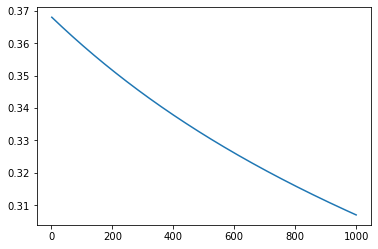

In [73]:
import matplotlib.pyplot as plt 
plt.plot(Iterations, losses, label="Train")

In [58]:
losses

[]